In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("VENTAS_TROCIUK3.csv", sep=";", encoding="latin-1")


In [3]:
df.columns

Index([',FECHA,COD_ARTICULO,DESCRIPCION,TOTAL_CANTIDAD,PRECIO_UNITARIO'], dtype='object')

In [4]:
df = pd.read_csv("VENTAS_TROCIUK3.csv", sep=",", encoding="latin-1", quotechar='"', on_bad_lines="skip")
df.to_csv("VENTAS_TROCIUK3_4webapp.csv", index=False)

In [5]:
# Contar ocurrencias en la columna "DESCRIPCION"
descripcion_counts = df["DESCRIPCION"].value_counts()

# Filtrar los valores con más de 365 registros
filtered_descriptions = descripcion_counts[descripcion_counts > 3650].index.tolist()

len(filtered_descriptions)


39

In [6]:
# Ahora voy a trabajar solamente con filtered_descriptions, son 40 productos los cuales tiene mas de 3650 registros

In [7]:
!pip install prophet


  Using cached prophet-1.1.6-py3-none-macosx_11_0_arm64.whl.metadata (3.5 kB)
  Using cached cmdstanpy-1.2.5-py3-none-any.whl.metadata (4.0 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached stanio-0.5.1-py3-none-any.whl.metadata (1.6 kB)
Using cached prophet-1.1.6-py3-none-macosx_11_0_arm64.whl (8.2 MB)
Using cached cmdstanpy-1.2.5-py3-none-any.whl (94 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.9/863.9 kB 2.5 MB/s eta 0:00:00-:--:--
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
Using cached stanio-0.5.1-py3-none-any.whl (8.1 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [8]:
import pandas as pd

# --- Define a function to generate fixed-date holidays for each year ---
def generate_py_fixed_holidays(start_year=2003, end_year=2025):
    """
    Generates a DataFrame of fixed-date Paraguayan holidays (NO moveable ones).
    Adjust or add more holidays as needed.
    """
    years = range(start_year, end_year + 1)
    holiday_list = []

    for y in years:
        # 1 Jan - Año Nuevo
        holiday_list.append({"holiday": "Año Nuevo", "ds": pd.to_datetime(f"{y}-01-01")})
        # 1 Mar - Día de los Héroes (fixed date)
        holiday_list.append({"holiday": "Día de los Héroes", "ds": pd.to_datetime(f"{y}-03-01")})
        # 1 May - Día del Trabajador
        holiday_list.append({"holiday": "Día del Trabajador", "ds": pd.to_datetime(f"{y}-05-01")})
        # 14 May - Independencia de Paraguay (often celebrated 14th & 15th, here just 14th)
        holiday_list.append({"holiday": "Día de Independencia", "ds": pd.to_datetime(f"{y}-05-14")})
        # 12 Jun - Paz del Chaco
        holiday_list.append({"holiday": "Paz del Chaco", "ds": pd.to_datetime(f"{y}-06-12")})
        # 15 Aug - Fundación de Asunción
        holiday_list.append({"holiday": "Fundación de Asunción", "ds": pd.to_datetime(f"{y}-08-15")})
        # 29 Sep - Victoria de Boquerón
        holiday_list.append({"holiday": "Victoria de Boquerón", "ds": pd.to_datetime(f"{y}-09-29")})
        # 8 Dec - Virgen de Caacupé
        holiday_list.append({"holiday": "Virgen de Caacupé", "ds": pd.to_datetime(f"{y}-12-08")})
        # 25 Dec - Navidad
        holiday_list.append({"holiday": "Navidad", "ds": pd.to_datetime(f"{y}-12-25")})

    return pd.DataFrame(holiday_list)

# Generate the fixed holidays from 2003 to 2025
py_public_holidays = generate_py_fixed_holidays(2003, 2025)


In [10]:
!pip install scikit-learn

  Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl (11.2 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 3.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [9]:
import os
import pandas as pd
import itertools
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error

# -------------------------------------------------------------------------
# A. Create an output directory for forecasts
# -------------------------------------------------------------------------
output_dir = "forecasts"
os.makedirs(output_dir, exist_ok=True)

# -------------------------------------------------------------------------
# B. Generate or load Paraguayan holidays (already defined)
# -------------------------------------------------------------------------
py_public_holidays = generate_py_fixed_holidays(2003, 2025)

# -------------------------------------------------------------------------
# C. Define a *smaller* hyperparameter grid
#    (fewer combos => faster)
# -------------------------------------------------------------------------
param_grid = {
    # Only 2 modes
    "seasonality_mode": ["multiplicative"],
    # Fewer scales => less searching
    "changepoint_prior_scale": [0.1, 0.5],
    "seasonality_prior_scale": [5.0, 10.0],
    # Fix or remove some toggles to reduce combos
    # e.g. set weekly_seasonality=True and yearly_seasonality=True by default
}
all_params = [
    dict(zip(param_grid.keys(), v))
    for v in itertools.product(*param_grid.values())
]

# -------------------------------------------------------------------------
# D. (Optional) Outlier Removal
# -------------------------------------------------------------------------
def remove_outliers(df, multiple=3.0):
    """
    Simple IQR-based outlier removal.
    """
    y = df["y"]
    q1 = y.quantile(0.25)
    q3 = y.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - multiple * iqr
    upper_bound = q3 + multiple * iqr
    df_filtered = df[(y >= lower_bound) & (y <= upper_bound)]
    return df_filtered

# -------------------------------------------------------------------------
# E. Single Train/Test Split Function
# -------------------------------------------------------------------------
def train_test_split_prophet(df, test_start_date):
    """
    Splits df into train_df (ds < test_start_date)
    and test_df (test_start_date <= ds <= cutoff_date_for_testing).
    """
    df_train = df[df["ds"] < test_start_date].copy()
    df_test = df[(df["ds"] >= test_start_date) & (df["ds"] <= pd.to_datetime("2023-12-31"))].copy()
    return df_train, df_test

# -------------------------------------------------------------------------
# F. Main Loop
# -------------------------------------------------------------------------
productos = df["DESCRIPCION"].unique()

for producto in productos:
    # 1) Prepare Data
    df_producto = df[df["DESCRIPCION"] == producto].copy()
    df_producto = df_producto[["FECHA", "TOTAL_CANTIDAD"]].rename(
        columns={"FECHA": "ds", "TOTAL_CANTIDAD": "y"}
    )
    df_producto["ds"] = pd.to_datetime(df_producto["ds"], format="%d/%m/%Y")

    # Filter to training cutoff = 31/12/2023
    cutoff_date = pd.to_datetime("2023-12-31")
    df_full = df_producto[df_producto["ds"] <= cutoff_date].copy()

    # Outlier removal (optional)
    df_full = remove_outliers(df_full, multiple=3.0)

    if len(df_full) < 10:
        print(f"[{producto}] Omitido: <10 registros válidos después de remover outliers.")
        continue

    # 2) SINGLE TRAIN/TEST SPLIT:
    #    Let's define test_start_date as e.g. "2023-07-01" (last 6 months for test)
    test_start_date = pd.to_datetime("2023-07-01")
    df_train, df_test = train_test_split_prophet(df_full, test_start_date)

    # If test set is empty or too small, default to an earlier date
    if len(df_test) < 3:
        test_start_date = df_full["ds"].quantile(0.8)  # 80% train, 20% test
        df_train, df_test = train_test_split_prophet(df_full, test_start_date)

    if len(df_train) < 5 or len(df_test) < 2:
        print(f"[{producto}] Omitido: split train/test inadecuado.")
        continue

    best_params = None
    best_mape = float("inf")

    # 3) Loop over fewer param combos
    for params in all_params:
        # Build a Prophet model with these params
        model = Prophet(
            growth="linear",
            daily_seasonality=False,
            weekly_seasonality=True,
            yearly_seasonality=True,
            holidays=py_public_holidays,
            interval_width=0.95,
            **params
        )

        # Fit on train
        try:
            model.fit(df_train)
        except Exception as e:
            print(f"[{producto}] Error fitting model with {params}: {e}")
            continue

        # Predict on test
        future_test = pd.DataFrame({"ds": df_test["ds"]})
        forecast_test = model.predict(future_test)

        # Merge with actual y for MAPE
        merged_test = pd.merge(
            df_test[["ds", "y"]],
            forecast_test[["ds", "yhat"]],
            on="ds", how="inner"
        )

        if merged_test.empty:
            continue

        # Compute MAPE (sklearn)
        y_true = merged_test["y"].values
        y_pred = merged_test["yhat"].values

        # Filter out zero actuals if needed or add small epsilon
        # Here we do standard MAPE:
        this_mape = mean_absolute_percentage_error(y_true, y_pred) * 100

        # Compare
        if this_mape < best_mape:
            best_mape = this_mape
            best_params = params

    if best_params is None:
        print(f"[{producto}] No valid model found in param grid.")
        continue

    print(f"[{producto}] Best Params: {best_params}, Test MAPE = {best_mape:.2f}%")

    # 4) Retrain BEST MODEL on the FULL data (df_full)
    final_model = Prophet(
        growth="linear",
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        holidays=py_public_holidays,
        interval_width=0.95,
        **best_params
    )
    final_model.fit(df_full)

    # 5) Forecast 2024 and 2025
    future_periods = 365 * 2
    future = final_model.make_future_dataframe(periods=future_periods)
    forecast = final_model.predict(future)

    # 6) Save forecast
    file_name = f"{output_dir}/{producto.replace(' ', '_')}_forecast.csv"
    forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].to_csv(file_name, index=False)
    print(f"[{producto}] Forecast saved -> {file_name}")


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


ModuleNotFoundError: No module named 'sklearn'

In [11]:
%pip install pmdarima

  Using cached urllib3-2.3.0-py3-none-any.whl.metadata (6.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 375.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 1.3 MB/s eta 0:00:0000:0100:01
Using cached urllib3-2.3.0-py3-none-any.whl (128 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
import os
import pandas as pd
import numpy as np
import itertools

# Prophet
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error

# ARIMA (statsmodels)
from statsmodels.tsa.arima.model import ARIMA

# Exponential Smoothing (statsmodels)
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# -------------------------------------------------------------------------
# A. Create an output directory for forecasts
# -------------------------------------------------------------------------
output_dir = "forecasts"
os.makedirs(output_dir, exist_ok=True)

# -------------------------------------------------------------------------
# B. Generate or load holidays (or remove if not needed)
#    Replace this with your actual holiday logic if desired
# -------------------------------------------------------------------------
def generate_py_fixed_holidays(start_year, end_year):
    """
    Dummy function. Replace with your real holiday logic or remove from Prophet arguments
    if you don't need holiday adjustments.
    """
    # Just return an empty DataFrame if no holidays
    return pd.DataFrame(columns=["ds", "holiday"])

py_public_holidays = generate_py_fixed_holidays(2003, 2025)

# -------------------------------------------------------------------------
# C. Hyperparameter grid for Prophet
# -------------------------------------------------------------------------
param_grid = {
    "seasonality_mode": ["multiplicative"],
    "changepoint_prior_scale": [0.1, 0.5],
    "seasonality_prior_scale": [5.0, 10.0],
}
all_params = [
    dict(zip(param_grid.keys(), v))
    for v in itertools.product(*param_grid.values())
]

# -------------------------------------------------------------------------
# D. (Optional) Outlier Removal
# -------------------------------------------------------------------------
def remove_outliers(df, multiple=3.0):
    """
    Simple IQR-based outlier removal.
    """
    y = df["y"]
    q1 = y.quantile(0.25)
    q3 = y.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - multiple * iqr
    upper_bound = q3 + multiple * iqr
    df_filtered = df[(y >= lower_bound) & (y <= upper_bound)]
    return df_filtered

# -------------------------------------------------------------------------
# E. Train/Test Split Function
# -------------------------------------------------------------------------
def train_test_split_func(df, test_start_date):
    """
    Splits df into train_df (ds < test_start_date)
    and test_df (test_start_date <= ds <= '2023-12-31').
    """
    df_train = df[df["ds"] < test_start_date].copy()
    df_test = df[(df["ds"] >= test_start_date) & (df["ds"] <= pd.to_datetime("2023-12-31"))].copy()
    return df_train, df_test

# -------------------------------------------------------------------------
# F. Forecasting Functions
# -------------------------------------------------------------------------

def forecast_with_prophet(df_train, df_test):
    """
    Runs a small hyperparameter search over `all_params`,
    returns (best_params, best_mape).
    (We DON'T return the fitted model, because Prophet can't be re-fit.)
    """
    best_params = None
    best_mape = float("inf")

    for params in all_params:
        model = Prophet(
            growth="linear",
            daily_seasonality=False,
            weekly_seasonality=True,
            yearly_seasonality=True,
            holidays=py_public_holidays,
            interval_width=0.95,
            **params
        )

        try:
            model.fit(df_train)
        except Exception:
            continue

        # Predict on test
        future_test = pd.DataFrame({"ds": df_test["ds"]})
        forecast_test = model.predict(future_test)

        # Merge with actual
        merged_test = pd.merge(
            df_test[["ds", "y"]],
            forecast_test[["ds", "yhat"]],
            on="ds", how="inner"
        )

        if merged_test.empty:
            continue

        y_true = merged_test["y"].values
        y_pred = merged_test["yhat"].values
        this_mape = mean_absolute_percentage_error(y_true, y_pred) * 100

        if this_mape < best_mape:
            best_mape = this_mape
            best_params = params

    return best_params, best_mape

def forecast_with_statsmodels_arima(df_train, df_test):
    """
    Manual grid search over (p,d,q) for ARIMA on df_train;
    evaluate on df_test to get best MAPE.
    Returns (best_order, best_mape).
    """
    df_train_sorted = df_train.sort_values("ds").copy()
    df_train_sorted.set_index("ds", inplace=True)

    df_test_sorted = df_test.sort_values("ds").copy()
    if len(df_test_sorted) == 0:
        return None, np.nan

    p_values = [0, 1, 2]
    d_values = [0, 1]
    q_values = [0, 1, 2]

    best_mape = float("inf")
    best_order = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    model = ARIMA(df_train_sorted["y"], order=order)
                    fitted = model.fit()
                except:
                    continue  # skip invalid orders

                # Forecast same length as test
                n_test = len(df_test_sorted)
                fc = fitted.forecast(steps=n_test)

                y_true = df_test_sorted["y"].values
                y_pred = fc.values

                if len(y_true) != len(y_pred):
                    continue

                this_mape = mean_absolute_percentage_error(y_true, y_pred) * 100
                if this_mape < best_mape:
                    best_mape = this_mape
                    best_order = order

    return best_order, best_mape

def forecast_with_ets(df_train, df_test):
    """
    Fits Exponential Smoothing on df_train,
    returns (best_model, test_mape).
    """
    df_train_sorted = df_train.sort_values("ds").copy()
    df_train_sorted.set_index("ds", inplace=True)

    df_test_sorted = df_test.sort_values("ds").copy()
    if len(df_test_sorted) == 0:
        return None, np.nan

    try:
        es_model = ExponentialSmoothing(
            df_train_sorted["y"],
            trend="add",       # or "mul"/None
            seasonal=None,     # or "add"/"mul" if you suspect seasonality
            initialization_method="estimated"
        ).fit()
    except:
        return None, np.nan

    n_test = len(df_test_sorted)
    if n_test == 0:
        return None, np.nan

    y_pred = es_model.forecast(n_test)
    y_true = df_test_sorted["y"].values

    if len(y_true) != len(y_pred):
        return None, np.nan

    test_mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return es_model, test_mape

# -------------------------------------------------------------------------
# G. Main Loop (Example)
# -------------------------------------------------------------------------

# Example: Suppose 'df' is your DataFrame with:
# ["FECHA", "TOTAL_CANTIDAD", "DESCRIPCION"]

# df = pd.read_csv("your_data.csv")  # adapt as needed
productos = df["DESCRIPCION"].unique()

for producto in productos:
    # 1) Prepare Data
    df_producto = df[df["DESCRIPCION"] == producto].copy()
    df_producto = df_producto[["FECHA", "TOTAL_CANTIDAD"]].rename(
        columns={"FECHA": "ds", "TOTAL_CANTIDAD": "y"}
    )
    df_producto["ds"] = pd.to_datetime(df_producto["ds"], format="%d/%m/%Y")

    # Filter to training cutoff = 31/12/2023
    cutoff_date = pd.to_datetime("2023-12-31")
    df_full = df_producto[df_producto["ds"] <= cutoff_date].copy()

    # Outlier removal (optional)
    df_full = remove_outliers(df_full, multiple=3.0)

    if len(df_full) < 10:
        print(f"[{producto}] Omitted: <10 valid records after outlier removal.")
        continue

    # 2) Train/Test Split
    test_start_date = pd.to_datetime("2023-07-01")
    df_train, df_test = train_test_split_func(df_full, test_start_date)

    # If test is too small, fallback to an 80/20 date split
    if len(df_test) < 3:
        test_start_date = df_full["ds"].quantile(0.8)
        df_train, df_test = train_test_split_func(df_full, test_start_date)

    if len(df_train) < 5 or len(df_test) < 2:
        print(f"[{producto}] Omitted: train/test split invalid.")
        continue

    # ---------------------------------------------------------------------
    # 3) PROPHET
    # ---------------------------------------------------------------------
    best_prophet_params, best_prophet_mape = forecast_with_prophet(df_train, df_test)
    if best_prophet_params is not None:
        print(f"[{producto}] Prophet best_params = {best_prophet_params}, Test MAPE = {best_prophet_mape:.2f}%")
        # >>> CREATE A NEW MODEL with the best params <<<
        final_prophet_model = Prophet(
            growth="linear",
            daily_seasonality=False,
            weekly_seasonality=True,
            yearly_seasonality=True,
            holidays=py_public_holidays,
            interval_width=0.95,
            **best_prophet_params
        )
        # Retrain on full data
        final_prophet_model.fit(df_full)

        # Forecast 2 years
        future_periods = 365 * 2
        future_dates = final_prophet_model.make_future_dataframe(periods=future_periods)
        forecast_prophet = final_prophet_model.predict(future_dates)

        file_name_prophet = f"{output_dir}/{producto.replace(' ', '_')}_forecast_prophet.csv"
        forecast_prophet[["ds", "yhat", "yhat_lower", "yhat_upper"]].to_csv(file_name_prophet, index=False)
        print(f"[{producto}] Prophet forecast saved -> {file_name_prophet}")
    else:
        print(f"[{producto}] Prophet: No valid model found.")

    # ---------------------------------------------------------------------
    # 4) ARIMA (statsmodels)
    # ---------------------------------------------------------------------
    best_arima_order, best_arima_mape = forecast_with_statsmodels_arima(df_train, df_test)
    if best_arima_order is not None and not np.isnan(best_arima_mape):
        print(f"[{producto}] ARIMA best_order = {best_arima_order}, Test MAPE = {best_arima_mape:.2f}%")

        # Refit on full data
        df_full_sorted = df_full.sort_values("ds").copy()
        df_full_sorted.set_index("ds", inplace=True)

        full_model = ARIMA(df_full_sorted["y"], order=best_arima_order).fit()

        # Forecast next 2 years (daily freq)
        future_periods = 365 * 2
        fc = full_model.forecast(steps=future_periods)

        last_date = df_full_sorted.index.max()
        future_dates_arima = pd.date_range(start=last_date + pd.Timedelta(days=1),
                                           periods=future_periods, freq='D')
        df_arima_forecast = pd.DataFrame({
            "ds": future_dates_arima,
            "yhat": fc.values
        })
        file_name_arima = f"{output_dir}/{producto.replace(' ', '_')}_forecast_arima.csv"
        df_arima_forecast.to_csv(file_name_arima, index=False)
        print(f"[{producto}] ARIMA forecast saved -> {file_name_arima}")
    else:
        print(f"[{producto}] ARIMA: Could not fit or forecast properly.")

    # ---------------------------------------------------------------------
    # 5) Exponential Smoothing (ETS)
    # ---------------------------------------------------------------------
    ets_model, ets_mape = forecast_with_ets(df_train, df_test)
    if ets_model is not None and not np.isnan(ets_mape):
        print(f"[{producto}] ETS Test MAPE = {ets_mape:.2f}%")

        # Refit on full data
        df_full_sorted = df_full.sort_values("ds").copy()
        df_full_sorted.set_index("ds", inplace=True)

        ets_model_full = ExponentialSmoothing(
            df_full_sorted["y"],
            trend="add",  # or "mul"/None
            seasonal=None,  # or "add"/"mul"
            initialization_method="estimated"
        ).fit()

        # Forecast next 2 years
        future_periods = 365 * 2
        forecast_ets = ets_model_full.forecast(future_periods)

        last_date = df_full_sorted.index.max()
        future_dates_ets = pd.date_range(
            start=last_date + pd.Timedelta(days=1),
            periods=future_periods,
            freq='D'
        )
        df_ets_forecast = pd.DataFrame({
            "ds": future_dates_ets,
            "yhat": forecast_ets
        })

        file_name_ets = f"{output_dir}/{producto.replace(' ', '_')}_forecast_ets.csv"
        df_ets_forecast.to_csv(file_name_ets, index=False)
        print(f"[{producto}] ETS forecast saved -> {file_name_ets}")
    else:
        print(f"[{producto}] ETS: Could not fit or forecast properly.")

    print("-------------------------------------------------------------")


23:13:06 - cmdstanpy - INFO - Chain [1] start processing
23:13:07 - cmdstanpy - INFO - Chain [1] done processing
23:13:08 - cmdstanpy - INFO - Chain [1] start processing
23:13:08 - cmdstanpy - INFO - Chain [1] done processing
23:13:09 - cmdstanpy - INFO - Chain [1] start processing
23:13:10 - cmdstanpy - INFO - Chain [1] done processing
23:13:10 - cmdstanpy - INFO - Chain [1] start processing
23:13:11 - cmdstanpy - INFO - Chain [1] done processing


[Aves Ponedora 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}, Test MAPE = 210.03%


23:13:11 - cmdstanpy - INFO - Chain [1] start processing
23:13:12 - cmdstanpy - INFO - Chain [1] done processing


[Aves Ponedora 50 Kg.] Prophet forecast saved -> forecasts/Aves_Ponedora_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Aves Ponedora 50 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 92.06%
[Aves Ponedora 50 Kg.] ARIMA forecast saved -> forecasts/Aves_Ponedora_50_Kg._forecast_arima.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[Aves Ponedora 50 Kg.] ETS Test MAPE = 120.42%
[Aves Ponedora 50 Kg.] ETS forecast saved -> forecasts/Aves_Ponedora_50_Kg._forecast_ets.csv
-------------------------------------------------------------


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
23:13:24 - cmdstanpy - INFO - Chain [1] start processing
23:13:25 - cmdstanpy - INFO - Chain [1] done processing
23:13:25 - cmdstanpy - INFO - Chain [1] start processing
23:13:26 - cmdstanpy - INFO - Chain [1] done processing
23:13:26 - cmdstanpy - INFO - Chain [1] start processing
23:13:27 - cmdstanpy - INFO - Chain [1] done processing
23:13:27 - cmdstanpy - INFO - Chain [1] start processing
23:13:28 - cmdstanp

[Equinos Integral 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}, Test MAPE = 344.15%


23:13:29 - cmdstanpy - INFO - Chain [1] start processing
23:13:30 - cmdstanpy - INFO - Chain [1] done processing


[Equinos Integral 50 Kg.] Prophet forecast saved -> forecasts/Equinos_Integral_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Equinos Integral 50 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 173.65%
[Equinos Integral 50 Kg.] ARIMA forecast saved -> forecasts/Equinos_Integral_50_Kg._forecast_arima.csv
[Equinos Integral 50 Kg.] ETS Test MAPE = 272.38%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
23:13:39 - cmdstanpy - INFO - Chain [1] start processing
23:13:39 - cmdstanpy - INFO - Chain [1] done processing


[Equinos Integral 50 Kg.] ETS forecast saved -> forecasts/Equinos_Integral_50_Kg._forecast_ets.csv
-------------------------------------------------------------


23:13:39 - cmdstanpy - INFO - Chain [1] start processing
23:13:39 - cmdstanpy - INFO - Chain [1] done processing
23:13:39 - cmdstanpy - INFO - Chain [1] start processing
23:13:39 - cmdstanpy - INFO - Chain [1] done processing
23:13:39 - cmdstanpy - INFO - Chain [1] start processing
23:13:39 - cmdstanpy - INFO - Chain [1] done processing
23:13:39 - cmdstanpy - INFO - Chain [1] start processing
23:13:39 - cmdstanpy - INFO - Chain [1] done processing


[Equinos Potro 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0}, Test MAPE = 196.97%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[Equinos Potro 50 Kg.] Prophet forecast saved -> forecasts/Equinos_Potro_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Equinos Potro 50 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 67.53%
[Equinos Potro 50 Kg.] ARIMA forecast saved -> forecasts/Equinos_Potro_50_Kg._forecast_arima.csv
[Equinos Potro 50 Kg.] ETS Test MAPE = 227.38%
[Equinos Potro 50 Kg.] ETS forecast saved -> forecasts/Equinos_Potro_50_Kg._forecast_ets.csv
-------------------------------------------------------------


23:13:41 - cmdstanpy - INFO - Chain [1] start processing
23:13:41 - cmdstanpy - INFO - Chain [1] done processing
23:13:42 - cmdstanpy - INFO - Chain [1] start processing
23:13:42 - cmdstanpy - INFO - Chain [1] done processing
23:13:42 - cmdstanpy - INFO - Chain [1] start processing
23:13:42 - cmdstanpy - INFO - Chain [1] done processing
23:13:42 - cmdstanpy - INFO - Chain [1] start processing
23:13:43 - cmdstanpy - INFO - Chain [1] done processing
23:13:43 - cmdstanpy - INFO - Chain [1] start processing


[Bovino Ternero Inicial 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}, Test MAPE = 657.33%


23:13:43 - cmdstanpy - INFO - Chain [1] done processing


[Bovino Ternero Inicial 50 Kg.] Prophet forecast saved -> forecasts/Bovino_Ternero_Inicial_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Bovino Ternero Inicial 50 Kg.] ARIMA best_order = (0, 0, 1), Test MAPE = 346.96%
[Bovino Ternero Inicial 50 Kg.] ARIMA forecast saved -> forecasts/Bovino_Ternero_Inicial_50_Kg._forecast_arima.csv
[Bovino Ternero Inicial 50 Kg.] ETS Test MAPE = 741.27%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


[Bovino Ternero Inicial 50 Kg.] ETS forecast saved -> forecasts/Bovino_Ternero_Inicial_50_Kg._forecast_ets.csv
-------------------------------------------------------------


23:13:49 - cmdstanpy - INFO - Chain [1] start processing
23:13:49 - cmdstanpy - INFO - Chain [1] done processing
23:13:49 - cmdstanpy - INFO - Chain [1] start processing
23:13:50 - cmdstanpy - INFO - Chain [1] done processing
23:13:50 - cmdstanpy - INFO - Chain [1] start processing
23:13:50 - cmdstanpy - INFO - Chain [1] done processing
23:13:51 - cmdstanpy - INFO - Chain [1] start processing
23:13:52 - cmdstanpy - INFO - Chain [1] done processing


[Desmamantes High Protein 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0}, Test MAPE = 391.23%


23:13:52 - cmdstanpy - INFO - Chain [1] start processing
23:13:52 - cmdstanpy - INFO - Chain [1] done processing


[Desmamantes High Protein 50 Kg.] Prophet forecast saved -> forecasts/Desmamantes_High_Protein_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Desmamantes High Protein 50 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 78.72%
[Desmamantes High Protein 50 Kg.] ARIMA forecast saved -> forecasts/Desmamantes_High_Protein_50_Kg._forecast_arima.csv
[Desmamantes High Protein 50 Kg.] ETS Test MAPE = 615.95%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


[Desmamantes High Protein 50 Kg.] ETS forecast saved -> forecasts/Desmamantes_High_Protein_50_Kg._forecast_ets.csv
-------------------------------------------------------------


23:13:59 - cmdstanpy - INFO - Chain [1] start processing
23:14:00 - cmdstanpy - INFO - Chain [1] done processing
23:14:00 - cmdstanpy - INFO - Chain [1] start processing
23:14:01 - cmdstanpy - INFO - Chain [1] done processing
23:14:01 - cmdstanpy - INFO - Chain [1] start processing
23:14:03 - cmdstanpy - INFO - Chain [1] done processing
23:14:03 - cmdstanpy - INFO - Chain [1] start processing
23:14:05 - cmdstanpy - INFO - Chain [1] done processing


[Lecheras A.P. 22% - 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}, Test MAPE = 371.55%


23:14:05 - cmdstanpy - INFO - Chain [1] start processing
23:14:06 - cmdstanpy - INFO - Chain [1] done processing


[Lecheras A.P. 22% - 50 Kg.] Prophet forecast saved -> forecasts/Lecheras_A.P._22%_-_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Lecheras A.P. 22% - 50 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 85.48%
[Lecheras A.P. 22% - 50 Kg.] ARIMA forecast saved -> forecasts/Lecheras_A.P._22%_-_50_Kg._forecast_arima.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[Lecheras A.P. 22% - 50 Kg.] ETS Test MAPE = 964.61%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
23:14:20 - cmdstanpy - INFO - Chain [1] start processing
23:14:20 - cmdstanpy - INFO - Chain [1] done processing
23:14:20 - cmdstanpy - INFO - Chain [1] start processing


[Lecheras A.P. 22% - 50 Kg.] ETS forecast saved -> forecasts/Lecheras_A.P._22%_-_50_Kg._forecast_ets.csv
-------------------------------------------------------------


23:14:20 - cmdstanpy - INFO - Chain [1] done processing
23:14:20 - cmdstanpy - INFO - Chain [1] start processing
23:14:20 - cmdstanpy - INFO - Chain [1] done processing
23:14:20 - cmdstanpy - INFO - Chain [1] start processing
23:14:20 - cmdstanpy - INFO - Chain [1] done processing
23:14:20 - cmdstanpy - INFO - Chain [1] start processing
23:14:21 - cmdstanpy - INFO - Chain [1] done processing


[Vaca Seca 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0}, Test MAPE = 161.39%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[Vaca Seca 50 Kg.] Prophet forecast saved -> forecasts/Vaca_Seca_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Vaca Seca 50 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 60.08%
[Vaca Seca 50 Kg.] ARIMA forecast saved -> forecasts/Vaca_Seca_50_Kg._forecast_arima.csv
[Vaca Seca 50 Kg.] ETS Test MAPE = 189.68%
[Vaca Seca 50 Kg.] ETS forecast saved -> forecasts/Vaca_Seca_50_Kg._forecast_ets.csv
-------------------------------------------------------------


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Aves Iniciador 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0}, Test MAPE = 253.92%


23:14:24 - cmdstanpy - INFO - Chain [1] done processing


[Aves Iniciador 50 Kg.] Prophet forecast saved -> forecasts/Aves_Iniciador_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Aves Iniciador 50 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 56.98%
[Aves Iniciador 50 Kg.] ARIMA forecast saved -> forecasts/Aves_Iniciador_50_Kg._forecast_arima.csv
[Aves Iniciador 50 Kg.] ETS Test MAPE = 1423.11%
[Aves Iniciador 50 Kg.] ETS forecast saved -> forecasts/Aves_Iniciador_50_Kg._forecast_ets.csv
-------------------------------------------------------------


23:14:30 - cmdstanpy - INFO - Chain [1] start processing
23:14:30 - cmdstanpy - INFO - Chain [1] done processing
23:14:30 - cmdstanpy - INFO - Chain [1] start processing
23:14:30 - cmdstanpy - INFO - Chain [1] done processing
23:14:30 - cmdstanpy - INFO - Chain [1] start processing
23:14:31 - cmdstanpy - INFO - Chain [1] done processing
23:14:31 - cmdstanpy - INFO - Chain [1] start processing
23:14:31 - cmdstanpy - INFO - Chain [1] done processing
23:14:31 - cmdstanpy - INFO - Chain [1] start processing


[Aves Terminador 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0}, Test MAPE = 233.89%


23:14:32 - cmdstanpy - INFO - Chain [1] done processing


[Aves Terminador 50 Kg.] Prophet forecast saved -> forecasts/Aves_Terminador_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Aves Terminador 50 Kg.] ARIMA best_order = (2, 1, 0), Test MAPE = 73.95%
[Aves Terminador 50 Kg.] ARIMA forecast saved -> forecasts/Aves_Terminador_50_Kg._forecast_arima.csv
[Aves Terminador 50 Kg.] ETS Test MAPE = 145.97%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


[Aves Terminador 50 Kg.] ETS forecast saved -> forecasts/Aves_Terminador_50_Kg._forecast_ets.csv
-------------------------------------------------------------


23:14:37 - cmdstanpy - INFO - Chain [1] start processing
23:14:38 - cmdstanpy - INFO - Chain [1] done processing
23:14:38 - cmdstanpy - INFO - Chain [1] start processing
23:14:39 - cmdstanpy - INFO - Chain [1] done processing
23:14:39 - cmdstanpy - INFO - Chain [1] start processing
23:14:41 - cmdstanpy - INFO - Chain [1] done processing
23:14:42 - cmdstanpy - INFO - Chain [1] start processing
23:14:44 - cmdstanpy - INFO - Chain [1] done processing


[Aves Ponedora 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}, Test MAPE = 396.12%


23:14:44 - cmdstanpy - INFO - Chain [1] start processing
23:14:47 - cmdstanpy - INFO - Chain [1] done processing


[Aves Ponedora 25 Kg.] Prophet forecast saved -> forecasts/Aves_Ponedora_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Aves Ponedora 25 Kg.] ARIMA best_order = (2, 1, 0), Test MAPE = 377.97%
[Aves Ponedora 25 Kg.] ARIMA forecast saved -> forecasts/Aves_Ponedora_25_Kg._forecast_arima.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[Aves Ponedora 25 Kg.] ETS Test MAPE = 750.66%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
23:15:03 - cmdstanpy - INFO - Chain [1] start processing


[Aves Ponedora 25 Kg.] ETS forecast saved -> forecasts/Aves_Ponedora_25_Kg._forecast_ets.csv
-------------------------------------------------------------


23:15:03 - cmdstanpy - INFO - Chain [1] done processing
23:15:04 - cmdstanpy - INFO - Chain [1] start processing
23:15:04 - cmdstanpy - INFO - Chain [1] done processing
23:15:04 - cmdstanpy - INFO - Chain [1] start processing
23:15:05 - cmdstanpy - INFO - Chain [1] done processing
23:15:05 - cmdstanpy - INFO - Chain [1] start processing
23:15:05 - cmdstanpy - INFO - Chain [1] done processing


[Aves Crecimiento 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0}, Test MAPE = 224.06%


23:15:06 - cmdstanpy - INFO - Chain [1] start processing
23:15:06 - cmdstanpy - INFO - Chain [1] done processing


[Aves Crecimiento 50 Kg.] Prophet forecast saved -> forecasts/Aves_Crecimiento_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Aves Crecimiento 50 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 223.60%
[Aves Crecimiento 50 Kg.] ARIMA forecast saved -> forecasts/Aves_Crecimiento_50_Kg._forecast_arima.csv
[Aves Crecimiento 50 Kg.] ETS Test MAPE = 2848.45%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


[Aves Crecimiento 50 Kg.] ETS forecast saved -> forecasts/Aves_Crecimiento_50_Kg._forecast_ets.csv
-------------------------------------------------------------


23:15:12 - cmdstanpy - INFO - Chain [1] start processing
23:15:13 - cmdstanpy - INFO - Chain [1] done processing
23:15:14 - cmdstanpy - INFO - Chain [1] start processing
23:15:15 - cmdstanpy - INFO - Chain [1] done processing
23:15:15 - cmdstanpy - INFO - Chain [1] start processing
23:15:17 - cmdstanpy - INFO - Chain [1] done processing
23:15:18 - cmdstanpy - INFO - Chain [1] start processing
23:15:19 - cmdstanpy - INFO - Chain [1] done processing


[Aves Iniciador 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}, Test MAPE = 622.86%


23:15:19 - cmdstanpy - INFO - Chain [1] start processing
23:15:21 - cmdstanpy - INFO - Chain [1] done processing


[Aves Iniciador 25 Kg.] Prophet forecast saved -> forecasts/Aves_Iniciador_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Aves Iniciador 25 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 77.72%
[Aves Iniciador 25 Kg.] ARIMA forecast saved -> forecasts/Aves_Iniciador_25_Kg._forecast_arima.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[Aves Iniciador 25 Kg.] ETS Test MAPE = 296.66%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
23:15:39 - cmdstanpy - INFO - Chain [1] start processing


[Aves Iniciador 25 Kg.] ETS forecast saved -> forecasts/Aves_Iniciador_25_Kg._forecast_ets.csv
-------------------------------------------------------------


23:15:39 - cmdstanpy - INFO - Chain [1] done processing
23:15:39 - cmdstanpy - INFO - Chain [1] start processing
23:15:39 - cmdstanpy - INFO - Chain [1] done processing
23:15:40 - cmdstanpy - INFO - Chain [1] start processing
23:15:40 - cmdstanpy - INFO - Chain [1] done processing
23:15:40 - cmdstanpy - INFO - Chain [1] start processing
23:15:40 - cmdstanpy - INFO - Chain [1] done processing
23:15:41 - cmdstanpy - INFO - Chain [1] start processing


[Avestruz 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}, Test MAPE = 164.30%


23:15:41 - cmdstanpy - INFO - Chain [1] done processing


[Avestruz 25 Kg.] Prophet forecast saved -> forecasts/Avestruz_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Avestruz 25 Kg.] ARIMA best_order = (0, 0, 1), Test MAPE = 118.34%
[Avestruz 25 Kg.] ARIMA forecast saved -> forecasts/Avestruz_25_Kg._forecast_arima.csv
[Avestruz 25 Kg.] ETS Test MAPE = 151.46%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
23:21:09 - cmdstanpy - INFO - Chain [1] start processing


[Avestruz 25 Kg.] ETS forecast saved -> forecasts/Avestruz_25_Kg._forecast_ets.csv
-------------------------------------------------------------


23:21:09 - cmdstanpy - INFO - Chain [1] done processing
23:21:10 - cmdstanpy - INFO - Chain [1] start processing
23:21:10 - cmdstanpy - INFO - Chain [1] done processing
23:21:10 - cmdstanpy - INFO - Chain [1] start processing
23:21:10 - cmdstanpy - INFO - Chain [1] done processing
23:21:11 - cmdstanpy - INFO - Chain [1] start processing
23:21:11 - cmdstanpy - INFO - Chain [1] done processing
23:21:11 - cmdstanpy - INFO - Chain [1] start processing


[Cerdos Crecimiento 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}, Test MAPE = 172.81%


23:21:11 - cmdstanpy - INFO - Chain [1] done processing


[Cerdos Crecimiento 50 Kg.] Prophet forecast saved -> forecasts/Cerdos_Crecimiento_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Cerdos Crecimiento 50 Kg.] ARIMA best_order = (1, 1, 2), Test MAPE = 198.91%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: 

[Cerdos Crecimiento 50 Kg.] ARIMA forecast saved -> forecasts/Cerdos_Crecimiento_50_Kg._forecast_arima.csv
[Cerdos Crecimiento 50 Kg.] ETS Test MAPE = 328.35%
[Cerdos Crecimiento 50 Kg.] ETS forecast saved -> forecasts/Cerdos_Crecimiento_50_Kg._forecast_ets.csv
-------------------------------------------------------------


23:23:37 - cmdstanpy - INFO - Chain [1] start processing
23:23:38 - cmdstanpy - INFO - Chain [1] done processing
23:23:38 - cmdstanpy - INFO - Chain [1] start processing
23:23:38 - cmdstanpy - INFO - Chain [1] done processing
23:23:39 - cmdstanpy - INFO - Chain [1] start processing
23:23:39 - cmdstanpy - INFO - Chain [1] done processing
23:23:40 - cmdstanpy - INFO - Chain [1] start processing
23:23:40 - cmdstanpy - INFO - Chain [1] done processing


[Pez Engorde - 24% (15 - 20 mm) - 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}, Test MAPE = 405.61%


23:23:41 - cmdstanpy - INFO - Chain [1] start processing
23:23:41 - cmdstanpy - INFO - Chain [1] done processing


[Pez Engorde - 24% (15 - 20 mm) - 25 Kg.] Prophet forecast saved -> forecasts/Pez_Engorde_-_24%_(15_-_20_mm)_-_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Pez Engorde - 24% (15 - 20 mm) - 25 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 78.66%
[Pez Engorde - 24% (15 - 20 mm) - 25 Kg.] ARIMA forecast saved -> forecasts/Pez_Engorde_-_24%_(15_-_20_mm)_-_25_Kg._forecast_arima.csv
[Pez Engorde - 24% (15 - 20 mm) - 25 Kg.] ETS Test MAPE = 309.53%
[Pez Engorde - 24% (15 - 20 mm) - 25 Kg.] ETS forecast saved -> forecasts/Pez_Engorde_-_24%_(15_-_20_mm)_-_25_Kg._forecast_ets.csv
-------------------------------------------------------------


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
23:32:24 - cmdstanpy - INFO - Chain [1] start processing
23:32:25 - cmdstanpy - INFO - Chain [1] done processing
23:32:25 

[Aves Unico 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}, Test MAPE = 628.80%


23:32:28 - cmdstanpy - INFO - Chain [1] start processing
23:32:29 - cmdstanpy - INFO - Chain [1] done processing


[Aves Unico 25 Kg.] Prophet forecast saved -> forecasts/Aves_Unico_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Aves Unico 25 Kg.] ARIMA best_order = (0, 0, 1), Test MAPE = 505.47%
[Aves Unico 25 Kg.] ARIMA forecast saved -> forecasts/Aves_Unico_25_Kg._forecast_arima.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: 

[Aves Unico 25 Kg.] ETS Test MAPE = 300.18%
[Aves Unico 25 Kg.] ETS forecast saved -> forecasts/Aves_Unico_25_Kg._forecast_ets.csv
-------------------------------------------------------------


23:32:39 - cmdstanpy - INFO - Chain [1] start processing
23:32:39 - cmdstanpy - INFO - Chain [1] done processing
23:32:39 - cmdstanpy - INFO - Chain [1] start processing
23:32:39 - cmdstanpy - INFO - Chain [1] done processing
23:32:39 - cmdstanpy - INFO - Chain [1] start processing
23:32:39 - cmdstanpy - INFO - Chain [1] done processing
23:32:39 - cmdstanpy - INFO - Chain [1] start processing
23:32:40 - cmdstanpy - INFO - Chain [1] done processing
23:32:40 - cmdstanpy - INFO - Chain [1] start processing
23:32:40 - cmdstanpy - INFO - Chain [1] done processing


[Aves Unico 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0}, Test MAPE = 247.49%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[Aves Unico 50 Kg.] Prophet forecast saved -> forecasts/Aves_Unico_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Aves Unico 50 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 60.96%
[Aves Unico 50 Kg.] ARIMA forecast saved -> forecasts/Aves_Unico_50_Kg._forecast_arima.csv
[Aves Unico 50 Kg.] ETS Test MAPE = 1757.11%
[Aves Unico 50 Kg.] ETS forecast saved -> forecasts/Aves_Unico_50_Kg._forecast_ets.csv
-------------------------------------------------------------


23:32:44 - cmdstanpy - INFO - Chain [1] start processing
23:32:44 - cmdstanpy - INFO - Chain [1] done processing
23:32:45 - cmdstanpy - INFO - Chain [1] start processing
23:32:45 - cmdstanpy - INFO - Chain [1] done processing
23:32:46 - cmdstanpy - INFO - Chain [1] start processing
23:32:47 - cmdstanpy - INFO - Chain [1] done processing
23:32:47 - cmdstanpy - INFO - Chain [1] start processing
23:32:49 - cmdstanpy - INFO - Chain [1] done processing


[Codorniz 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0}, Test MAPE = 456.80%


23:32:49 - cmdstanpy - INFO - Chain [1] start processing
23:32:50 - cmdstanpy - INFO - Chain [1] done processing


[Codorniz 25 Kg.] Prophet forecast saved -> forecasts/Codorniz_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Codorniz 25 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 79.97%
[Codorniz 25 Kg.] ARIMA forecast saved -> forecasts/Codorniz_25_Kg._forecast_arima.csv
[Codorniz 25 Kg.] ETS Test MAPE = 416.19%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


[Codorniz 25 Kg.] ETS forecast saved -> forecasts/Codorniz_25_Kg._forecast_ets.csv
-------------------------------------------------------------


23:33:01 - cmdstanpy - INFO - Chain [1] start processing
23:33:02 - cmdstanpy - INFO - Chain [1] done processing
23:33:03 - cmdstanpy - INFO - Chain [1] start processing
23:33:39 - cmdstanpy - INFO - Chain [1] done processing
23:33:39 - cmdstanpy - INFO - Chain [1] start processing
23:33:41 - cmdstanpy - INFO - Chain [1] done processing
23:33:41 - cmdstanpy - INFO - Chain [1] start processing
23:33:44 - cmdstanpy - INFO - Chain [1] done processing


[Cerdos Terminador 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0}, Test MAPE = 694.62%


23:33:44 - cmdstanpy - INFO - Chain [1] start processing
23:33:45 - cmdstanpy - INFO - Chain [1] done processing


[Cerdos Terminador 25 Kg.] Prophet forecast saved -> forecasts/Cerdos_Terminador_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Cerdos Terminador 25 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 160.12%
[Cerdos Terminador 25 Kg.] ARIMA forecast saved -> forecasts/Cerdos_Terminador_25_Kg._forecast_arima.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[Cerdos Terminador 25 Kg.] ETS Test MAPE = 448.16%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


[Cerdos Terminador 25 Kg.] ETS forecast saved -> forecasts/Cerdos_Terminador_25_Kg._forecast_ets.csv
-------------------------------------------------------------


23:34:01 - cmdstanpy - INFO - Chain [1] start processing
23:34:01 - cmdstanpy - INFO - Chain [1] done processing
23:34:01 - cmdstanpy - INFO - Chain [1] start processing
23:34:02 - cmdstanpy - INFO - Chain [1] done processing
23:34:02 - cmdstanpy - INFO - Chain [1] start processing
23:34:03 - cmdstanpy - INFO - Chain [1] done processing
23:34:03 - cmdstanpy - INFO - Chain [1] start processing
23:34:04 - cmdstanpy - INFO - Chain [1] done processing


[Cerdos LactaciÃ¯Â¿Â½n 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0}, Test MAPE = 152.40%


23:34:04 - cmdstanpy - INFO - Chain [1] start processing
23:34:06 - cmdstanpy - INFO - Chain [1] done processing


[Cerdos LactaciÃ¯Â¿Â½n 25 Kg.] Prophet forecast saved -> forecasts/Cerdos_LactaciÃ¯Â¿Â½n_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Cerdos LactaciÃ¯Â¿Â½n 25 Kg.] ARIMA best_order = (0, 0, 0), Test MAPE = 140.31%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: 

[Cerdos LactaciÃ¯Â¿Â½n 25 Kg.] ARIMA forecast saved -> forecasts/Cerdos_LactaciÃ¯Â¿Â½n_25_Kg._forecast_arima.csv
[Cerdos LactaciÃ¯Â¿Â½n 25 Kg.] ETS Test MAPE = 155.28%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
23:34:16 - cmdstanpy - INFO - Chain [1] start processing
23:34:16 - cmdstanpy - INFO - Chain [1] done processing
23:34:16 - cmdstanpy - INFO - Chain [1] start processing
23:34:16 - cmdstanpy - INFO - Chain [1] done processing
23:34:16 - cmdstanpy - INFO - Chain [1] start processing
23:34:16 - cmdstanpy - INFO - Chain [1] done processing


[Cerdos LactaciÃ¯Â¿Â½n 25 Kg.] ETS forecast saved -> forecasts/Cerdos_LactaciÃ¯Â¿Â½n_25_Kg._forecast_ets.csv
-------------------------------------------------------------


23:34:16 - cmdstanpy - INFO - Chain [1] start processing
23:34:16 - cmdstanpy - INFO - Chain [1] done processing
23:34:16 - cmdstanpy - INFO - Chain [1] start processing
23:34:16 - cmdstanpy - INFO - Chain [1] done processing
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associ

[Lecheras Lactomix 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}, Test MAPE = 120.53%
[Lecheras Lactomix 50 Kg.] Prophet forecast saved -> forecasts/Lecheras_Lactomix_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Lecheras Lactomix 50 Kg.] ARIMA best_order = (1, 1, 0), Test MAPE = 150.71%
[Lecheras Lactomix 50 Kg.] ARIMA forecast saved -> forecasts/Lecheras_Lactomix_50_Kg._forecast_arima.csv
[Lecheras Lactomix 50 Kg.] ETS Test MAPE = 113.35%
[Lecheras Lactomix 50 Kg.] ETS forecast saved -> forecasts/Lecheras_Lactomix_50_Kg._forecast_ets.csv
-------------------------------------------------------------


23:34:17 - cmdstanpy - INFO - Chain [1] start processing
23:34:18 - cmdstanpy - INFO - Chain [1] done processing
23:34:18 - cmdstanpy - INFO - Chain [1] start processing
23:34:19 - cmdstanpy - INFO - Chain [1] done processing
23:34:19 - cmdstanpy - INFO - Chain [1] start processing
23:34:21 - cmdstanpy - INFO - Chain [1] done processing
23:34:21 - cmdstanpy - INFO - Chain [1] start processing
23:34:23 - cmdstanpy - INFO - Chain [1] done processing


[Equinos Carrera 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0}, Test MAPE = 458.51%


23:34:23 - cmdstanpy - INFO - Chain [1] start processing
23:34:24 - cmdstanpy - INFO - Chain [1] done processing


[Equinos Carrera 25 Kg.] Prophet forecast saved -> forecasts/Equinos_Carrera_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Equinos Carrera 25 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 114.91%
[Equinos Carrera 25 Kg.] ARIMA forecast saved -> forecasts/Equinos_Carrera_25_Kg._forecast_arima.csv
[Equinos Carrera 25 Kg.] ETS Test MAPE = 552.53%
[Equinos Carrera 25 Kg.] ETS forecast saved -> forecasts/Equinos_Carrera_25_Kg._forecast_ets.csv
-------------------------------------------------------------


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
23:34:31 - cmdstanpy - INFO - Chain [1] start processing
23:34:31 - cmdstanpy - INFO - Chain [1] done processing
23:34:31 

[Equinos Reproductor 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0}, Test MAPE = 224.62%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Equinos Reproductor 50 Kg.] Prophet forecast saved -> forecasts/Equinos_Reproductor_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Equinos Reproductor 50 Kg.] ARIMA best_order = (0, 1, 1), Test MAPE = 277.03%
[Equinos Reproductor 50 Kg.] ARIMA forecast saved -> forecasts/Equinos_Reproductor_50_Kg._forecast_arima.csv
[Equinos Reproductor 50 Kg.] ETS Test MAPE = 379.62%
[Equinos Reproductor 50 Kg.] ETS forecast saved -> forecasts/Equinos_Reproductor_50_Kg._forecast_ets.csv
-------------------------------------------------------------


23:34:33 - cmdstanpy - INFO - Chain [1] done processing
23:34:33 - cmdstanpy - INFO - Chain [1] start processing
23:34:33 - cmdstanpy - INFO - Chain [1] done processing
23:34:33 - cmdstanpy - INFO - Chain [1] start processing
23:34:33 - cmdstanpy - INFO - Chain [1] done processing
23:34:33 - cmdstanpy - INFO - Chain [1] start processing
23:34:33 - cmdstanpy - INFO - Chain [1] done processing
23:34:33 - cmdstanpy - INFO - Chain [1] start processing
23:34:33 - cmdstanpy - INFO - Chain [1] done processing


[Equinos Potro 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0}, Test MAPE = 179.42%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[Equinos Potro 25 Kg.] Prophet forecast saved -> forecasts/Equinos_Potro_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Equinos Potro 25 Kg.] ARIMA best_order = (1, 0, 1), Test MAPE = 196.44%
[Equinos Potro 25 Kg.] ARIMA forecast saved -> forecasts/Equinos_Potro_25_Kg._forecast_arima.csv
[Equinos Potro 25 Kg.] ETS Test MAPE = 587.62%
[Equinos Potro 25 Kg.] ETS forecast saved -> forecasts/Equinos_Potro_25_Kg._forecast_ets.csv
-------------------------------------------------------------


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: 

[Conejos 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}, Test MAPE = 404.45%


23:34:41 - cmdstanpy - INFO - Chain [1] start processing
23:34:43 - cmdstanpy - INFO - Chain [1] done processing


[Conejos 25 Kg.] Prophet forecast saved -> forecasts/Conejos_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Conejos 25 Kg.] ARIMA best_order = (1, 0, 1), Test MAPE = 269.64%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: 

[Conejos 25 Kg.] ARIMA forecast saved -> forecasts/Conejos_25_Kg._forecast_arima.csv
[Conejos 25 Kg.] ETS Test MAPE = 454.54%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
23:34:57 - cmdstanpy - INFO - Chain [1] start processing


[Conejos 25 Kg.] ETS forecast saved -> forecasts/Conejos_25_Kg._forecast_ets.csv
-------------------------------------------------------------


23:34:57 - cmdstanpy - INFO - Chain [1] done processing
23:34:58 - cmdstanpy - INFO - Chain [1] start processing
23:34:58 - cmdstanpy - INFO - Chain [1] done processing
23:34:58 - cmdstanpy - INFO - Chain [1] start processing
23:34:58 - cmdstanpy - INFO - Chain [1] done processing
23:34:58 - cmdstanpy - INFO - Chain [1] start processing
23:34:58 - cmdstanpy - INFO - Chain [1] done processing
23:34:59 - cmdstanpy - INFO - Chain [1] start processing


[Pez Alevines 40% Polvo - 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}, Test MAPE = 139.06%


23:34:59 - cmdstanpy - INFO - Chain [1] done processing


[Pez Alevines 40% Polvo - 25 Kg.] Prophet forecast saved -> forecasts/Pez_Alevines_40%_Polvo_-_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Pez Alevines 40% Polvo - 25 Kg.] ARIMA best_order = (2, 1, 1), Test MAPE = 146.26%
[Pez Alevines 40% Polvo - 25 Kg.] ARIMA forecast saved -> forecasts/Pez_Alevines_40%_Polvo_-_25_Kg._forecast_arima.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: 

[Pez Alevines 40% Polvo - 25 Kg.] ETS Test MAPE = 129.02%
[Pez Alevines 40% Polvo - 25 Kg.] ETS forecast saved -> forecasts/Pez_Alevines_40%_Polvo_-_25_Kg._forecast_ets.csv
-------------------------------------------------------------


23:35:03 - cmdstanpy - INFO - Chain [1] start processing
23:35:03 - cmdstanpy - INFO - Chain [1] done processing
23:35:03 - cmdstanpy - INFO - Chain [1] start processing
23:35:03 - cmdstanpy - INFO - Chain [1] done processing
23:35:04 - cmdstanpy - INFO - Chain [1] start processing
23:35:04 - cmdstanpy - INFO - Chain [1] done processing
23:35:05 - cmdstanpy - INFO - Chain [1] start processing
23:35:06 - cmdstanpy - INFO - Chain [1] done processing
23:35:06 - cmdstanpy - INFO - Chain [1] start processing


[Cerdos Terminador 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0}, Test MAPE = 185.06%


23:35:07 - cmdstanpy - INFO - Chain [1] done processing


[Cerdos Terminador 50 Kg.] Prophet forecast saved -> forecasts/Cerdos_Terminador_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Cerdos Terminador 50 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 60.87%
[Cerdos Terminador 50 Kg.] ARIMA forecast saved -> forecasts/Cerdos_Terminador_50_Kg._forecast_arima.csv
[Cerdos Terminador 50 Kg.] ETS Test MAPE = 251.33%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


[Cerdos Terminador 50 Kg.] ETS forecast saved -> forecasts/Cerdos_Terminador_50_Kg._forecast_ets.csv
-------------------------------------------------------------


23:35:15 - cmdstanpy - INFO - Chain [1] start processing
23:35:17 - cmdstanpy - INFO - Chain [1] done processing
23:35:17 - cmdstanpy - INFO - Chain [1] start processing
23:35:19 - cmdstanpy - INFO - Chain [1] done processing
23:35:19 - cmdstanpy - INFO - Chain [1] start processing
23:35:21 - cmdstanpy - INFO - Chain [1] done processing
23:35:22 - cmdstanpy - INFO - Chain [1] start processing
23:35:25 - cmdstanpy - INFO - Chain [1] done processing


[Bovino Engorde High Energy 50 Kg] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0}, Test MAPE = 441.77%


23:35:25 - cmdstanpy - INFO - Chain [1] start processing
23:35:27 - cmdstanpy - INFO - Chain [1] done processing


[Bovino Engorde High Energy 50 Kg] Prophet forecast saved -> forecasts/Bovino_Engorde_High_Energy_50_Kg_forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Bovino Engorde High Energy 50 Kg] ARIMA best_order = (0, 1, 1), Test MAPE = 475.39%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: 

[Bovino Engorde High Energy 50 Kg] ARIMA forecast saved -> forecasts/Bovino_Engorde_High_Energy_50_Kg_forecast_arima.csv
[Bovino Engorde High Energy 50 Kg] ETS Test MAPE = 932.48%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


[Bovino Engorde High Energy 50 Kg] ETS forecast saved -> forecasts/Bovino_Engorde_High_Energy_50_Kg_forecast_ets.csv
-------------------------------------------------------------


23:51:07 - cmdstanpy - INFO - Chain [1] start processing
23:51:08 - cmdstanpy - INFO - Chain [1] done processing
23:51:08 - cmdstanpy - INFO - Chain [1] start processing
23:51:08 - cmdstanpy - INFO - Chain [1] done processing
23:51:09 - cmdstanpy - INFO - Chain [1] start processing
23:51:10 - cmdstanpy - INFO - Chain [1] done processing
23:51:10 - cmdstanpy - INFO - Chain [1] start processing
23:51:12 - cmdstanpy - INFO - Chain [1] done processing


[Pez Crecimiento Plus - 32% (5 - 7 mm) 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0}, Test MAPE = 333.78%


23:51:12 - cmdstanpy - INFO - Chain [1] start processing
23:51:13 - cmdstanpy - INFO - Chain [1] done processing


[Pez Crecimiento Plus - 32% (5 - 7 mm) 25 Kg.] Prophet forecast saved -> forecasts/Pez_Crecimiento_Plus_-_32%_(5_-_7_mm)_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Pez Crecimiento Plus - 32% (5 - 7 mm) 25 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 78.75%
[Pez Crecimiento Plus - 32% (5 - 7 mm) 25 Kg.] ARIMA forecast saved -> forecasts/Pez_Crecimiento_Plus_-_32%_(5_-_7_mm)_25_Kg._forecast_arima.csv
[Pez Crecimiento Plus - 32% (5 - 7 mm) 25 Kg.] ETS Test MAPE = 319.95%
[Pez Crecimiento Plus - 32% (5 - 7 mm) 25 Kg.] ETS forecast saved -> forecasts/Pez_Crecimiento_Plus_-_32%_(5_-_7_mm)_25_Kg._forecast_ets.csv
-------------------------------------------------------------


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
23:51:24 - cmdstanpy - INFO - Chain [1] start processing
23:51:25 - cmdstanpy - INFO - Chain [1] done processing
23:51:26 

[Aves Terminador 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0}, Test MAPE = 527.92%


23:51:33 - cmdstanpy - INFO - Chain [1] start processing
23:51:35 - cmdstanpy - INFO - Chain [1] done processing


[Aves Terminador 25 Kg.] Prophet forecast saved -> forecasts/Aves_Terminador_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Aves Terminador 25 Kg.] ARIMA best_order = (0, 0, 1), Test MAPE = 513.90%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: 

[Aves Terminador 25 Kg.] ARIMA forecast saved -> forecasts/Aves_Terminador_25_Kg._forecast_arima.csv
[Aves Terminador 25 Kg.] ETS Test MAPE = 407.28%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


[Aves Terminador 25 Kg.] ETS forecast saved -> forecasts/Aves_Terminador_25_Kg._forecast_ets.csv
-------------------------------------------------------------


23:51:49 - cmdstanpy - INFO - Chain [1] start processing
23:51:51 - cmdstanpy - INFO - Chain [1] done processing
23:51:51 - cmdstanpy - INFO - Chain [1] start processing
00:07:18 - cmdstanpy - INFO - Chain [1] done processing
00:07:19 - cmdstanpy - INFO - Chain [1] start processing
00:07:21 - cmdstanpy - INFO - Chain [1] done processing
00:07:21 - cmdstanpy - INFO - Chain [1] start processing
00:07:24 - cmdstanpy - INFO - Chain [1] done processing


[Aves Crecimiento 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0}, Test MAPE = 336.07%


00:07:24 - cmdstanpy - INFO - Chain [1] start processing
00:07:26 - cmdstanpy - INFO - Chain [1] done processing


[Aves Crecimiento 25 Kg.] Prophet forecast saved -> forecasts/Aves_Crecimiento_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Aves Crecimiento 25 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 72.75%
[Aves Crecimiento 25 Kg.] ARIMA forecast saved -> forecasts/Aves_Crecimiento_25_Kg._forecast_arima.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[Aves Crecimiento 25 Kg.] ETS Test MAPE = 487.98%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


[Aves Crecimiento 25 Kg.] ETS forecast saved -> forecasts/Aves_Crecimiento_25_Kg._forecast_ets.csv
-------------------------------------------------------------


00:07:43 - cmdstanpy - INFO - Chain [1] start processing
00:07:45 - cmdstanpy - INFO - Chain [1] done processing
00:07:45 - cmdstanpy - INFO - Chain [1] start processing
00:07:46 - cmdstanpy - INFO - Chain [1] done processing
00:07:47 - cmdstanpy - INFO - Chain [1] start processing
00:07:48 - cmdstanpy - INFO - Chain [1] done processing
00:07:49 - cmdstanpy - INFO - Chain [1] start processing
00:07:50 - cmdstanpy - INFO - Chain [1] done processing


[Cerdos Crecimiento 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}, Test MAPE = 630.45%


00:07:50 - cmdstanpy - INFO - Chain [1] start processing
00:07:52 - cmdstanpy - INFO - Chain [1] done processing


[Cerdos Crecimiento 25 Kg.] Prophet forecast saved -> forecasts/Cerdos_Crecimiento_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Cerdos Crecimiento 25 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 332.52%
[Cerdos Crecimiento 25 Kg.] ARIMA forecast saved -> forecasts/Cerdos_Crecimiento_25_Kg._forecast_arima.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[Cerdos Crecimiento 25 Kg.] ETS Test MAPE = 1063.51%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


[Cerdos Crecimiento 25 Kg.] ETS forecast saved -> forecasts/Cerdos_Crecimiento_25_Kg._forecast_ets.csv
-------------------------------------------------------------


00:12:31 - cmdstanpy - INFO - Chain [1] start processing
00:12:31 - cmdstanpy - INFO - Chain [1] done processing
00:14:14 - cmdstanpy - INFO - Chain [1] start processing
00:14:15 - cmdstanpy - INFO - Chain [1] done processing
00:14:15 - cmdstanpy - INFO - Chain [1] start processing
00:14:15 - cmdstanpy - INFO - Chain [1] done processing
00:14:16 - cmdstanpy - INFO - Chain [1] start processing
00:14:16 - cmdstanpy - INFO - Chain [1] done processing


[Bovino Ternero Inicial 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}, Test MAPE = 237.30%


00:14:17 - cmdstanpy - INFO - Chain [1] start processing
00:14:17 - cmdstanpy - INFO - Chain [1] done processing


[Bovino Ternero Inicial 25 Kg.] Prophet forecast saved -> forecasts/Bovino_Ternero_Inicial_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Bovino Ternero Inicial 25 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 68.52%
[Bovino Ternero Inicial 25 Kg.] ARIMA forecast saved -> forecasts/Bovino_Ternero_Inicial_25_Kg._forecast_arima.csv
[Bovino Ternero Inicial 25 Kg.] ETS Test MAPE = 400.35%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


[Bovino Ternero Inicial 25 Kg.] ETS forecast saved -> forecasts/Bovino_Ternero_Inicial_25_Kg._forecast_ets.csv
-------------------------------------------------------------


00:14:40 - cmdstanpy - INFO - Chain [1] start processing
00:14:42 - cmdstanpy - INFO - Chain [1] done processing
00:14:42 - cmdstanpy - INFO - Chain [1] start processing
00:14:43 - cmdstanpy - INFO - Chain [1] done processing
00:14:43 - cmdstanpy - INFO - Chain [1] start processing
00:18:12 - cmdstanpy - INFO - Chain [1] done processing
00:18:12 - cmdstanpy - INFO - Chain [1] start processing
00:18:13 - cmdstanpy - INFO - Chain [1] done processing


[Lecheras A.P. 22% - 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}, Test MAPE = 604.57%


00:18:14 - cmdstanpy - INFO - Chain [1] start processing
00:18:14 - cmdstanpy - INFO - Chain [1] done processing


[Lecheras A.P. 22% - 25 Kg.] Prophet forecast saved -> forecasts/Lecheras_A.P._22%_-_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Lecheras A.P. 22% - 25 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 82.07%
[Lecheras A.P. 22% - 25 Kg.] ARIMA forecast saved -> forecasts/Lecheras_A.P._22%_-_25_Kg._forecast_arima.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: 

[Lecheras A.P. 22% - 25 Kg.] ETS Test MAPE = 314.44%


00:22:40 - cmdstanpy - INFO - Chain [1] start processing
00:22:40 - cmdstanpy - INFO - Chain [1] done processing
00:22:40 - cmdstanpy - INFO - Chain [1] start processing
00:22:40 - cmdstanpy - INFO - Chain [1] done processing
00:22:40 - cmdstanpy - INFO - Chain [1] start processing
00:22:40 - cmdstanpy - INFO - Chain [1] done processing
00:22:40 - cmdstanpy - INFO - Chain [1] start processing


[Lecheras A.P. 22% - 25 Kg.] ETS forecast saved -> forecasts/Lecheras_A.P._22%_-_25_Kg._forecast_ets.csv
-------------------------------------------------------------


00:22:40 - cmdstanpy - INFO - Chain [1] done processing
00:22:40 - cmdstanpy - INFO - Chain [1] start processing
00:22:40 - cmdstanpy - INFO - Chain [1] done processing
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.

[Lecheras Lactomix 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0}, Test MAPE = 55.19%
[Lecheras Lactomix 25 Kg.] Prophet forecast saved -> forecasts/Lecheras_Lactomix_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Lecheras Lactomix 25 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 46.17%
[Lecheras Lactomix 25 Kg.] ARIMA forecast saved -> forecasts/Lecheras_Lactomix_25_Kg._forecast_arima.csv
[Lecheras Lactomix 25 Kg.] ETS Test MAPE = 124.28%
[Lecheras Lactomix 25 Kg.] ETS forecast saved -> forecasts/Lecheras_Lactomix_25_Kg._forecast_ets.csv
-------------------------------------------------------------


00:22:41 - cmdstanpy - INFO - Chain [1] done processing
00:22:41 - cmdstanpy - INFO - Chain [1] start processing
00:22:41 - cmdstanpy - INFO - Chain [1] done processing
00:22:41 - cmdstanpy - INFO - Chain [1] start processing
00:22:42 - cmdstanpy - INFO - Chain [1] done processing
00:22:42 - cmdstanpy - INFO - Chain [1] start processing
00:25:50 - cmdstanpy - INFO - Chain [1] done processing
00:25:50 - cmdstanpy - INFO - Chain [1] start processing


[Lecheras A.P. 18% - 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0}, Test MAPE = 444.49%


00:25:50 - cmdstanpy - INFO - Chain [1] done processing
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[Lecheras A.P. 18% - 50 Kg.] Prophet forecast saved -> forecasts/Lecheras_A.P._18%_-_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Lecheras A.P. 18% - 50 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 126.46%
[Lecheras A.P. 18% - 50 Kg.] ARIMA forecast saved -> forecasts/Lecheras_A.P._18%_-_50_Kg._forecast_arima.csv
[Lecheras A.P. 18% - 50 Kg.] ETS Test MAPE = 605.08%
[Lecheras A.P. 18% - 50 Kg.] ETS forecast saved -> forecasts/Lecheras_A.P._18%_-_50_Kg._forecast_ets.csv
-------------------------------------------------------------


00:25:53 - cmdstanpy - INFO - Chain [1] start processing
00:25:54 - cmdstanpy - INFO - Chain [1] done processing
00:25:54 - cmdstanpy - INFO - Chain [1] start processing
00:25:54 - cmdstanpy - INFO - Chain [1] done processing
00:25:55 - cmdstanpy - INFO - Chain [1] start processing
00:25:56 - cmdstanpy - INFO - Chain [1] done processing
00:25:56 - cmdstanpy - INFO - Chain [1] start processing
00:25:57 - cmdstanpy - INFO - Chain [1] done processing


[Cerdos Iniciador 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}, Test MAPE = 136.03%


00:25:57 - cmdstanpy - INFO - Chain [1] start processing
00:25:58 - cmdstanpy - INFO - Chain [1] done processing


[Cerdos Iniciador 25 Kg.] Prophet forecast saved -> forecasts/Cerdos_Iniciador_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Cerdos Iniciador 25 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 66.30%
[Cerdos Iniciador 25 Kg.] ARIMA forecast saved -> forecasts/Cerdos_Iniciador_25_Kg._forecast_arima.csv
[Cerdos Iniciador 25 Kg.] ETS Test MAPE = 177.99%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
00:41:34 - cmdstanpy - INFO - Chain [1] start processing
00:41:34 - cmdstanpy - INFO - Chain [1] done processing
00:41:34 - cmdstanpy - INFO - Chain [1] start processing


[Cerdos Iniciador 25 Kg.] ETS forecast saved -> forecasts/Cerdos_Iniciador_25_Kg._forecast_ets.csv
-------------------------------------------------------------


00:41:34 - cmdstanpy - INFO - Chain [1] done processing
00:41:34 - cmdstanpy - INFO - Chain [1] start processing
00:41:34 - cmdstanpy - INFO - Chain [1] done processing
00:41:34 - cmdstanpy - INFO - Chain [1] start processing
00:41:34 - cmdstanpy - INFO - Chain [1] done processing
00:41:34 - cmdstanpy - INFO - Chain [1] start processing


[Bovino Destete Precoz 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}, Test MAPE = 181.24%


00:41:35 - cmdstanpy - INFO - Chain [1] done processing
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[Bovino Destete Precoz 25 Kg.] Prophet forecast saved -> forecasts/Bovino_Destete_Precoz_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Bovino Destete Precoz 25 Kg.] ARIMA best_order = (2, 1, 0), Test MAPE = 65.89%
[Bovino Destete Precoz 25 Kg.] ARIMA forecast saved -> forecasts/Bovino_Destete_Precoz_25_Kg._forecast_arima.csv
[Bovino Destete Precoz 25 Kg.] ETS Test MAPE = 639.79%
[Bovino Destete Precoz 25 Kg.] ETS forecast saved -> forecasts/Bovino_Destete_Precoz_25_Kg._forecast_ets.csv
-------------------------------------------------------------


00:41:37 - cmdstanpy - INFO - Chain [1] done processing
00:41:37 - cmdstanpy - INFO - Chain [1] start processing
00:41:37 - cmdstanpy - INFO - Chain [1] done processing
00:41:37 - cmdstanpy - INFO - Chain [1] start processing
00:41:38 - cmdstanpy - INFO - Chain [1] done processing
00:41:38 - cmdstanpy - INFO - Chain [1] start processing
00:41:39 - cmdstanpy - INFO - Chain [1] done processing
00:41:39 - cmdstanpy - INFO - Chain [1] start processing


[Cerdos GestaciÃ¯Â¿Â½n 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}, Test MAPE = 115.44%


00:41:39 - cmdstanpy - INFO - Chain [1] done processing
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[Cerdos GestaciÃ¯Â¿Â½n 25 Kg.] Prophet forecast saved -> forecasts/Cerdos_GestaciÃ¯Â¿Â½n_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Cerdos GestaciÃ¯Â¿Â½n 25 Kg.] ARIMA best_order = (2, 1, 0), Test MAPE = 91.85%
[Cerdos GestaciÃ¯Â¿Â½n 25 Kg.] ARIMA forecast saved -> forecasts/Cerdos_GestaciÃ¯Â¿Â½n_25_Kg._forecast_arima.csv
[Cerdos GestaciÃ¯Â¿Â½n 25 Kg.] ETS Test MAPE = 135.66%
[Cerdos GestaciÃ¯Â¿Â½n 25 Kg.] ETS forecast saved -> forecasts/Cerdos_GestaciÃ¯Â¿Â½n_25_Kg._forecast_ets.csv
-------------------------------------------------------------


00:41:43 - cmdstanpy - INFO - Chain [1] done processing
00:41:43 - cmdstanpy - INFO - Chain [1] start processing
00:41:43 - cmdstanpy - INFO - Chain [1] done processing
00:41:43 - cmdstanpy - INFO - Chain [1] start processing
00:41:43 - cmdstanpy - INFO - Chain [1] done processing
00:41:43 - cmdstanpy - INFO - Chain [1] start processing
00:41:43 - cmdstanpy - INFO - Chain [1] done processing
00:41:43 - cmdstanpy - INFO - Chain [1] start processing
00:41:43 - cmdstanpy - INFO - Chain [1] done processing


[Cerdos GestaciÃ¯Â¿Â½n 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}, Test MAPE = 166.84%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Cerdos GestaciÃ¯Â¿Â½n 50 Kg.] Prophet forecast saved -> forecasts/Cerdos_GestaciÃ¯Â¿Â½n_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Cerdos GestaciÃ¯Â¿Â½n 50 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 45.76%
[Cerdos GestaciÃ¯Â¿Â½n 50 Kg.] ARIMA forecast saved -> forecasts/Cerdos_GestaciÃ¯Â¿Â½n_50_Kg._forecast_arima.csv
[Cerdos GestaciÃ¯Â¿Â½n 50 Kg.] ETS Test MAPE = 551.93%
[Cerdos GestaciÃ¯Â¿Â½n 50 Kg.] ETS forecast saved -> forecasts/Cerdos_GestaciÃ¯Â¿Â½n_50_Kg._forecast_ets.csv
-------------------------------------------------------------


00:41:45 - cmdstanpy - INFO - Chain [1] start processing
00:41:45 - cmdstanpy - INFO - Chain [1] done processing
00:41:45 - cmdstanpy - INFO - Chain [1] start processing
00:41:45 - cmdstanpy - INFO - Chain [1] done processing
00:41:45 - cmdstanpy - INFO - Chain [1] start processing
00:41:46 - cmdstanpy - INFO - Chain [1] done processing
00:41:46 - cmdstanpy - INFO - Chain [1] start processing
00:41:46 - cmdstanpy - INFO - Chain [1] done processing
00:41:46 - cmdstanpy - INFO - Chain [1] start processing


[Bovino Reproductor High Protein 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}, Test MAPE = 311.28%


00:41:47 - cmdstanpy - INFO - Chain [1] done processing


[Bovino Reproductor High Protein 50 Kg.] Prophet forecast saved -> forecasts/Bovino_Reproductor_High_Protein_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Bovino Reproductor High Protein 50 Kg.] ARIMA best_order = (2, 1, 1), Test MAPE = 364.21%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: 

[Bovino Reproductor High Protein 50 Kg.] ARIMA forecast saved -> forecasts/Bovino_Reproductor_High_Protein_50_Kg._forecast_arima.csv
[Bovino Reproductor High Protein 50 Kg.] ETS Test MAPE = 609.21%
[Bovino Reproductor High Protein 50 Kg.] ETS forecast saved -> forecasts/Bovino_Reproductor_High_Protein_50_Kg._forecast_ets.csv
-------------------------------------------------------------


00:41:53 - cmdstanpy - INFO - Chain [1] start processing
00:41:54 - cmdstanpy - INFO - Chain [1] done processing
00:41:54 - cmdstanpy - INFO - Chain [1] start processing
00:41:54 - cmdstanpy - INFO - Chain [1] done processing
00:41:54 - cmdstanpy - INFO - Chain [1] start processing
00:41:55 - cmdstanpy - INFO - Chain [1] done processing
00:41:55 - cmdstanpy - INFO - Chain [1] start processing
00:41:57 - cmdstanpy - INFO - Chain [1] done processing
00:41:58 - cmdstanpy - INFO - Chain [1] start processing


[Ovino Plus 18% - 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}, Test MAPE = 375.04%


00:41:58 - cmdstanpy - INFO - Chain [1] done processing


[Ovino Plus 18% - 25 Kg.] Prophet forecast saved -> forecasts/Ovino_Plus_18%_-_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Ovino Plus 18% - 25 Kg.] ARIMA best_order = (1, 0, 1), Test MAPE = 280.66%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: 

[Ovino Plus 18% - 25 Kg.] ARIMA forecast saved -> forecasts/Ovino_Plus_18%_-_25_Kg._forecast_arima.csv
[Ovino Plus 18% - 25 Kg.] ETS Test MAPE = 437.80%
[Ovino Plus 18% - 25 Kg.] ETS forecast saved -> forecasts/Ovino_Plus_18%_-_25_Kg._forecast_ets.csv
-------------------------------------------------------------


00:42:04 - cmdstanpy - INFO - Chain [1] start processing
00:42:05 - cmdstanpy - INFO - Chain [1] done processing
00:42:05 - cmdstanpy - INFO - Chain [1] start processing
00:42:05 - cmdstanpy - INFO - Chain [1] done processing
00:42:05 - cmdstanpy - INFO - Chain [1] start processing
00:42:05 - cmdstanpy - INFO - Chain [1] done processing
00:42:05 - cmdstanpy - INFO - Chain [1] start processing
00:42:05 - cmdstanpy - INFO - Chain [1] done processing
00:42:05 - cmdstanpy - INFO - Chain [1] start processing
00:42:05 - cmdstanpy - INFO - Chain [1] done processing


[Cerdos LactaciÃ¯Â¿Â½n 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0}, Test MAPE = 109.59%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[Cerdos LactaciÃ¯Â¿Â½n 50 Kg.] Prophet forecast saved -> forecasts/Cerdos_LactaciÃ¯Â¿Â½n_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Cerdos LactaciÃ¯Â¿Â½n 50 Kg.] ARIMA best_order = (2, 0, 1), Test MAPE = 83.76%
[Cerdos LactaciÃ¯Â¿Â½n 50 Kg.] ARIMA forecast saved -> forecasts/Cerdos_LactaciÃ¯Â¿Â½n_50_Kg._forecast_arima.csv
[Cerdos LactaciÃ¯Â¿Â½n 50 Kg.] ETS Test MAPE = 89.27%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
00:42:08 - cmdstanpy - INFO - Chain [1] start processing


[Cerdos LactaciÃ¯Â¿Â½n 50 Kg.] ETS forecast saved -> forecasts/Cerdos_LactaciÃ¯Â¿Â½n_50_Kg._forecast_ets.csv
-------------------------------------------------------------


00:42:08 - cmdstanpy - INFO - Chain [1] done processing
00:42:08 - cmdstanpy - INFO - Chain [1] start processing
00:42:08 - cmdstanpy - INFO - Chain [1] done processing
00:42:08 - cmdstanpy - INFO - Chain [1] start processing
00:42:09 - cmdstanpy - INFO - Chain [1] done processing
00:42:09 - cmdstanpy - INFO - Chain [1] start processing
00:42:10 - cmdstanpy - INFO - Chain [1] done processing
00:42:10 - cmdstanpy - INFO - Chain [1] start processing


[Desmamantes High Protein 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}, Test MAPE = 282.96%


00:42:10 - cmdstanpy - INFO - Chain [1] done processing


[Desmamantes High Protein 25 Kg.] Prophet forecast saved -> forecasts/Desmamantes_High_Protein_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Desmamantes High Protein 25 Kg.] ARIMA best_order = (1, 1, 2), Test MAPE = 284.56%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: 

[Desmamantes High Protein 25 Kg.] ARIMA forecast saved -> forecasts/Desmamantes_High_Protein_25_Kg._forecast_arima.csv
[Desmamantes High Protein 25 Kg.] ETS Test MAPE = 683.43%
[Desmamantes High Protein 25 Kg.] ETS forecast saved -> forecasts/Desmamantes_High_Protein_25_Kg._forecast_ets.csv
-------------------------------------------------------------


00:42:15 - cmdstanpy - INFO - Chain [1] start processing
00:42:15 - cmdstanpy - INFO - Chain [1] done processing
00:42:15 - cmdstanpy - INFO - Chain [1] start processing
00:42:16 - cmdstanpy - INFO - Chain [1] done processing
00:42:16 - cmdstanpy - INFO - Chain [1] start processing
00:42:16 - cmdstanpy - INFO - Chain [1] done processing
00:42:17 - cmdstanpy - INFO - Chain [1] start processing
00:42:17 - cmdstanpy - INFO - Chain [1] done processing
00:42:18 - cmdstanpy - INFO - Chain [1] start processing


[Equinos Integral 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}, Test MAPE = 387.80%


00:42:18 - cmdstanpy - INFO - Chain [1] done processing


[Equinos Integral 25 Kg.] Prophet forecast saved -> forecasts/Equinos_Integral_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Equinos Integral 25 Kg.] ARIMA best_order = (0, 0, 0), Test MAPE = 357.24%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: 

[Equinos Integral 25 Kg.] ARIMA forecast saved -> forecasts/Equinos_Integral_25_Kg._forecast_arima.csv
[Equinos Integral 25 Kg.] ETS Test MAPE = 604.35%
[Equinos Integral 25 Kg.] ETS forecast saved -> forecasts/Equinos_Integral_25_Kg._forecast_ets.csv
-------------------------------------------------------------


00:57:49 - cmdstanpy - INFO - Chain [1] start processing
00:57:49 - cmdstanpy - INFO - Chain [1] done processing
00:57:49 - cmdstanpy - INFO - Chain [1] start processing
00:57:50 - cmdstanpy - INFO - Chain [1] done processing
00:57:50 - cmdstanpy - INFO - Chain [1] start processing
00:57:50 - cmdstanpy - INFO - Chain [1] done processing
00:57:50 - cmdstanpy - INFO - Chain [1] start processing
00:57:50 - cmdstanpy - INFO - Chain [1] done processing
00:57:51 - cmdstanpy - INFO - Chain [1] start processing
00:57:51 - cmdstanpy - INFO - Chain [1] done processing


[Engorde Campo 50 Kg] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}, Test MAPE = 266.65%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[Engorde Campo 50 Kg] Prophet forecast saved -> forecasts/Engorde_Campo_50_Kg_forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Engorde Campo 50 Kg] ARIMA best_order = (0, 1, 0), Test MAPE = 79.23%
[Engorde Campo 50 Kg] ARIMA forecast saved -> forecasts/Engorde_Campo_50_Kg_forecast_arima.csv
[Engorde Campo 50 Kg] ETS Test MAPE = 340.06%
[Engorde Campo 50 Kg] ETS forecast saved -> forecasts/Engorde_Campo_50_Kg_forecast_ets.csv
-------------------------------------------------------------


00:57:53 - cmdstanpy - INFO - Chain [1] done processing
00:57:53 - cmdstanpy - INFO - Chain [1] start processing
00:57:53 - cmdstanpy - INFO - Chain [1] done processing
00:57:53 - cmdstanpy - INFO - Chain [1] start processing
00:57:53 - cmdstanpy - INFO - Chain [1] done processing
00:57:53 - cmdstanpy - INFO - Chain [1] start processing
00:57:54 - cmdstanpy - INFO - Chain [1] done processing
00:57:54 - cmdstanpy - INFO - Chain [1] start processing


[Cerdos Iniciador 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0}, Test MAPE = 185.43%


00:57:54 - cmdstanpy - INFO - Chain [1] done processing
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[Cerdos Iniciador 50 Kg.] Prophet forecast saved -> forecasts/Cerdos_Iniciador_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Cerdos Iniciador 50 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 45.85%
[Cerdos Iniciador 50 Kg.] ARIMA forecast saved -> forecasts/Cerdos_Iniciador_50_Kg._forecast_arima.csv
[Cerdos Iniciador 50 Kg.] ETS Test MAPE = 203.68%
[Cerdos Iniciador 50 Kg.] ETS forecast saved -> forecasts/Cerdos_Iniciador_50_Kg._forecast_ets.csv
-------------------------------------------------------------


00:57:57 - cmdstanpy - INFO - Chain [1] start processing
00:57:57 - cmdstanpy - INFO - Chain [1] done processing
00:57:57 - cmdstanpy - INFO - Chain [1] start processing
00:57:57 - cmdstanpy - INFO - Chain [1] done processing
00:57:57 - cmdstanpy - INFO - Chain [1] start processing
00:57:58 - cmdstanpy - INFO - Chain [1] done processing
00:57:58 - cmdstanpy - INFO - Chain [1] start processing
00:57:58 - cmdstanpy - INFO - Chain [1] done processing


[Desmamante Campo 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0}, Test MAPE = 135.05%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Desmamante Campo 50 Kg.] Prophet forecast saved -> forecasts/Desmamante_Campo_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Desmamante Campo 50 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 118.24%
[Desmamante Campo 50 Kg.] ARIMA forecast saved -> forecasts/Desmamante_Campo_50_Kg._forecast_arima.csv
[Desmamante Campo 50 Kg.] ETS Test MAPE = 224.17%
[Desmamante Campo 50 Kg.] ETS forecast saved -> forecasts/Desmamante_Campo_50_Kg._forecast_ets.csv
-------------------------------------------------------------


00:57:59 - cmdstanpy - INFO - Chain [1] start processing
00:58:00 - cmdstanpy - INFO - Chain [1] done processing
00:58:00 - cmdstanpy - INFO - Chain [1] start processing
00:58:01 - cmdstanpy - INFO - Chain [1] done processing
00:58:02 - cmdstanpy - INFO - Chain [1] start processing
00:58:03 - cmdstanpy - INFO - Chain [1] done processing
00:58:03 - cmdstanpy - INFO - Chain [1] start processing
00:58:05 - cmdstanpy - INFO - Chain [1] done processing
00:58:05 - cmdstanpy - INFO - Chain [1] start processing


[Bovino Engorde High Energy 25 Kg] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}, Test MAPE = 364.61%


00:58:06 - cmdstanpy - INFO - Chain [1] done processing


[Bovino Engorde High Energy 25 Kg] Prophet forecast saved -> forecasts/Bovino_Engorde_High_Energy_25_Kg_forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Bovino Engorde High Energy 25 Kg] ARIMA best_order = (0, 1, 0), Test MAPE = 181.58%
[Bovino Engorde High Energy 25 Kg] ARIMA forecast saved -> forecasts/Bovino_Engorde_High_Energy_25_Kg_forecast_arima.csv
[Bovino Engorde High Energy 25 Kg] ETS Test MAPE = 607.17%


01:00:45 - cmdstanpy - INFO - Chain [1] start processing


[Bovino Engorde High Energy 25 Kg] ETS forecast saved -> forecasts/Bovino_Engorde_High_Energy_25_Kg_forecast_ets.csv
-------------------------------------------------------------


01:00:46 - cmdstanpy - INFO - Chain [1] done processing
01:00:46 - cmdstanpy - INFO - Chain [1] start processing
01:00:46 - cmdstanpy - INFO - Chain [1] done processing
01:00:46 - cmdstanpy - INFO - Chain [1] start processing
01:00:46 - cmdstanpy - INFO - Chain [1] done processing
01:00:46 - cmdstanpy - INFO - Chain [1] start processing
01:00:47 - cmdstanpy - INFO - Chain [1] done processing
01:00:47 - cmdstanpy - INFO - Chain [1] start processing


[Lecheras A.P. 18% - 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0}, Test MAPE = 265.94%


01:00:47 - cmdstanpy - INFO - Chain [1] done processing


[Lecheras A.P. 18% - 25 Kg.] Prophet forecast saved -> forecasts/Lecheras_A.P._18%_-_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Lecheras A.P. 18% - 25 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 82.72%
[Lecheras A.P. 18% - 25 Kg.] ARIMA forecast saved -> forecasts/Lecheras_A.P._18%_-_25_Kg._forecast_arima.csv
[Lecheras A.P. 18% - 25 Kg.] ETS Test MAPE = 211.31%
[Lecheras A.P. 18% - 25 Kg.] ETS forecast saved -> forecasts/Lecheras_A.P._18%_-_25_Kg._forecast_ets.csv
-------------------------------------------------------------


01:00:50 - cmdstanpy - INFO - Chain [1] start processing
01:00:50 - cmdstanpy - INFO - Chain [1] done processing
01:00:50 - cmdstanpy - INFO - Chain [1] start processing
01:00:50 - cmdstanpy - INFO - Chain [1] done processing
01:00:50 - cmdstanpy - INFO - Chain [1] start processing
01:00:50 - cmdstanpy - INFO - Chain [1] done processing
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-p

[Novillo Forraje 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}, Test MAPE = 75.29%
[Novillo Forraje 50 Kg.] Prophet forecast saved -> forecasts/Novillo_Forraje_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Novillo Forraje 50 Kg.] ARIMA best_order = (0, 0, 2), Test MAPE = 59.44%
[Novillo Forraje 50 Kg.] ARIMA forecast saved -> forecasts/Novillo_Forraje_50_Kg._forecast_arima.csv
[Novillo Forraje 50 Kg.] ETS Test MAPE = 80.41%
[Novillo Forraje 50 Kg.] ETS forecast saved -> forecasts/Novillo_Forraje_50_Kg._forecast_ets.csv
-------------------------------------------------------------
[Cerdos Desmame Ir. 25 Kg.] Omitted: <10 valid records after outlier removal.


01:00:51 - cmdstanpy - INFO - Chain [1] start processing
01:00:51 - cmdstanpy - INFO - Chain [1] done processing
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/n

[Cerdos Pre-inicial 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}, Test MAPE = 93.85%
[Cerdos Pre-inicial 25 Kg.] Prophet forecast saved -> forecasts/Cerdos_Pre-inicial_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Cerdos Pre-inicial 25 Kg.] ARIMA best_order = (2, 1, 0), Test MAPE = 55.32%
[Cerdos Pre-inicial 25 Kg.] ARIMA forecast saved -> forecasts/Cerdos_Pre-inicial_25_Kg._forecast_arima.csv
[Cerdos Pre-inicial 25 Kg.] ETS Test MAPE = 66.30%
[Cerdos Pre-inicial 25 Kg.] ETS forecast saved -> forecasts/Cerdos_Pre-inicial_25_Kg._forecast_ets.csv
-------------------------------------------------------------


01:00:51 - cmdstanpy - INFO - Chain [1] start processing
01:00:51 - cmdstanpy - INFO - Chain [1] done processing
01:00:52 - cmdstanpy - INFO - Chain [1] start processing
01:00:52 - cmdstanpy - INFO - Chain [1] done processing
01:00:52 - cmdstanpy - INFO - Chain [1] start processing
01:00:52 - cmdstanpy - INFO - Chain [1] done processing
01:00:52 - cmdstanpy - INFO - Chain [1] start processing
01:00:52 - cmdstanpy - INFO - Chain [1] done processing


[Ovinos 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0}, Test MAPE = 139.43%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[Ovinos 50 Kg.] Prophet forecast saved -> forecasts/Ovinos_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Ovinos 50 Kg.] ARIMA best_order = (1, 1, 2), Test MAPE = 139.20%
[Ovinos 50 Kg.] ARIMA forecast saved -> forecasts/Ovinos_50_Kg._forecast_arima.csv
[Ovinos 50 Kg.] ETS Test MAPE = 169.33%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: 

[Ovinos 50 Kg.] ETS forecast saved -> forecasts/Ovinos_50_Kg._forecast_ets.csv
-------------------------------------------------------------


01:00:55 - cmdstanpy - INFO - Chain [1] done processing
01:00:55 - cmdstanpy - INFO - Chain [1] start processing
01:00:55 - cmdstanpy - INFO - Chain [1] done processing
01:00:55 - cmdstanpy - INFO - Chain [1] start processing
01:00:55 - cmdstanpy - INFO - Chain [1] done processing
01:00:55 - cmdstanpy - INFO - Chain [1] start processing
01:00:56 - cmdstanpy - INFO - Chain [1] done processing
01:00:56 - cmdstanpy - INFO - Chain [1] start processing
01:00:56 - cmdstanpy - INFO - Chain [1] done processing
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated freque

[Pez Alevines 48 % 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0}, Test MAPE = 75.06%
[Pez Alevines 48 % 25 Kg.] Prophet forecast saved -> forecasts/Pez_Alevines_48_%_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Pez Alevines 48 % 25 Kg.] ARIMA best_order = (1, 1, 1), Test MAPE = 44.57%
[Pez Alevines 48 % 25 Kg.] ARIMA forecast saved -> forecasts/Pez_Alevines_48_%_25_Kg._forecast_arima.csv
[Pez Alevines 48 % 25 Kg.] ETS Test MAPE = 44.90%
[Pez Alevines 48 % 25 Kg.] ETS forecast saved -> forecasts/Pez_Alevines_48_%_25_Kg._forecast_ets.csv
-------------------------------------------------------------


01:00:56 - cmdstanpy - INFO - Chain [1] done processing
01:00:57 - cmdstanpy - INFO - Chain [1] start processing
01:00:57 - cmdstanpy - INFO - Chain [1] done processing
01:00:57 - cmdstanpy - INFO - Chain [1] start processing
01:00:57 - cmdstanpy - INFO - Chain [1] done processing
01:00:57 - cmdstanpy - INFO - Chain [1] start processing
01:00:58 - cmdstanpy - INFO - Chain [1] done processing
01:00:58 - cmdstanpy - INFO - Chain [1] start processing


[Bovino Destete Precoz 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0}, Test MAPE = 449.38%


01:00:59 - cmdstanpy - INFO - Chain [1] done processing


[Bovino Destete Precoz 50 Kg.] Prophet forecast saved -> forecasts/Bovino_Destete_Precoz_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Bovino Destete Precoz 50 Kg.] ARIMA best_order = (2, 1, 0), Test MAPE = 148.24%
[Bovino Destete Precoz 50 Kg.] ARIMA forecast saved -> forecasts/Bovino_Destete_Precoz_50_Kg._forecast_arima.csv
[Bovino Destete Precoz 50 Kg.] ETS Test MAPE = 148.65%
[Bovino Destete Precoz 50 Kg.] ETS forecast saved -> forecasts/Bovino_Destete_Precoz_50_Kg._forecast_ets.csv
-------------------------------------------------------------


01:01:02 - cmdstanpy - INFO - Chain [1] done processing
01:01:02 - cmdstanpy - INFO - Chain [1] start processing
01:01:02 - cmdstanpy - INFO - Chain [1] done processing
01:01:02 - cmdstanpy - INFO - Chain [1] start processing
01:01:02 - cmdstanpy - INFO - Chain [1] done processing
01:01:02 - cmdstanpy - INFO - Chain [1] start processing
01:01:02 - cmdstanpy - INFO - Chain [1] done processing
01:01:02 - cmdstanpy - INFO - Chain [1] start processing
01:01:02 - cmdstanpy - INFO - Chain [1] done processing


[Cerdos Desmame Lechones 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0}, Test MAPE = 214.61%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Cerdos Desmame Lechones 25 Kg.] Prophet forecast saved -> forecasts/Cerdos_Desmame_Lechones_25_Kg._forecast_prophet.csv
[Cerdos Desmame Lechones 25 Kg.] ARIMA best_order = (2, 0, 2), Test MAPE = 75.02%
[Cerdos Desmame Lechones 25 Kg.] ARIMA forecast saved -> forecasts/Cerdos_Desmame_Lechones_25_Kg._forecast_arima.csv
[Cerdos Desmame Lechones 25 Kg.] ETS Test MAPE = 79.52%
[Cerdos Desmame Lechones 25 Kg.] ETS forecast saved -> forecasts/Cerdos_Desmame_Lechones_25_Kg._forecast_ets.csv
-------------------------------------------------------------


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Bovino Reproductor High Protein 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0}, Test MAPE = 261.83%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Bovino Reproductor High Protein 25 Kg.] Prophet forecast saved -> forecasts/Bovino_Reproductor_High_Protein_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Bovino Reproductor High Protein 25 Kg.] ARIMA best_order = (1, 1, 0), Test MAPE = 82.78%
[Bovino Reproductor High Protein 25 Kg.] ARIMA forecast saved -> forecasts/Bovino_Reproductor_High_Protein_25_Kg._forecast_arima.csv
[Bovino Reproductor High Protein 25 Kg.] ETS Test MAPE = 366.71%
[Bovino Reproductor High Protein 25 Kg.] ETS forecast saved -> forecasts/Bovino_Reproductor_High_Protein_25_Kg._forecast_ets.csv
-------------------------------------------------------------
[Cerdos Crecimiento IntegraciÃ¯Â¿Â½n 50 Kg.] Omitted: <10 valid records after outlier removal.
[Cerdos Pre-inicial Ireneo 25 Kg.] Omitted: <10 valid records after outlier removal.
[Toros Servicio Joven 50 Kg.] Omitted: <10 valid records after outlier removal.
[Toros Servicio Adultos 50 Kg.] Omitted: <10 valid records after outlier removal.
[Aves Pre-terminador 25 Kg.] Omitted: <10 valid records after outlier removal.
[Cobayos 25 Kg.] Omitted: <10 valid records after outlier removal.


01:16:34 - cmdstanpy - INFO - Chain [1] done processing
01:16:34 - cmdstanpy - INFO - Chain [1] start processing
01:16:38 - cmdstanpy - INFO - Chain [1] done processing
01:16:38 - cmdstanpy - INFO - Chain [1] start processing
01:16:43 - cmdstanpy - INFO - Chain [1] done processing
01:16:44 - cmdstanpy - INFO - Chain [1] start processing
01:16:49 - cmdstanpy - INFO - Chain [1] done processing
01:16:49 - cmdstanpy - INFO - Chain [1] start processing


[Lecheras Lactomix TREBOL 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}, Test MAPE = 299.24%


01:16:51 - cmdstanpy - INFO - Chain [1] done processing
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3

[Lecheras Lactomix TREBOL 25 Kg.] Prophet forecast saved -> forecasts/Lecheras_Lactomix_TREBOL_25_Kg._forecast_prophet.csv
[Lecheras Lactomix TREBOL 25 Kg.] ARIMA best_order = (2, 0, 2), Test MAPE = 232.18%
[Lecheras Lactomix TREBOL 25 Kg.] ARIMA forecast saved -> forecasts/Lecheras_Lactomix_TREBOL_25_Kg._forecast_arima.csv
[Lecheras Lactomix TREBOL 25 Kg.] ETS Test MAPE = 290.81%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Lecheras Lactomix TREBOL 25 Kg.] ETS forecast saved -> forecasts/Lecheras_Lactomix_TREBOL_25_Kg._forecast_ets.csv
-------------------------------------------------------------
[Equinos Carrera 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}, Test MAPE = 151.97%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Equinos Carrera 50 Kg.] Prophet forecast saved -> forecasts/Equinos_Carrera_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is

[Equinos Carrera 50 Kg.] ARIMA best_order = (0, 0, 0), Test MAPE = 117.55%
[Equinos Carrera 50 Kg.] ARIMA forecast saved -> forecasts/Equinos_Carrera_50_Kg._forecast_arima.csv
[Equinos Carrera 50 Kg.] ETS Test MAPE = 138.36%
[Equinos Carrera 50 Kg.] ETS forecast saved -> forecasts/Equinos_Carrera_50_Kg._forecast_ets.csv
-------------------------------------------------------------
[Aves Crecimiento Integracion x 50 Kg.] Omitted: <10 valid records after outlier removal.


01:16:52 - cmdstanpy - INFO - Chain [1] start processing
01:16:52 - cmdstanpy - INFO - Chain [1] done processing
01:16:52 - cmdstanpy - INFO - Chain [1] start processing
01:16:52 - cmdstanpy - INFO - Chain [1] done processing
01:16:52 - cmdstanpy - INFO - Chain [1] start processing
01:16:52 - cmdstanpy - INFO - Chain [1] done processing
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-p

[Equinos Reproductor 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}, Test MAPE = 301.74%
[Equinos Reproductor 25 Kg.] Prophet forecast saved -> forecasts/Equinos_Reproductor_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Equinos Reproductor 25 Kg.] ARIMA best_order = (2, 1, 0), Test MAPE = 222.45%
[Equinos Reproductor 25 Kg.] ARIMA forecast saved -> forecasts/Equinos_Reproductor_25_Kg._forecast_arima.csv
[Equinos Reproductor 25 Kg.] ETS Test MAPE = 242.23%
[Equinos Reproductor 25 Kg.] ETS forecast saved -> forecasts/Equinos_Reproductor_25_Kg._forecast_ets.csv
-------------------------------------------------------------
[Aves Ponedora Re-crÃ¯Â¿Â½a 25 Kg.] Omitted: <10 valid records after outlier removal.


01:16:53 - cmdstanpy - INFO - Chain [1] start processing
01:16:53 - cmdstanpy - INFO - Chain [1] done processing
01:16:53 - cmdstanpy - INFO - Chain [1] start processing
01:16:53 - cmdstanpy - INFO - Chain [1] done processing
01:16:53 - cmdstanpy - INFO - Chain [1] start processing
01:16:53 - cmdstanpy - INFO - Chain [1] done processing
01:16:53 - cmdstanpy - INFO - Chain [1] start processing
01:16:53 - cmdstanpy - INFO - Chain [1] done processing


[Engorde Campo 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0}, Test MAPE = 177.02%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Engorde Campo 25 Kg.] Prophet forecast saved -> forecasts/Engorde_Campo_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Engorde Campo 25 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 71.61%
[Engorde Campo 25 Kg.] ARIMA forecast saved -> forecasts/Engorde_Campo_25_Kg._forecast_arima.csv
[Engorde Campo 25 Kg.] ETS Test MAPE = 651.57%
[Engorde Campo 25 Kg.] ETS forecast saved -> forecasts/Engorde_Campo_25_Kg._forecast_ets.csv
-------------------------------------------------------------
[Aves Terminador IntegraciÃ¯Â¿Â½n x 50 Kg.] Omitted: <10 valid records after outlier removal.
[Cerdo Lechones Desmame Ir.x 25 Kg.] Omitted: <10 valid records after outlier removal.


01:16:55 - cmdstanpy - INFO - Chain [1] start processing
01:16:55 - cmdstanpy - INFO - Chain [1] done processing
01:16:55 - cmdstanpy - INFO - Chain [1] start processing
01:16:55 - cmdstanpy - INFO - Chain [1] done processing
01:16:55 - cmdstanpy - INFO - Chain [1] start processing
01:16:56 - cmdstanpy - INFO - Chain [1] done processing
01:16:56 - cmdstanpy - INFO - Chain [1] start processing
01:16:56 - cmdstanpy - INFO - Chain [1] done processing


[Desmamante Campo 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0}, Test MAPE = 126.56%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Desmamante Campo 25 Kg.] Prophet forecast saved -> forecasts/Desmamante_Campo_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Desmamante Campo 25 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 63.83%
[Desmamante Campo 25 Kg.] ARIMA forecast saved -> forecasts/Desmamante_Campo_25_Kg._forecast_arima.csv
[Desmamante Campo 25 Kg.] ETS Test MAPE = 308.96%
[Desmamante Campo 25 Kg.] ETS forecast saved -> forecasts/Desmamante_Campo_25_Kg._forecast_ets.csv
-------------------------------------------------------------


01:16:58 - cmdstanpy - INFO - Chain [1] done processing
01:16:58 - cmdstanpy - INFO - Chain [1] start processing
01:16:59 - cmdstanpy - INFO - Chain [1] done processing
01:16:59 - cmdstanpy - INFO - Chain [1] start processing
01:17:03 - cmdstanpy - INFO - Chain [1] done processing
01:17:03 - cmdstanpy - INFO - Chain [1] start processing
01:17:06 - cmdstanpy - INFO - Chain [1] done processing
01:17:06 - cmdstanpy - INFO - Chain [1] start processing


[Lechera Lactomix HIGH PROTEIN  25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0}, Test MAPE = 116.26%


01:17:10 - cmdstanpy - INFO - Chain [1] done processing
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3

[Lechera Lactomix HIGH PROTEIN  25 Kg.] Prophet forecast saved -> forecasts/Lechera_Lactomix_HIGH_PROTEIN__25_Kg._forecast_prophet.csv
[Lechera Lactomix HIGH PROTEIN  25 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 5.56%
[Lechera Lactomix HIGH PROTEIN  25 Kg.] ARIMA forecast saved -> forecasts/Lechera_Lactomix_HIGH_PROTEIN__25_Kg._forecast_arima.csv
[Lechera Lactomix HIGH PROTEIN  25 Kg.] ETS Test MAPE = 6.05%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Lechera Lactomix HIGH PROTEIN  25 Kg.] ETS forecast saved -> forecasts/Lechera_Lactomix_HIGH_PROTEIN__25_Kg._forecast_ets.csv
-------------------------------------------------------------


01:17:11 - cmdstanpy - INFO - Chain [1] done processing
01:17:11 - cmdstanpy - INFO - Chain [1] start processing
01:17:11 - cmdstanpy - INFO - Chain [1] done processing
01:17:11 - cmdstanpy - INFO - Chain [1] start processing
01:17:12 - cmdstanpy - INFO - Chain [1] done processing
01:17:12 - cmdstanpy - INFO - Chain [1] start processing
01:17:12 - cmdstanpy - INFO - Chain [1] done processing
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvarga

[Cerdos Crecimiento IntegraciÃ¯Â¿Â½n 2 x 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0}, Test MAPE = 123.96%
[Cerdos Crecimiento IntegraciÃ¯Â¿Â½n 2 x 50 Kg.] Prophet forecast saved -> forecasts/Cerdos_Crecimiento_IntegraciÃ¯Â¿Â½n_2_x_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Cerdos Crecimiento IntegraciÃ¯Â¿Â½n 2 x 50 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 125.56%
[Cerdos Crecimiento IntegraciÃ¯Â¿Â½n 2 x 50 Kg.] ARIMA forecast saved -> forecasts/Cerdos_Crecimiento_IntegraciÃ¯Â¿Â½n_2_x_50_Kg._forecast_arima.csv
[Cerdos Crecimiento IntegraciÃ¯Â¿Â½n 2 x 50 Kg.] ETS Test MAPE = 124.64%
[Cerdos Crecimiento IntegraciÃ¯Â¿Â½n 2 x 50 Kg.] ETS forecast saved -> forecasts/Cerdos_Crecimiento_IntegraciÃ¯Â¿Â½n_2_x_50_Kg._forecast_ets.csv
-------------------------------------------------------------


01:18:15 - cmdstanpy - INFO - Chain [1] done processing
01:18:15 - cmdstanpy - INFO - Chain [1] start processing
01:18:19 - cmdstanpy - INFO - Chain [1] done processing
01:18:19 - cmdstanpy - INFO - Chain [1] start processing
01:33:35 - cmdstanpy - INFO - Chain [1] done processing
01:33:35 - cmdstanpy - INFO - Chain [1] start processing
01:33:39 - cmdstanpy - INFO - Chain [1] done processing
01:33:39 - cmdstanpy - INFO - Chain [1] start processing


[Cerdos Crecimiento IntegraciÃ¯Â¿Â½n 1 x 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0}, Test MAPE = 169.49%


01:33:43 - cmdstanpy - INFO - Chain [1] done processing
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3

[Cerdos Crecimiento IntegraciÃ¯Â¿Â½n 1 x 50 Kg.] Prophet forecast saved -> forecasts/Cerdos_Crecimiento_IntegraciÃ¯Â¿Â½n_1_x_50_Kg._forecast_prophet.csv
[Cerdos Crecimiento IntegraciÃ¯Â¿Â½n 1 x 50 Kg.] ARIMA best_order = (2, 1, 1), Test MAPE = 19.09%
[Cerdos Crecimiento IntegraciÃ¯Â¿Â½n 1 x 50 Kg.] ARIMA forecast saved -> forecasts/Cerdos_Crecimiento_IntegraciÃ¯Â¿Â½n_1_x_50_Kg._forecast_arima.csv
[Cerdos Crecimiento IntegraciÃ¯Â¿Â½n 1 x 50 Kg.] ETS Test MAPE = 54.48%
[Cerdos Crecimiento IntegraciÃ¯Â¿Â½n 1 x 50 Kg.] ETS forecast saved -> forecasts/Cerdos_Crecimiento_IntegraciÃ¯Â¿Â½n_1_x_50_Kg._forecast_ets.csv
-------------------------------------------------------------


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is

[Pez Crecimiento Plus - 32% (3 - 5 mm) 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0}, Test MAPE = 299.01%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[Pez Crecimiento Plus - 32% (3 - 5 mm) 25 Kg.] Prophet forecast saved -> forecasts/Pez_Crecimiento_Plus_-_32%_(3_-_5_mm)_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Pez Crecimiento Plus - 32% (3 - 5 mm) 25 Kg.] ARIMA best_order = (2, 1, 1), Test MAPE = 343.90%
[Pez Crecimiento Plus - 32% (3 - 5 mm) 25 Kg.] ARIMA forecast saved -> forecasts/Pez_Crecimiento_Plus_-_32%_(3_-_5_mm)_25_Kg._forecast_arima.csv
[Pez Crecimiento Plus - 32% (3 - 5 mm) 25 Kg.] ETS Test MAPE = 287.64%
[Pez Crecimiento Plus - 32% (3 - 5 mm) 25 Kg.] ETS forecast saved -> forecasts/Pez_Crecimiento_Plus_-_32%_(3_-_5_mm)_25_Kg._forecast_ets.csv
-------------------------------------------------------------


01:33:47 - cmdstanpy - INFO - Chain [1] done processing
01:33:47 - cmdstanpy - INFO - Chain [1] start processing
01:33:47 - cmdstanpy - INFO - Chain [1] done processing
01:33:47 - cmdstanpy - INFO - Chain [1] start processing
01:33:47 - cmdstanpy - INFO - Chain [1] done processing
01:33:47 - cmdstanpy - INFO - Chain [1] start processing
01:33:47 - cmdstanpy - INFO - Chain [1] done processing
01:33:47 - cmdstanpy - INFO - Chain [1] start processing
01:33:47 - cmdstanpy - INFO - Chain [1] done processing
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated freque

[Pez Crecimiento Alta Proteina 42% (2mm) - 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0}, Test MAPE = 16816.85%
[Pez Crecimiento Alta Proteina 42% (2mm) - 25 Kg.] Prophet forecast saved -> forecasts/Pez_Crecimiento_Alta_Proteina_42%_(2mm)_-_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Pez Crecimiento Alta Proteina 42% (2mm) - 25 Kg.] ARIMA best_order = (0, 0, 0), Test MAPE = 124.74%
[Pez Crecimiento Alta Proteina 42% (2mm) - 25 Kg.] ARIMA forecast saved -> forecasts/Pez_Crecimiento_Alta_Proteina_42%_(2mm)_-_25_Kg._forecast_arima.csv
[Pez Crecimiento Alta Proteina 42% (2mm) - 25 Kg.] ETS Test MAPE = 161.84%
[Pez Crecimiento Alta Proteina 42% (2mm) - 25 Kg.] ETS forecast saved -> forecasts/Pez_Crecimiento_Alta_Proteina_42%_(2mm)_-_25_Kg._forecast_ets.csv
-------------------------------------------------------------
[Lechera Especial 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}, Test MAPE = 34.65%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Lechera Especial 25 Kg.] Prophet forecast saved -> forecasts/Lechera_Especial_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Lechera Especial 25 Kg.] ARIMA best_order = (2, 1, 0), Test MAPE = 45.63%
[Lechera Especial 25 Kg.] ARIMA forecast saved -> forecasts/Lechera_Especial_25_Kg._forecast_arima.csv
[Lechera Especial 25 Kg.] ETS Test MAPE = 40.10%
[Lechera Especial 25 Kg.] ETS forecast saved -> forecasts/Lechera_Especial_25_Kg._forecast_ets.csv
-------------------------------------------------------------
[Lechera Especial 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}, Test MAPE = 362.22%


01:33:48 - cmdstanpy - INFO - Chain [1] start processing
01:33:48 - cmdstanpy - INFO - Chain [1] done processing
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/n

[Lechera Especial 50 Kg.] Prophet forecast saved -> forecasts/Lechera_Especial_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Lechera Especial 50 Kg.] ARIMA best_order = (0, 0, 2), Test MAPE = 313.37%
[Lechera Especial 50 Kg.] ARIMA forecast saved -> forecasts/Lechera_Especial_50_Kg._forecast_arima.csv
[Lechera Especial 50 Kg.] ETS Test MAPE = 321.82%
[Lechera Especial 50 Kg.] ETS forecast saved -> forecasts/Lechera_Especial_50_Kg._forecast_ets.csv
-------------------------------------------------------------


01:33:49 - cmdstanpy - INFO - Chain [1] done processing
01:33:49 - cmdstanpy - INFO - Chain [1] start processing
01:33:49 - cmdstanpy - INFO - Chain [1] done processing
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.

[Lechera Especial - Big Bag 1.250 kg] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0}, Test MAPE = 77.03%
[Lechera Especial - Big Bag 1.250 kg] Prophet forecast saved -> forecasts/Lechera_Especial_-_Big_Bag_1.250_kg_forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Lechera Especial - Big Bag 1.250 kg] ARIMA best_order = (0, 0, 0), Test MAPE = 65.19%
[Lechera Especial - Big Bag 1.250 kg] ARIMA forecast saved -> forecasts/Lechera_Especial_-_Big_Bag_1.250_kg_forecast_arima.csv
[Lechera Especial - Big Bag 1.250 kg] ETS Test MAPE = 71.65%
[Lechera Especial - Big Bag 1.250 kg] ETS forecast saved -> forecasts/Lechera_Especial_-_Big_Bag_1.250_kg_forecast_ets.csv
-------------------------------------------------------------
[Aves Ponedora Big Bag 1250 kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0}, Test MAPE = 0.00%
[Aves Ponedora Big Bag 1250 kg.] Prophet forecast saved -> forecasts/Aves_Ponedora_Big_Bag_1250_kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Aves Ponedora Big Bag 1250 kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 0.00%
[Aves Ponedora Big Bag 1250 kg.] ARIMA forecast saved -> forecasts/Aves_Ponedora_Big_Bag_1250_kg._forecast_arima.csv
[Aves Ponedora Big Bag 1250 kg.] ETS Test MAPE = 0.00%
[Aves Ponedora Big Bag 1250 kg.] ETS forecast saved -> forecasts/Aves_Ponedora_Big_Bag_1250_kg._forecast_ets.csv
-------------------------------------------------------------


01:33:50 - cmdstanpy - INFO - Chain [1] done processing
01:33:50 - cmdstanpy - INFO - Chain [1] start processing
01:33:50 - cmdstanpy - INFO - Chain [1] done processing
01:33:50 - cmdstanpy - INFO - Chain [1] start processing
01:33:51 - cmdstanpy - INFO - Chain [1] done processing
01:33:51 - cmdstanpy - INFO - Chain [1] start processing
01:33:51 - cmdstanpy - INFO - Chain [1] done processing


[Lactomix A.P. HIGH PROTEIN 25 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}, Test MAPE = 388.63%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Lactomix A.P. HIGH PROTEIN 25 Kg.] Prophet forecast saved -> forecasts/Lactomix_A.P._HIGH_PROTEIN_25_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Lactomix A.P. HIGH PROTEIN 25 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 88.88%
[Lactomix A.P. HIGH PROTEIN 25 Kg.] ARIMA forecast saved -> forecasts/Lactomix_A.P._HIGH_PROTEIN_25_Kg._forecast_arima.csv
[Lactomix A.P. HIGH PROTEIN 25 Kg.] ETS Test MAPE = 417.16%
[Lactomix A.P. HIGH PROTEIN 25 Kg.] ETS forecast saved -> forecasts/Lactomix_A.P._HIGH_PROTEIN_25_Kg._forecast_ets.csv
-------------------------------------------------------------


01:33:52 - cmdstanpy - INFO - Chain [1] done processing
01:33:52 - cmdstanpy - INFO - Chain [1] start processing
01:33:52 - cmdstanpy - INFO - Chain [1] done processing
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.

[Lactomix AP HIGH PROTEIN-Big Bag 1.250 Kg] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0}, Test MAPE = 50.81%
[Lactomix AP HIGH PROTEIN-Big Bag 1.250 Kg] Prophet forecast saved -> forecasts/Lactomix_AP_HIGH_PROTEIN-Big_Bag_1.250_Kg_forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Lactomix AP HIGH PROTEIN-Big Bag 1.250 Kg] ARIMA best_order = (1, 1, 2), Test MAPE = 54.49%
[Lactomix AP HIGH PROTEIN-Big Bag 1.250 Kg] ARIMA forecast saved -> forecasts/Lactomix_AP_HIGH_PROTEIN-Big_Bag_1.250_Kg_forecast_arima.csv
[Lactomix AP HIGH PROTEIN-Big Bag 1.250 Kg] ETS Test MAPE = 55.36%
[Lactomix AP HIGH PROTEIN-Big Bag 1.250 Kg] ETS forecast saved -> forecasts/Lactomix_AP_HIGH_PROTEIN-Big_Bag_1.250_Kg_forecast_ets.csv
-------------------------------------------------------------


01:33:53 - cmdstanpy - INFO - Chain [1] start processing
01:33:53 - cmdstanpy - INFO - Chain [1] done processing
01:33:53 - cmdstanpy - INFO - Chain [1] start processing
01:33:53 - cmdstanpy - INFO - Chain [1] done processing
01:33:53 - cmdstanpy - INFO - Chain [1] start processing
01:33:53 - cmdstanpy - INFO - Chain [1] done processing
01:33:53 - cmdstanpy - INFO - Chain [1] start processing


[Lactomix A.P. HIGH PROTEIN 50 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0}, Test MAPE = 267.71%


01:33:54 - cmdstanpy - INFO - Chain [1] done processing
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3

[Lactomix A.P. HIGH PROTEIN 50 Kg.] Prophet forecast saved -> forecasts/Lactomix_A.P._HIGH_PROTEIN_50_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Lactomix A.P. HIGH PROTEIN 50 Kg.] ARIMA best_order = (2, 1, 0), Test MAPE = 124.56%
[Lactomix A.P. HIGH PROTEIN 50 Kg.] ARIMA forecast saved -> forecasts/Lactomix_A.P._HIGH_PROTEIN_50_Kg._forecast_arima.csv
[Lactomix A.P. HIGH PROTEIN 50 Kg.] ETS Test MAPE = 272.98%
[Lactomix A.P. HIGH PROTEIN 50 Kg.] ETS forecast saved -> forecasts/Lactomix_A.P._HIGH_PROTEIN_50_Kg._forecast_ets.csv
-------------------------------------------------------------
[Aves Iniciador Big Bag 1250 kg.] Omitted: <10 valid records after outlier removal.


01:33:59 - cmdstanpy - INFO - Chain [1] done processing
01:33:59 - cmdstanpy - INFO - Chain [1] start processing
01:34:03 - cmdstanpy - INFO - Chain [1] done processing
01:34:03 - cmdstanpy - INFO - Chain [1] start processing
01:34:08 - cmdstanpy - INFO - Chain [1] done processing
01:34:08 - cmdstanpy - INFO - Chain [1] start processing
01:34:12 - cmdstanpy - INFO - Chain [1] done processing
01:34:12 - cmdstanpy - INFO - Chain [1] start processing


[Aves Crecimiento Big Bag 1250 kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0}, Test MAPE = 167.48%


01:34:17 - cmdstanpy - INFO - Chain [1] done processing
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3

[Aves Crecimiento Big Bag 1250 kg.] Prophet forecast saved -> forecasts/Aves_Crecimiento_Big_Bag_1250_kg._forecast_prophet.csv
[Aves Crecimiento Big Bag 1250 kg.] ARIMA best_order = (2, 0, 2), Test MAPE = 15.43%
[Aves Crecimiento Big Bag 1250 kg.] ARIMA forecast saved -> forecasts/Aves_Crecimiento_Big_Bag_1250_kg._forecast_arima.csv
[Aves Crecimiento Big Bag 1250 kg.] ETS Test MAPE = 64.58%
[Aves Crecimiento Big Bag 1250 kg.] ETS forecast saved -> forecasts/Aves_Crecimiento_Big_Bag_1250_kg._forecast_ets.csv
-------------------------------------------------------------


01:34:17 - cmdstanpy - INFO - Chain [1] done processing
01:34:18 - cmdstanpy - INFO - Chain [1] start processing
01:34:18 - cmdstanpy - INFO - Chain [1] done processing
01:34:18 - cmdstanpy - INFO - Chain [1] start processing
01:37:48 - cmdstanpy - INFO - Chain [1] done processing
01:37:48 - cmdstanpy - INFO - Chain [1] start processing
01:37:49 - cmdstanpy - INFO - Chain [1] done processing
01:37:49 - cmdstanpy - INFO - Chain [1] start processing


[Lecheras A.P. 22% Big Bag 1.250 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0}, Test MAPE = 12.34%


01:37:50 - cmdstanpy - INFO - Chain [1] done processing
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3

[Lecheras A.P. 22% Big Bag 1.250 Kg.] Prophet forecast saved -> forecasts/Lecheras_A.P._22%_Big_Bag_1.250_Kg._forecast_prophet.csv
[Lecheras A.P. 22% Big Bag 1.250 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 10.93%
[Lecheras A.P. 22% Big Bag 1.250 Kg.] ARIMA forecast saved -> forecasts/Lecheras_A.P._22%_Big_Bag_1.250_Kg._forecast_arima.csv
[Lecheras A.P. 22% Big Bag 1.250 Kg.] ETS Test MAPE = 11.22%
[Lecheras A.P. 22% Big Bag 1.250 Kg.] ETS forecast saved -> forecasts/Lecheras_A.P._22%_Big_Bag_1.250_Kg._forecast_ets.csv
-------------------------------------------------------------
[Pez Crecimiento Plus 32% (5-7mm) - Big Bag 750 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0}, Test MAPE = 0.00%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Pez Crecimiento Plus 32% (5-7mm) - Big Bag 750 Kg.] Prophet forecast saved -> forecasts/Pez_Crecimiento_Plus_32%_(5-7mm)_-_Big_Bag_750_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Pez Crecimiento Plus 32% (5-7mm) - Big Bag 750 Kg.] ARIMA best_order = (0, 1, 0), Test MAPE = 0.00%
[Pez Crecimiento Plus 32% (5-7mm) - Big Bag 750 Kg.] ARIMA forecast saved -> forecasts/Pez_Crecimiento_Plus_32%_(5-7mm)_-_Big_Bag_750_Kg._forecast_arima.csv
[Pez Crecimiento Plus 32% (5-7mm) - Big Bag 750 Kg.] ETS Test MAPE = 0.00%
[Pez Crecimiento Plus 32% (5-7mm) - Big Bag 750 Kg.] ETS forecast saved -> forecasts/Pez_Crecimiento_Plus_32%_(5-7mm)_-_Big_Bag_750_Kg._forecast_ets.csv
-------------------------------------------------------------


01:39:36 - cmdstanpy - INFO - Chain [1] done processing
01:39:36 - cmdstanpy - INFO - Chain [1] start processing
01:39:40 - cmdstanpy - INFO - Chain [1] done processing
01:39:40 - cmdstanpy - INFO - Chain [1] start processing
01:40:18 - cmdstanpy - INFO - Chain [1] done processing
01:40:18 - cmdstanpy - INFO - Chain [1] start processing
01:40:23 - cmdstanpy - INFO - Chain [1] done processing
01:40:23 - cmdstanpy - INFO - Chain [1] start processing
01:40:23 - cmdstanpy - INFO - Chain [1] done processing


[Roedores Reproductor 20 Kg.] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0}, Test MAPE = 109.41%


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837:

[Roedores Reproductor 20 Kg.] Prophet forecast saved -> forecasts/Roedores_Reproductor_20_Kg._forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Roedores Reproductor 20 Kg.] ARIMA best_order = (2, 1, 0), Test MAPE = 148.16%
[Roedores Reproductor 20 Kg.] ARIMA forecast saved -> forecasts/Roedores_Reproductor_20_Kg._forecast_arima.csv
[Roedores Reproductor 20 Kg.] ETS Test MAPE = 76.30%
[Roedores Reproductor 20 Kg.] ETS forecast saved -> forecasts/Roedores_Reproductor_20_Kg._forecast_ets.csv
-------------------------------------------------------------
[Pez Engorde Big Bag 750 Kg.] Omitted: <10 valid records after outlier removal.
[Pez Crecimiento Plus 32% (3-5mm) - Big Bag 750 Kg] Omitted: <10 valid records after outlier removal.


01:42:04 - cmdstanpy - INFO - Chain [1] done processing
01:42:05 - cmdstanpy - INFO - Chain [1] start processing
01:42:05 - cmdstanpy - INFO - Chain [1] done processing
01:42:05 - cmdstanpy - INFO - Chain [1] start processing
01:42:05 - cmdstanpy - INFO - Chain [1] done processing
01:42:05 - cmdstanpy - INFO - Chain [1] start processing
01:42:05 - cmdstanpy - INFO - Chain [1] done processing
01:42:05 - cmdstanpy - INFO - Chain [1] start processing
01:42:05 - cmdstanpy - INFO - Chain [1] done processing
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated freque

[Pez Crecimiento - 28% (10 mm) - 25 Kg] Prophet best_params = {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5.0}, Test MAPE = 2282.97%
[Pez Crecimiento - 28% (10 mm) - 25 Kg] Prophet forecast saved -> forecasts/Pez_Crecimiento_-_28%_(10_mm)_-_25_Kg_forecast_prophet.csv


/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nicolasvargas/Desktop/Code/Tesis_Randal/my_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: 

[Pez Crecimiento - 28% (10 mm) - 25 Kg] ARIMA best_order = (2, 1, 0), Test MAPE = 65.12%
[Pez Crecimiento - 28% (10 mm) - 25 Kg] ARIMA forecast saved -> forecasts/Pez_Crecimiento_-_28%_(10_mm)_-_25_Kg_forecast_arima.csv
[Pez Crecimiento - 28% (10 mm) - 25 Kg] ETS Test MAPE = 190.14%
[Pez Crecimiento - 28% (10 mm) - 25 Kg] ETS forecast saved -> forecasts/Pez_Crecimiento_-_28%_(10_mm)_-_25_Kg_forecast_ets.csv
-------------------------------------------------------------
[Cerdo Crecimiento Big Bag 1.250 Kg] Omitted: <10 valid records after outlier removal.
[Cerdo Terminador Big Bag 1.250 Kg] Omitted: <10 valid records after outlier removal.
[Lecheras A.P. 20% - 25 Kg] Omitted: train/test split invalid.
[Lecheras A.P. 20% - 50 Kg] Omitted: train/test split invalid.
[Lactomix AP HIGH PROTEIN - Big Bag 900 Kg] Omitted: <10 valid records after outlier removal.
[Ovino Engorde 15% - 25 KG] Omitted: train/test split invalid.
[Pez Crecimiento Alta Proteina 42% (2mm) - Big Bag 750 Kg] Omitted: <10

In [13]:
import os
import shutil

# Define the base directory where forecast files are stored
base_dir = "forecasts"

# Define subfolder mappings based on suffix
model_folders = {
    "_forecast_arima.csv": "arima",
    "_forecast_ets.csv": "ETS",
    "_forecast_prophet.csv": "prophet",
}

# Create subfolders if they don't exist
for folder in model_folders.values():
    os.makedirs(os.path.join(base_dir, folder), exist_ok=True)

# Loop through files in the base directory
for filename in os.listdir(base_dir):
    filepath = os.path.join(base_dir, filename)
    if not os.path.isfile(filepath):
        continue

    # Check which model the file belongs to based on suffix
    for suffix, folder in model_folders.items():
        if filename.endswith(suffix):
            dest_path = os.path.join(base_dir, folder, filename)
            shutil.move(filepath, dest_path)
            print(f"Moved {filename} -> {folder}/")
            break


Moved Bovino_Engorde_High_Energy_50_Kg_forecast_prophet.csv -> prophet/
Moved Aves_Crecimiento_25_Kg._forecast_prophet.csv -> prophet/
Moved Equinos_Carrera_50_Kg._forecast_ets.csv -> ETS/
Moved Aves_Crecimiento_25_Kg._forecast_arima.csv -> arima/
Moved Bovino_Engorde_High_Energy_50_Kg_forecast_ets.csv -> ETS/
Moved Lechera_Lactomix_HIGH_PROTEIN__25_Kg._forecast_arima.csv -> arima/
Moved Equinos_Reproductor_25_Kg._forecast_prophet.csv -> prophet/
Moved Aves_Crecimiento_50_Kg._forecast_arima.csv -> arima/
Moved Aves_Crecimiento_Big_Bag_1250_kg._forecast_arima.csv -> arima/
Moved Cerdos_Crecimiento_IntegraciÃ¯Â¿Â½n_2_x_50_Kg._forecast_prophet.csv -> prophet/
Moved Cerdos_Crecimiento_50_Kg._forecast_prophet.csv -> prophet/
Moved Cerdos_Desmame_Lechones_25_Kg._forecast_ets.csv -> ETS/
Moved Lechera_Especial_25_Kg._forecast_arima.csv -> arima/
Moved Cerdos_GestaciÃ¯Â¿Â½n_25_Kg._forecast_prophet.csv -> prophet/
Moved Pez_Crecimiento_Plus_-_32%_(3_-_5_mm)_25_Kg._forecast_arima.csv -> arima/
M

NameError: name 'df_results' is not defined

El codigo anterior es lo que agregue para la comparacion con otros modelos

In [ ]:
import shutil

# Comprimir la carpeta forecasts
shutil.make_archive('forecasts', 'zip', 'forecasts')


'/content/forecasts.zip'

In [ ]:
from google.colab import files

# Descargar el archivo comprimido
files.download('forecasts.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

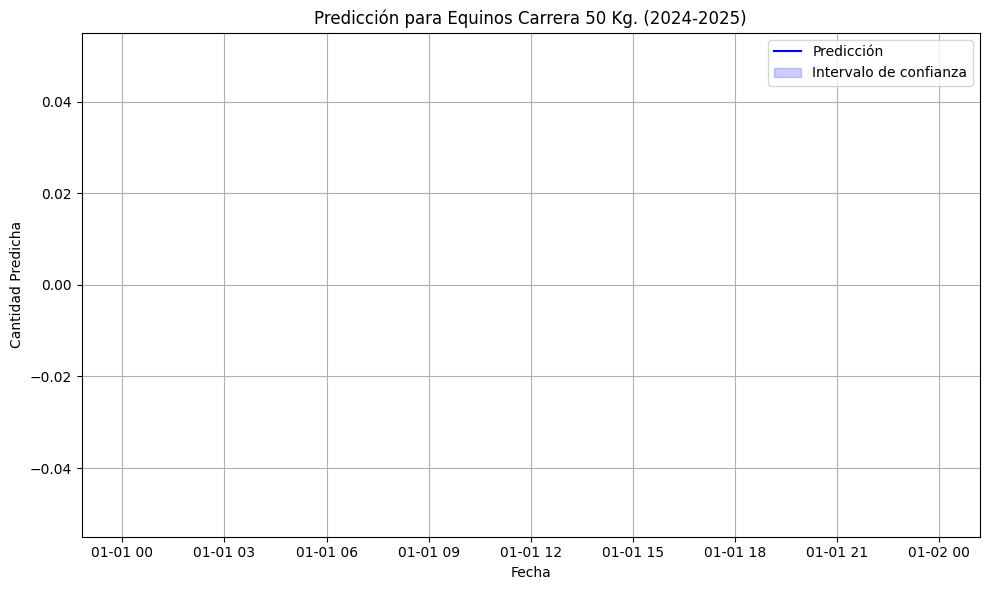

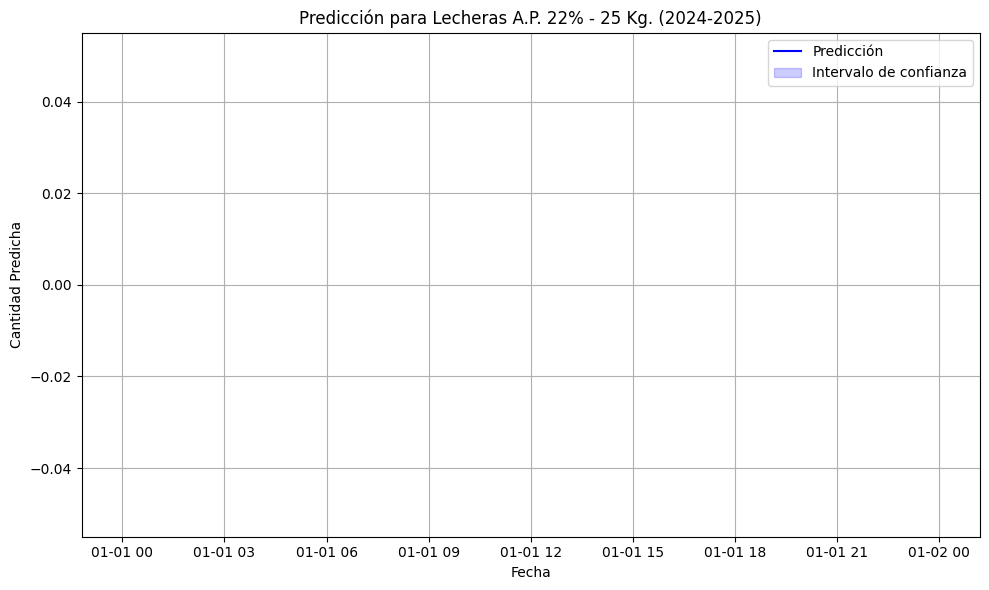

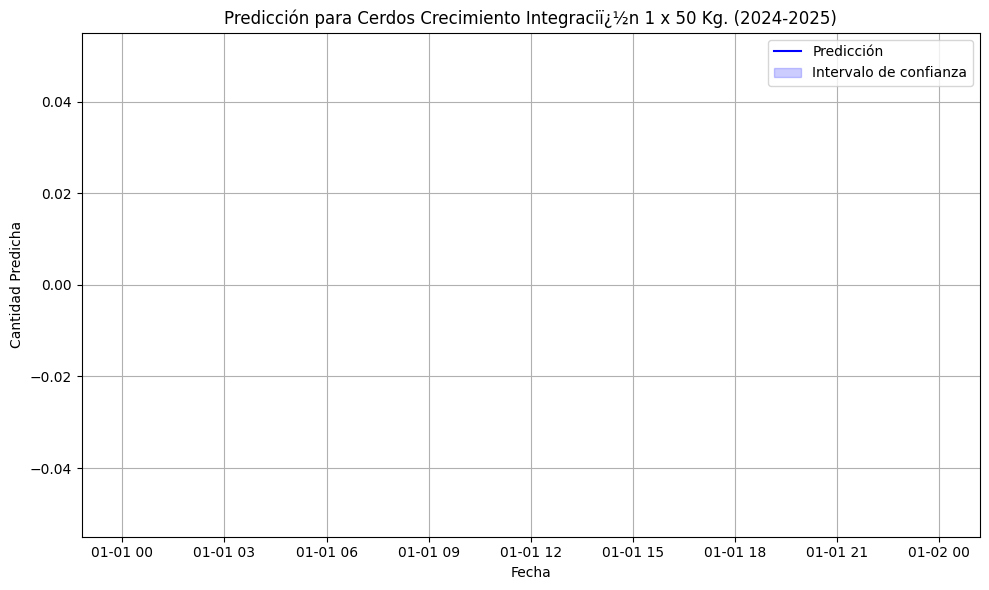

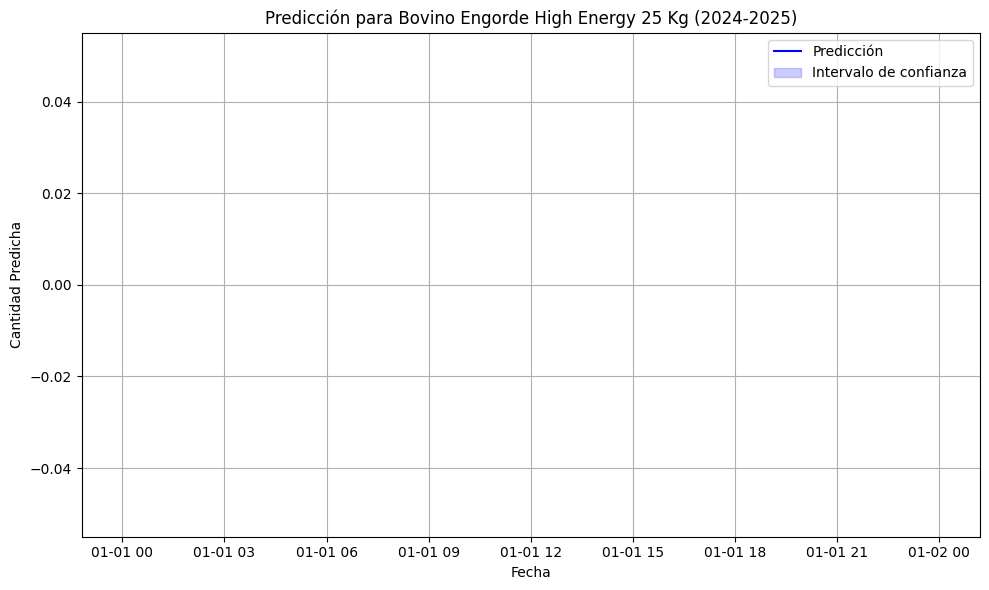

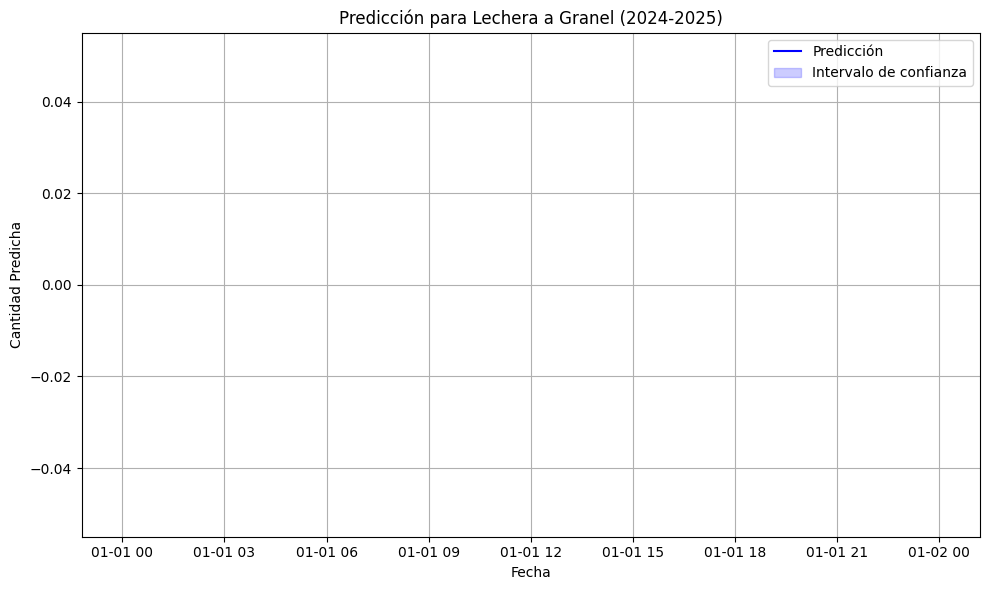

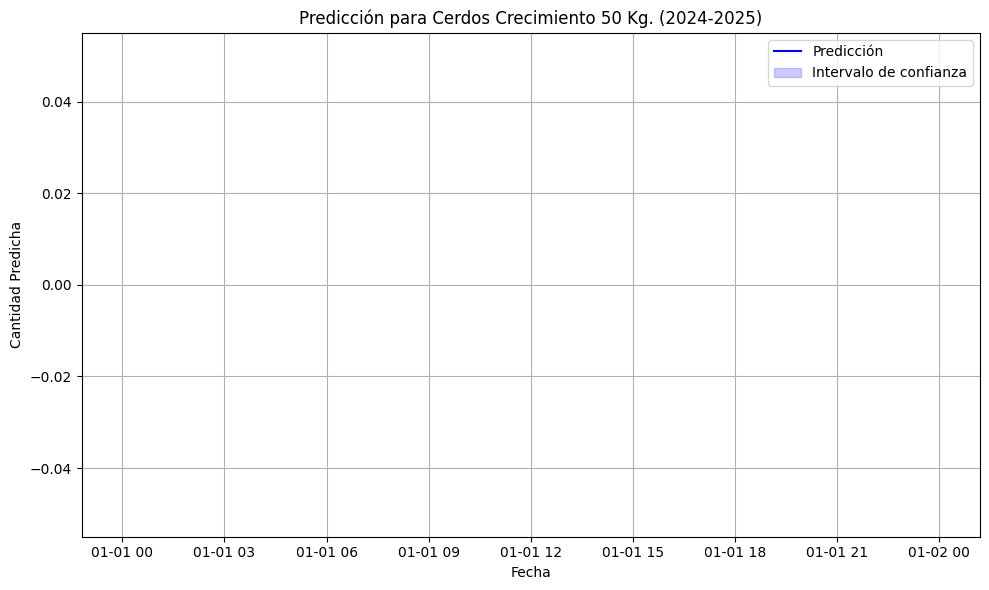

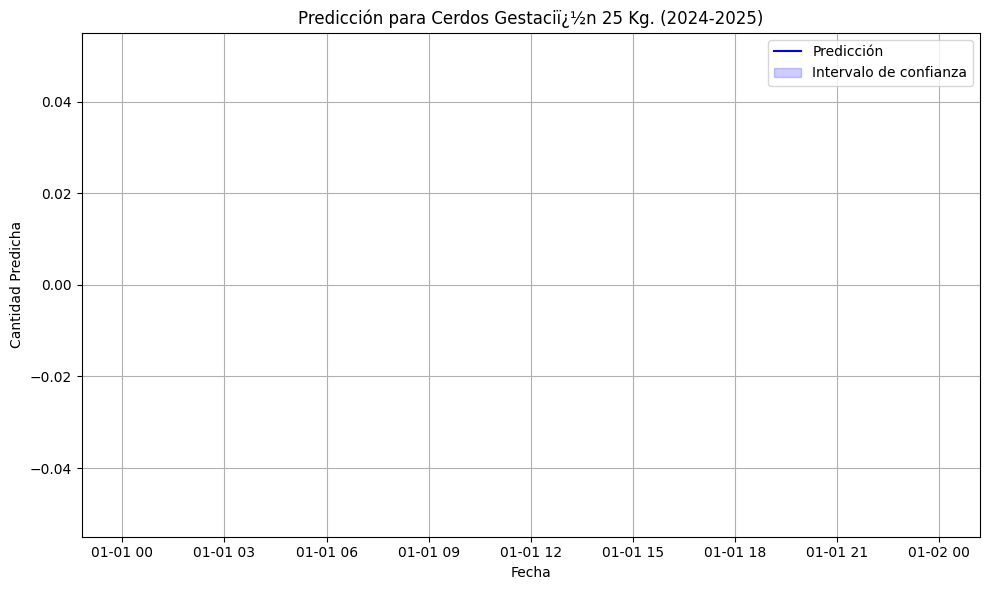

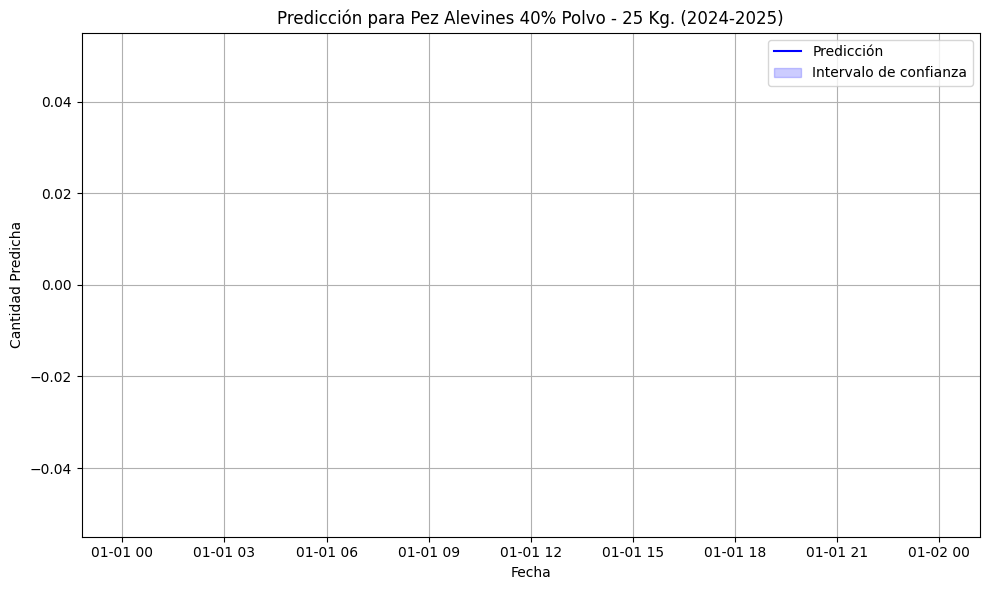

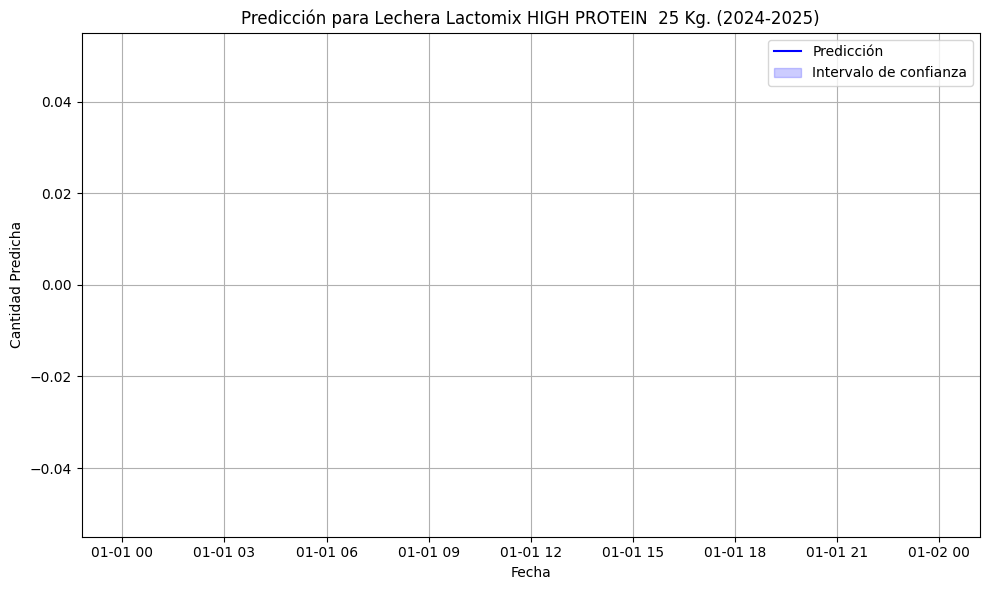

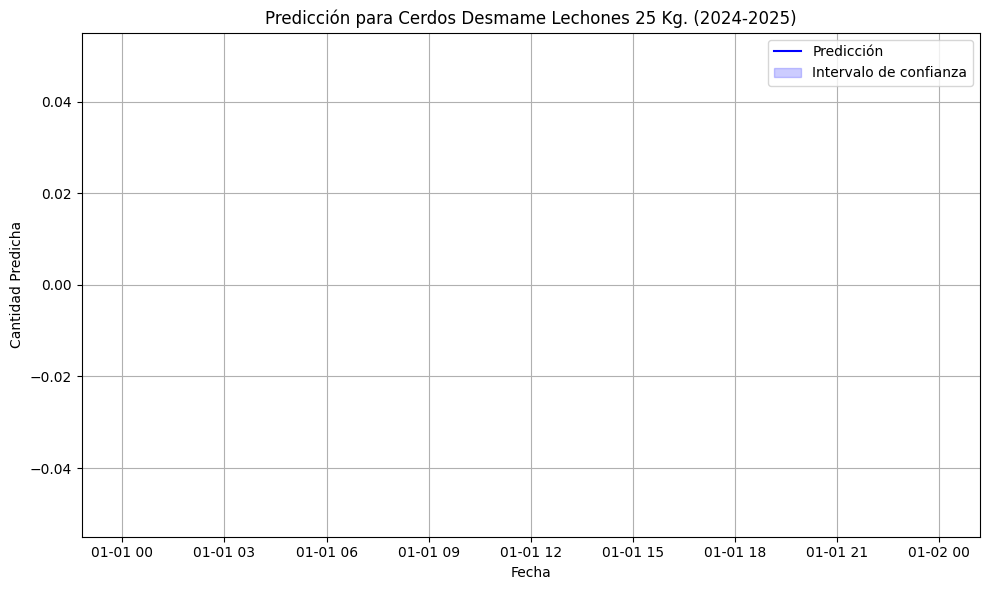

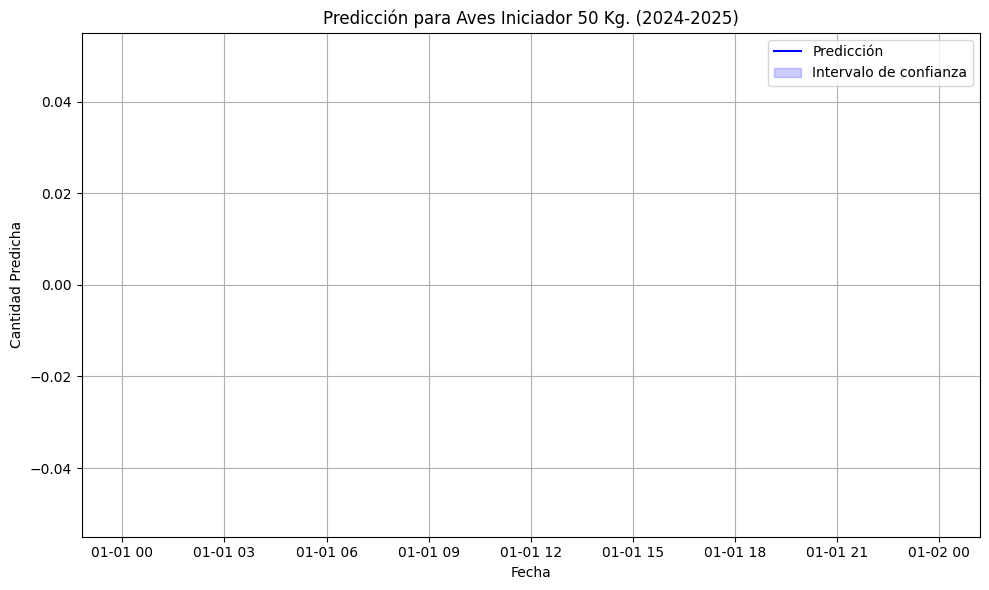

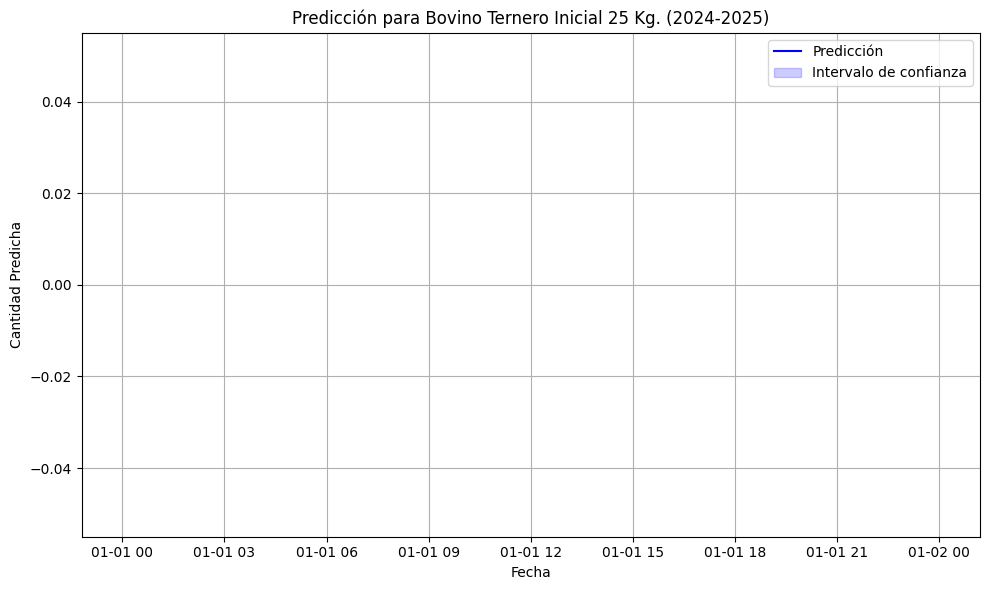

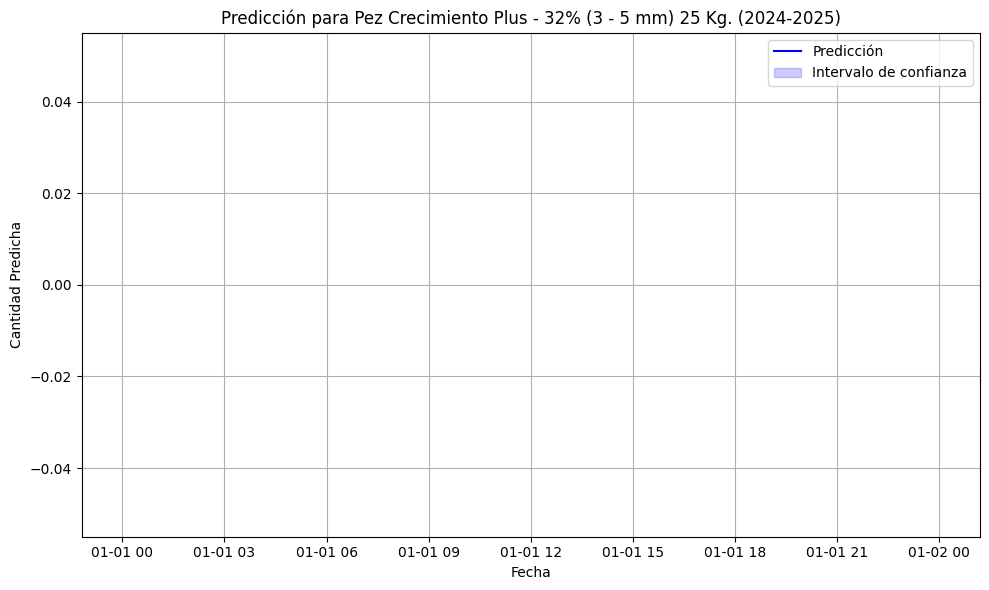

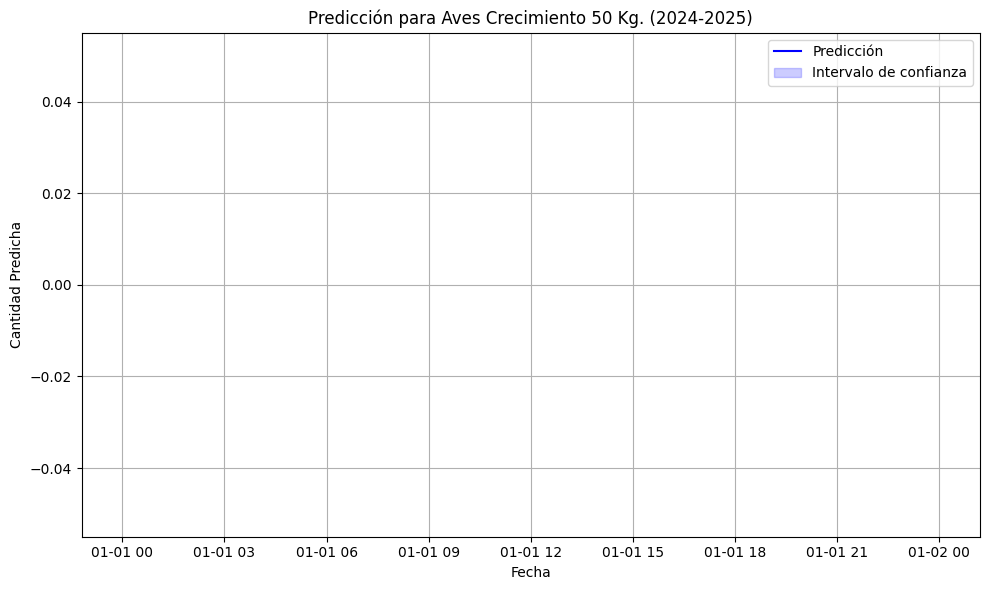

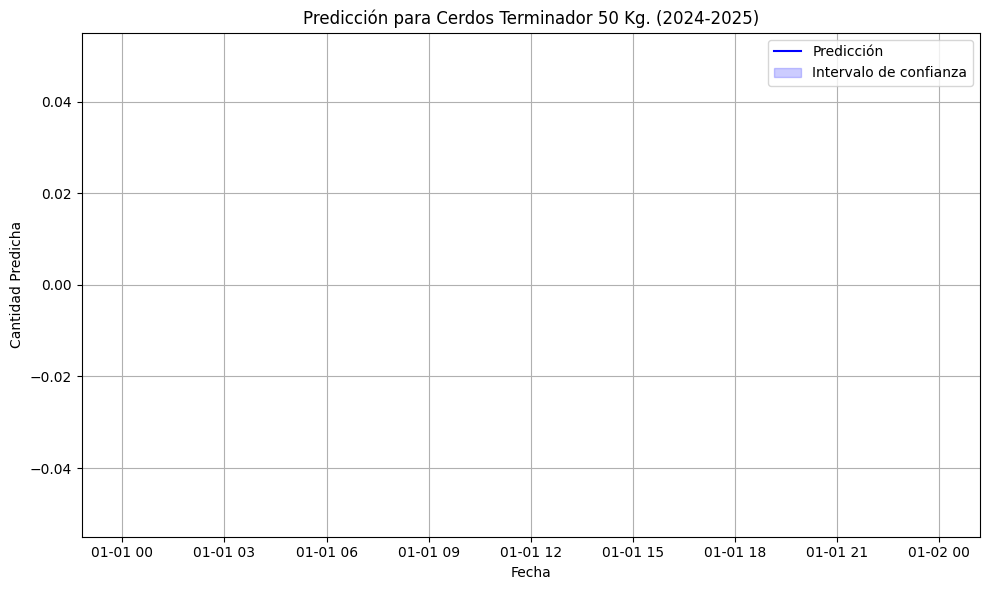

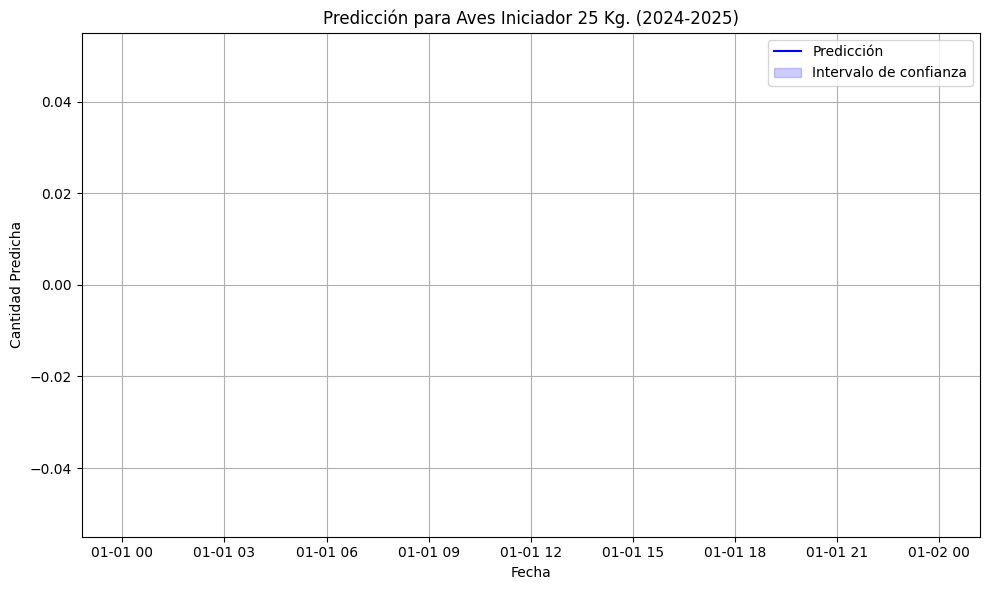

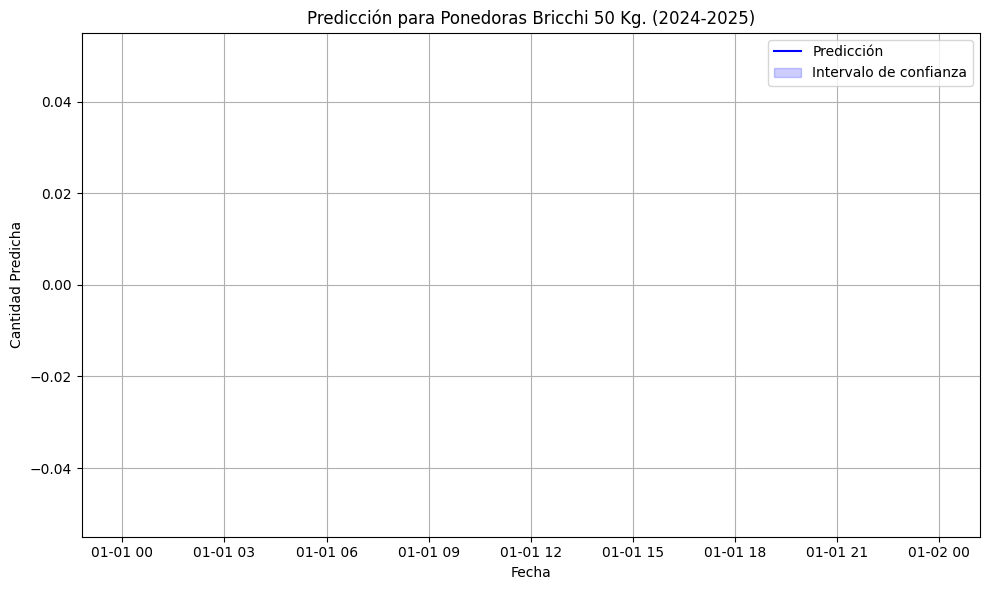

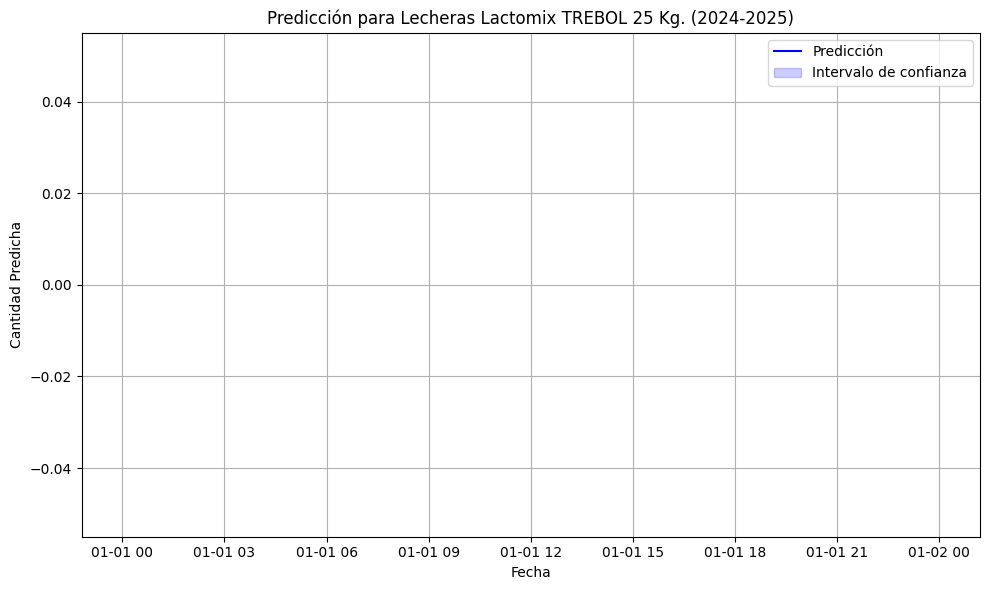

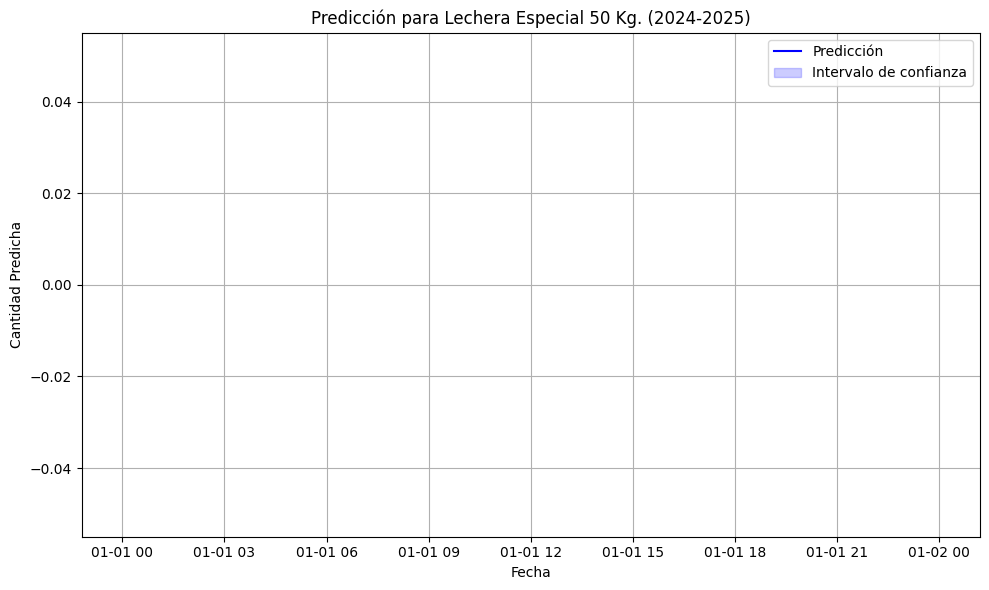

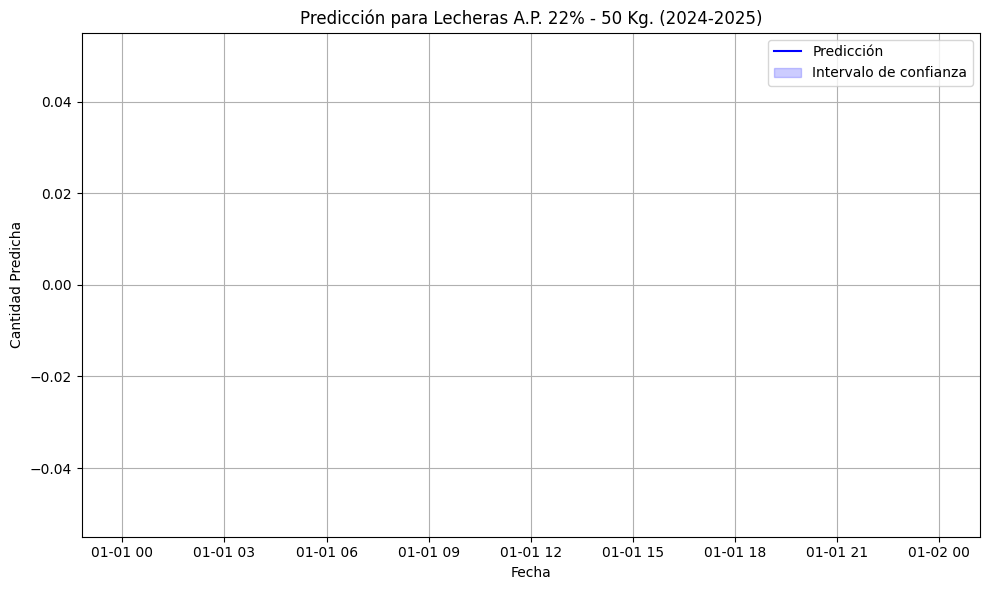

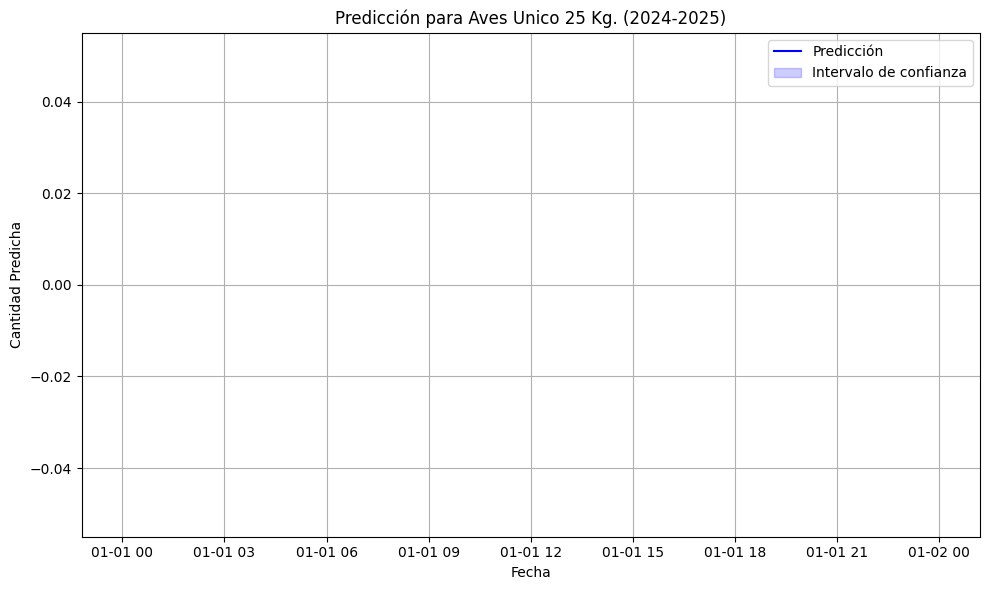

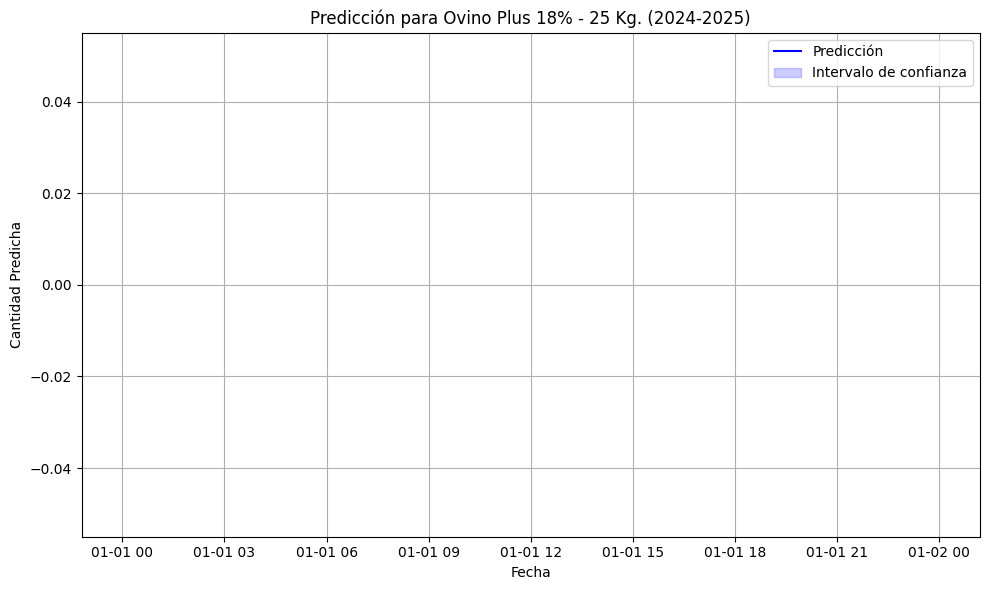

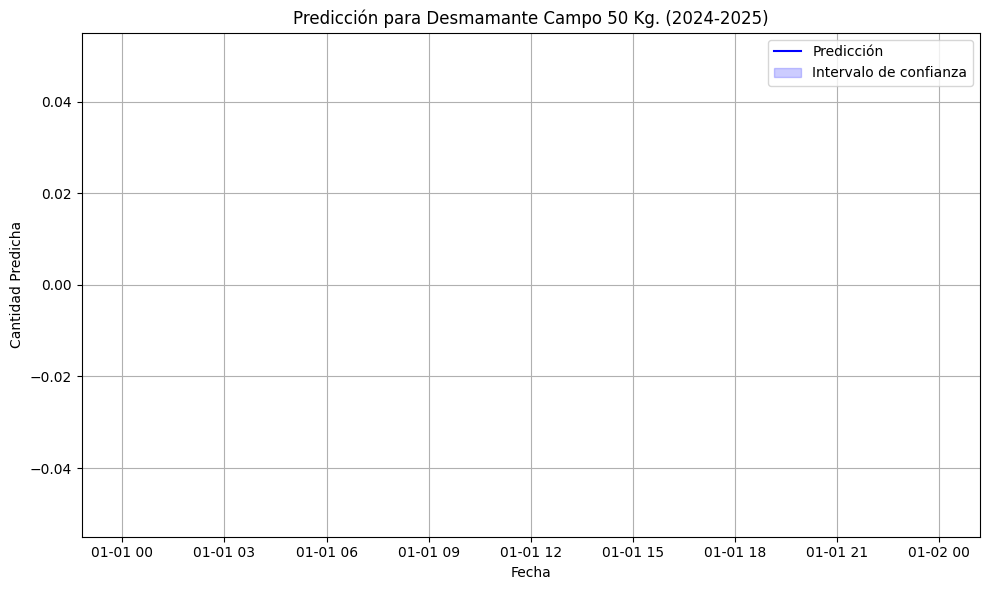

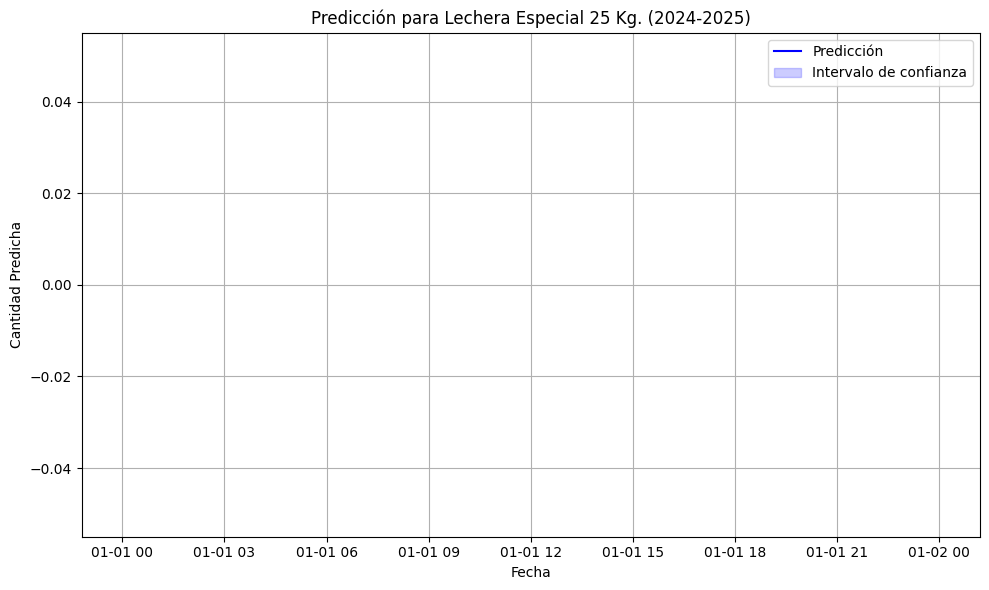

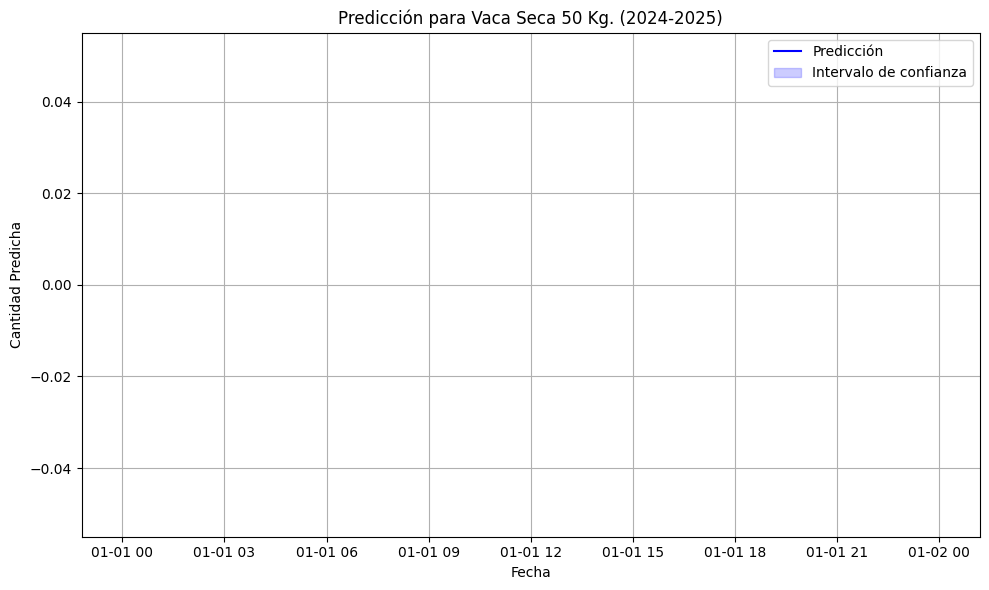

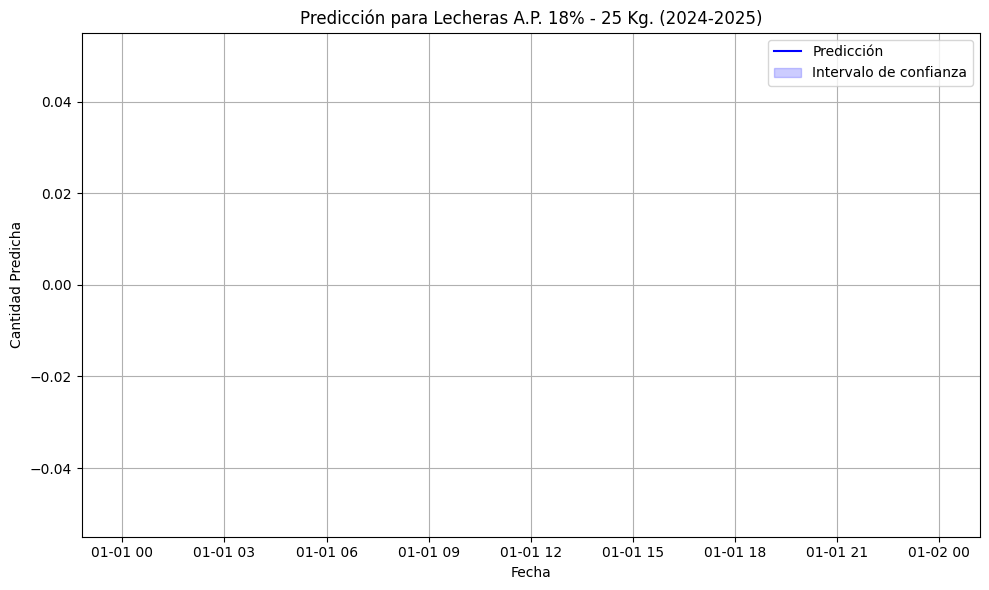

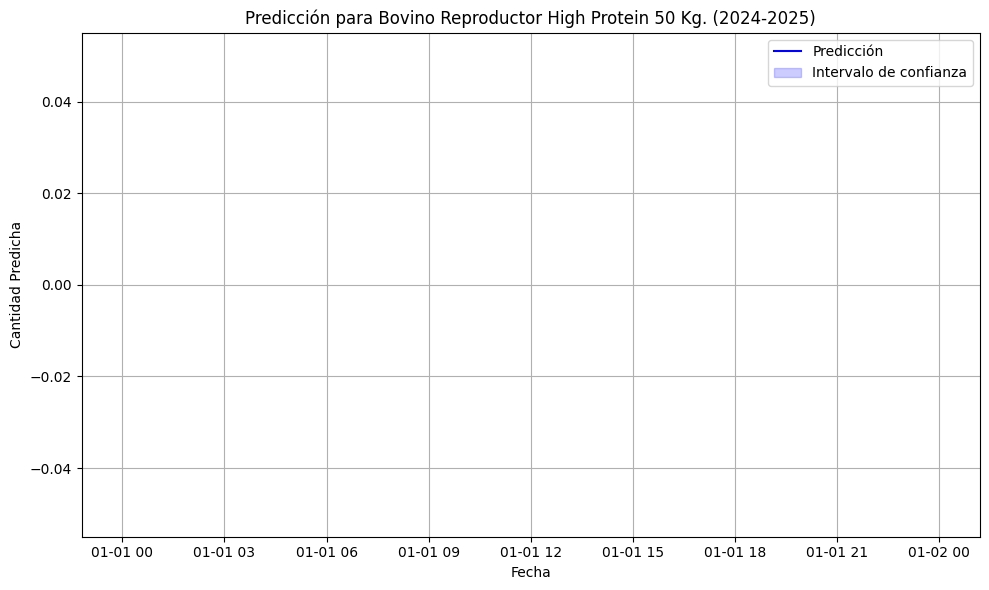

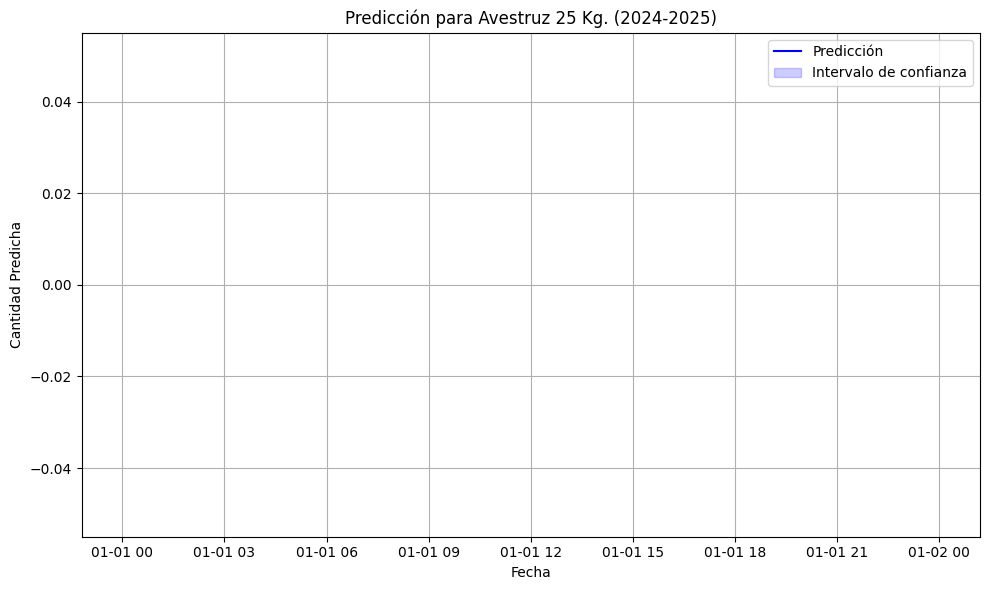

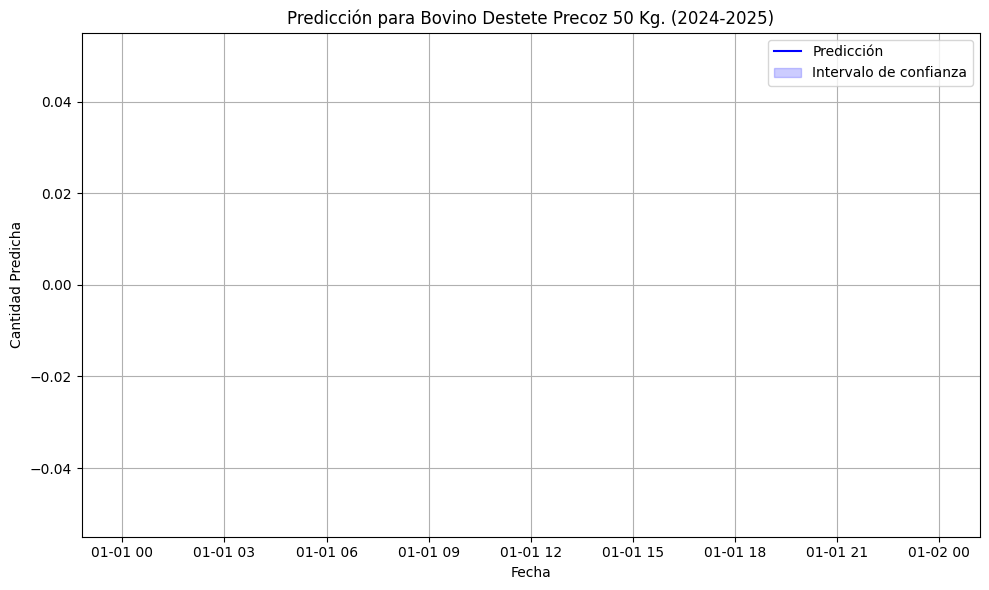

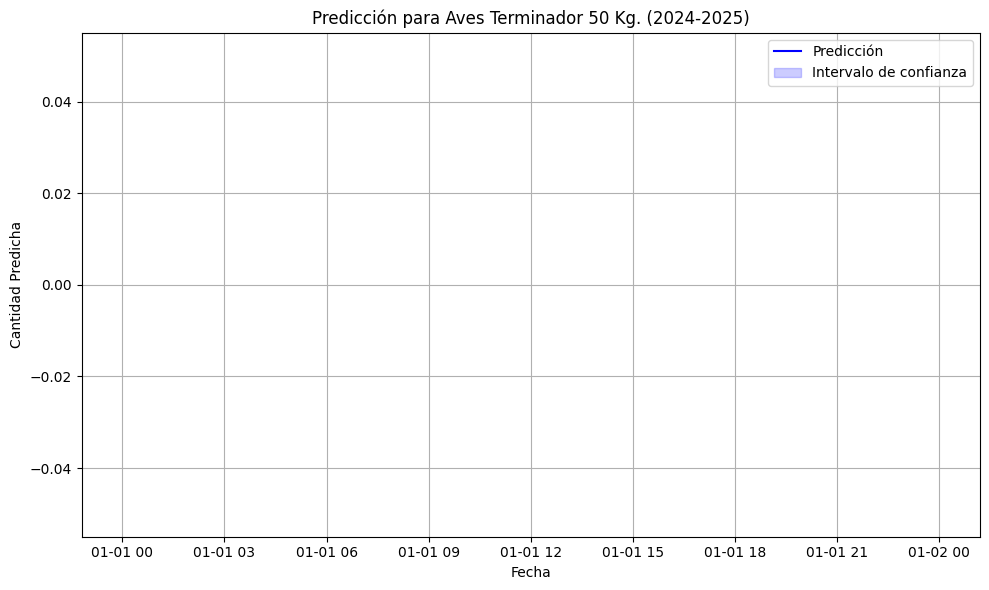

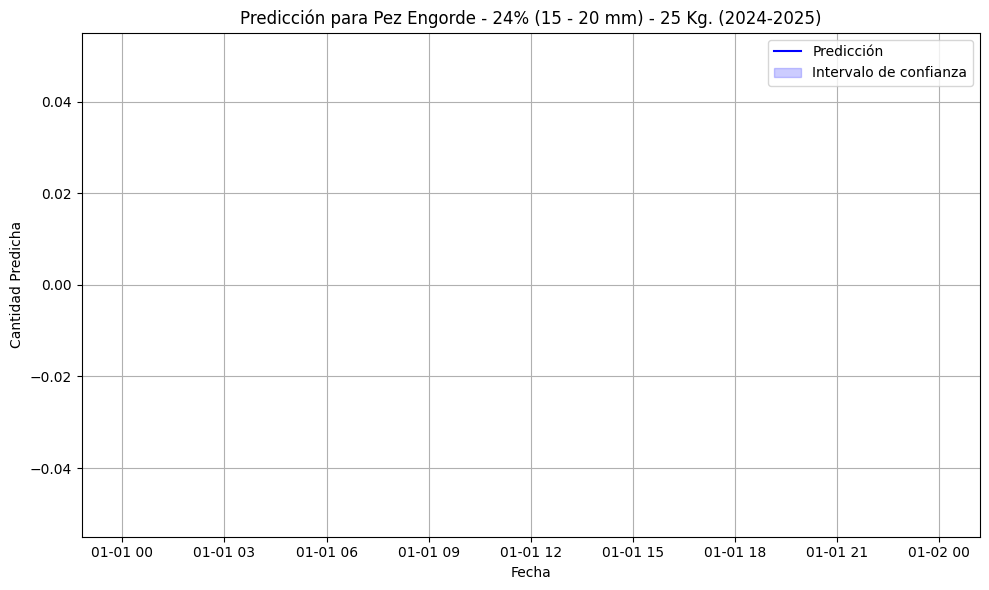

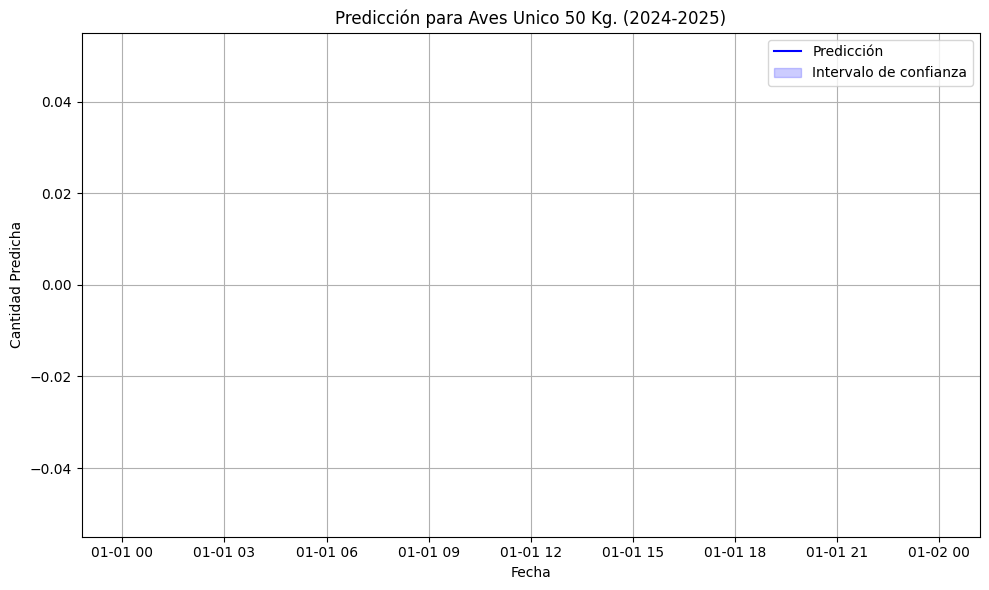

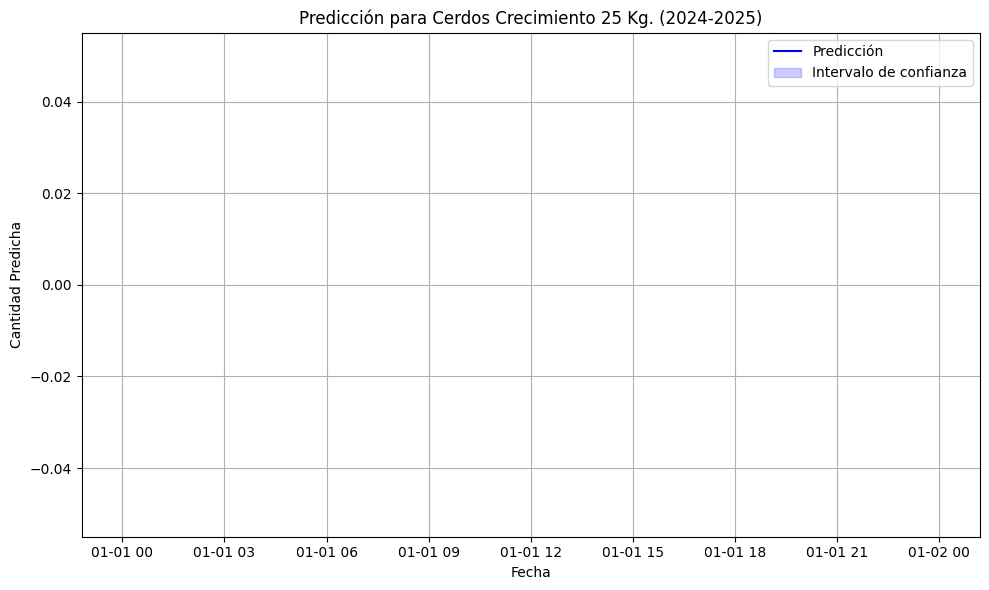

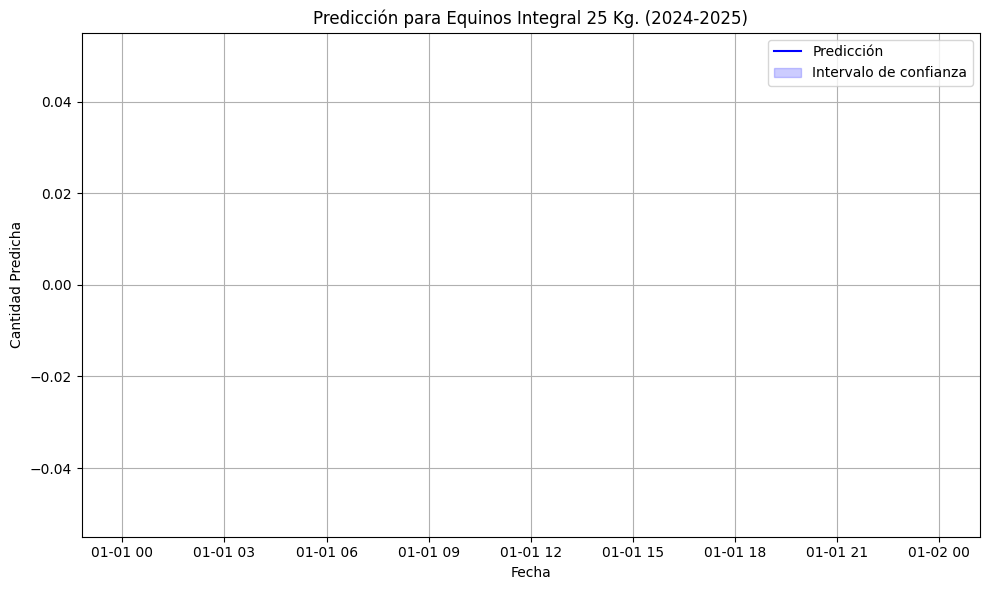

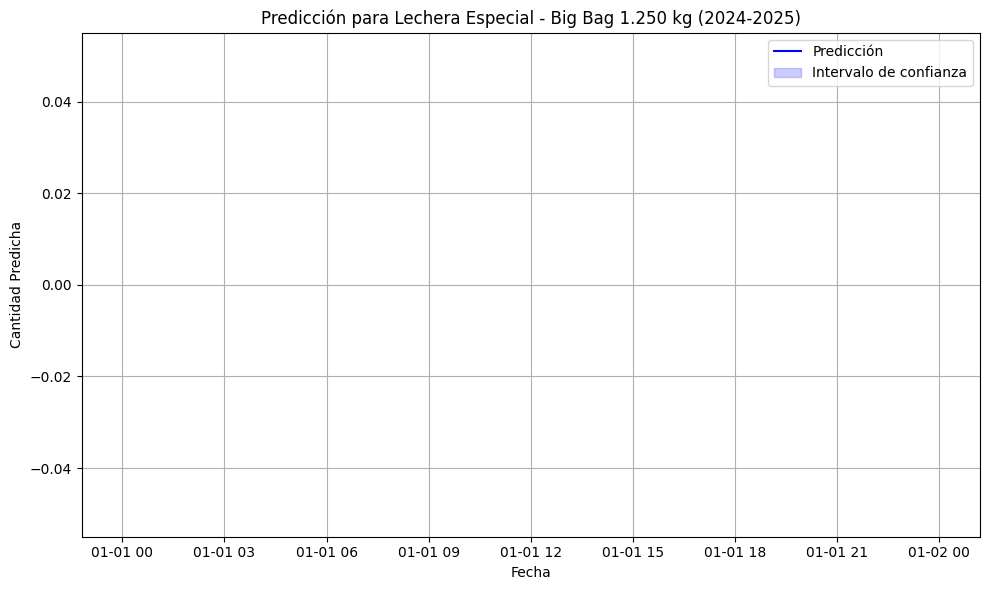

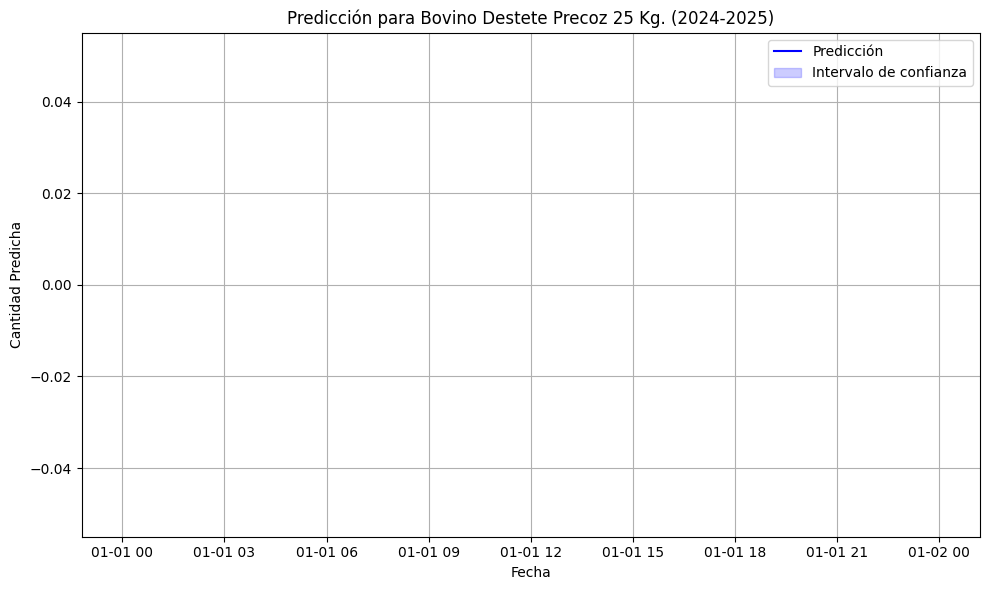

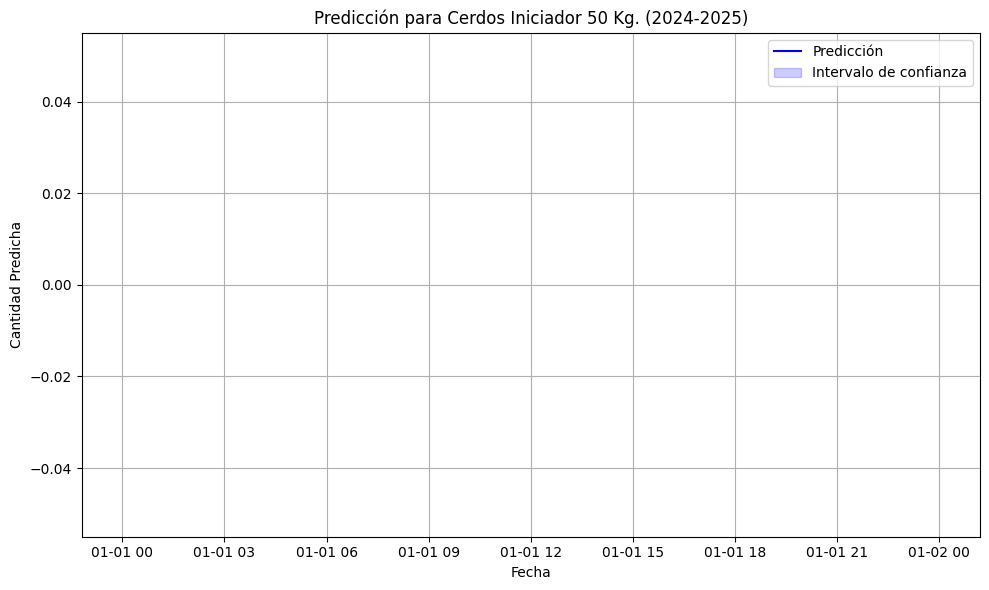

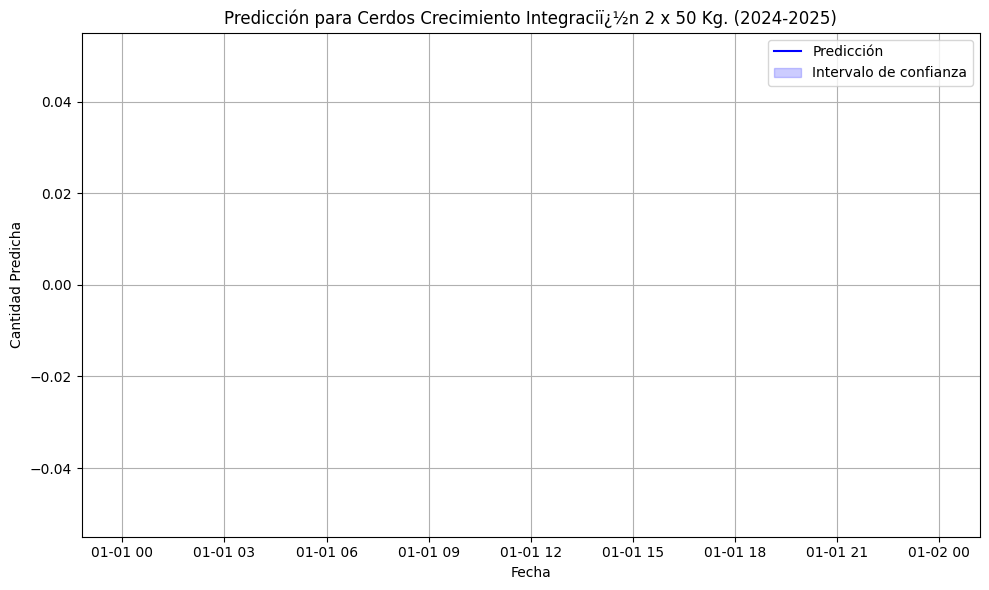

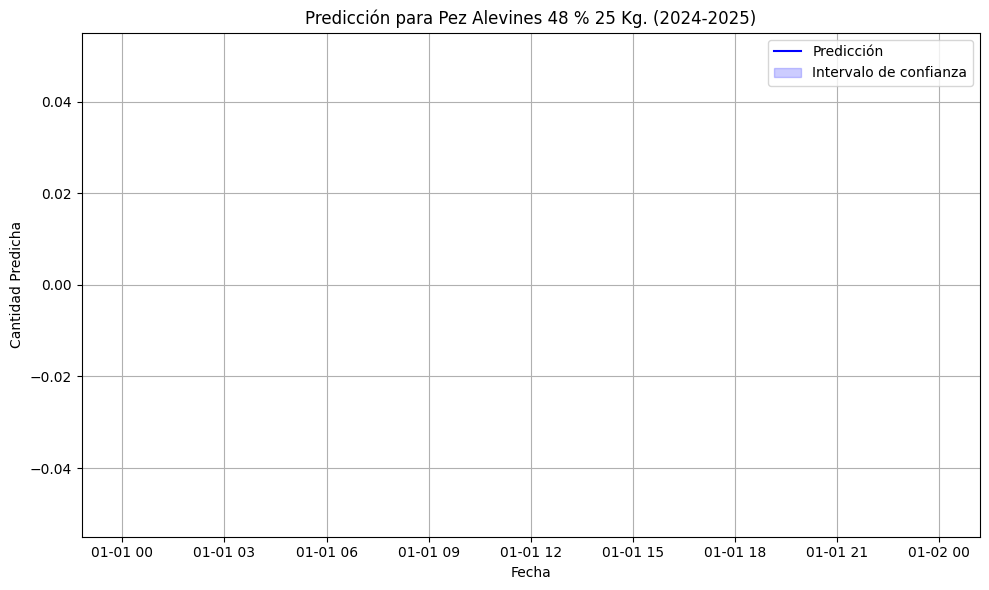

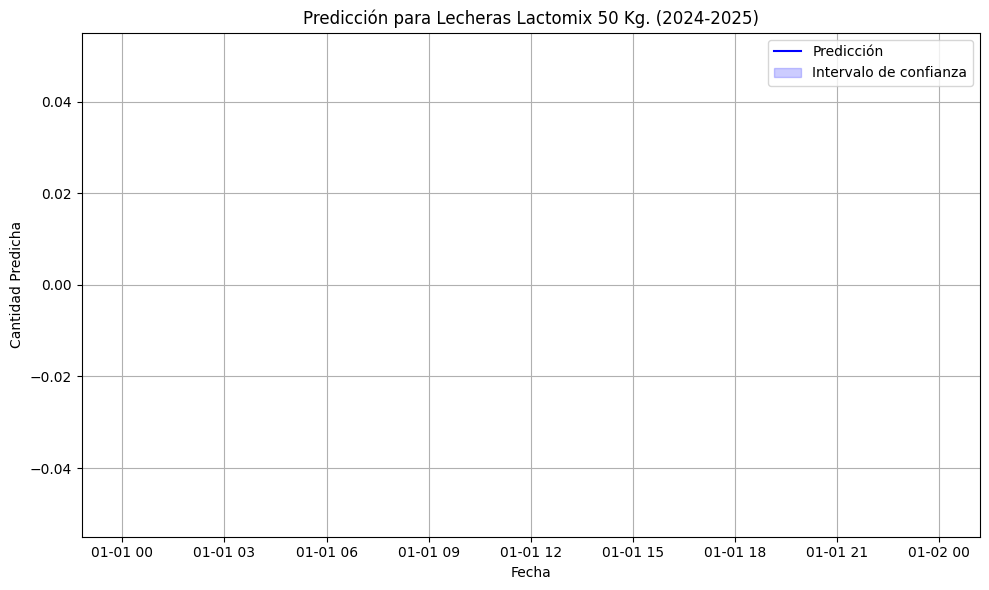

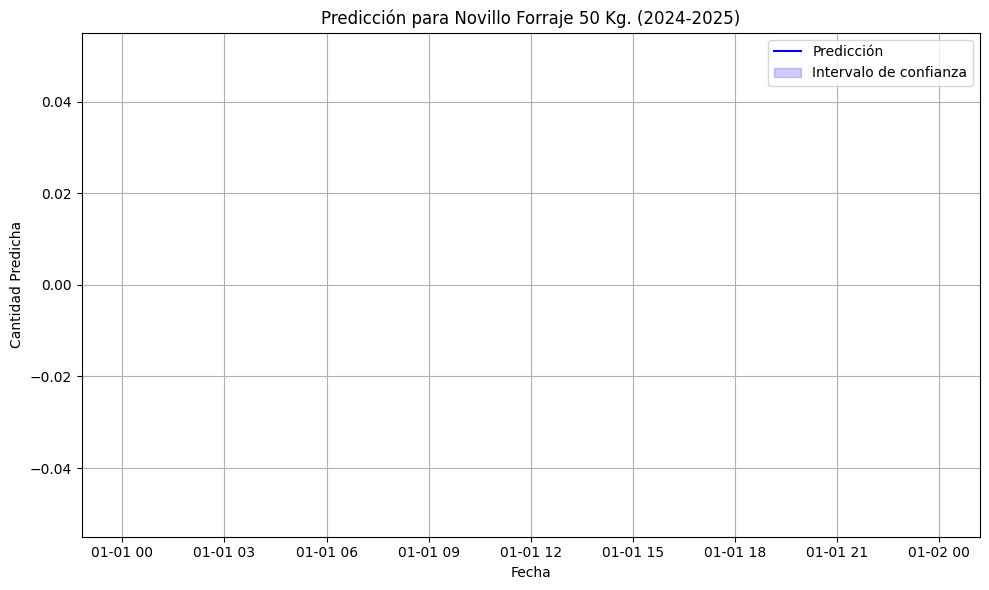

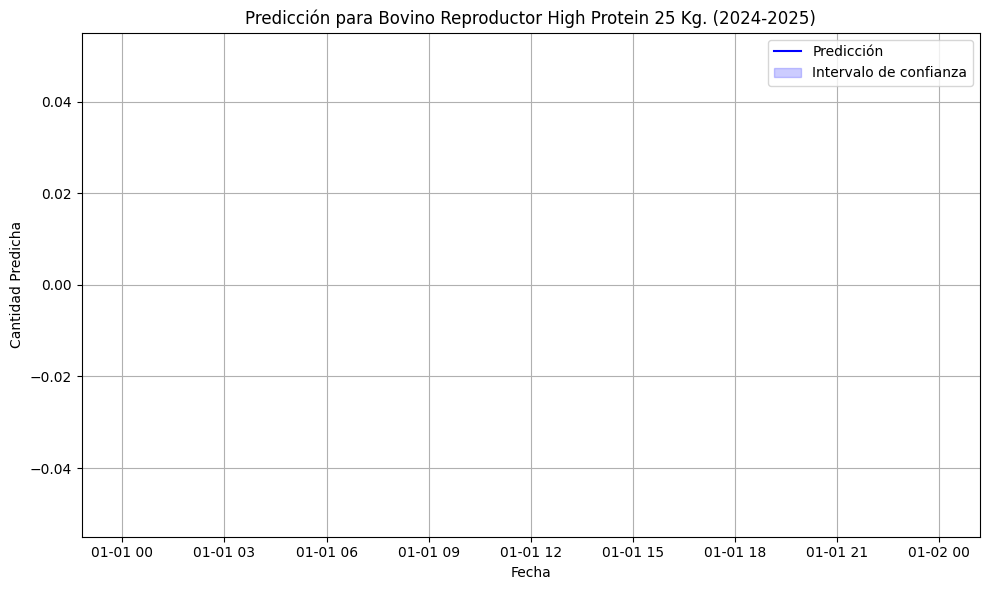

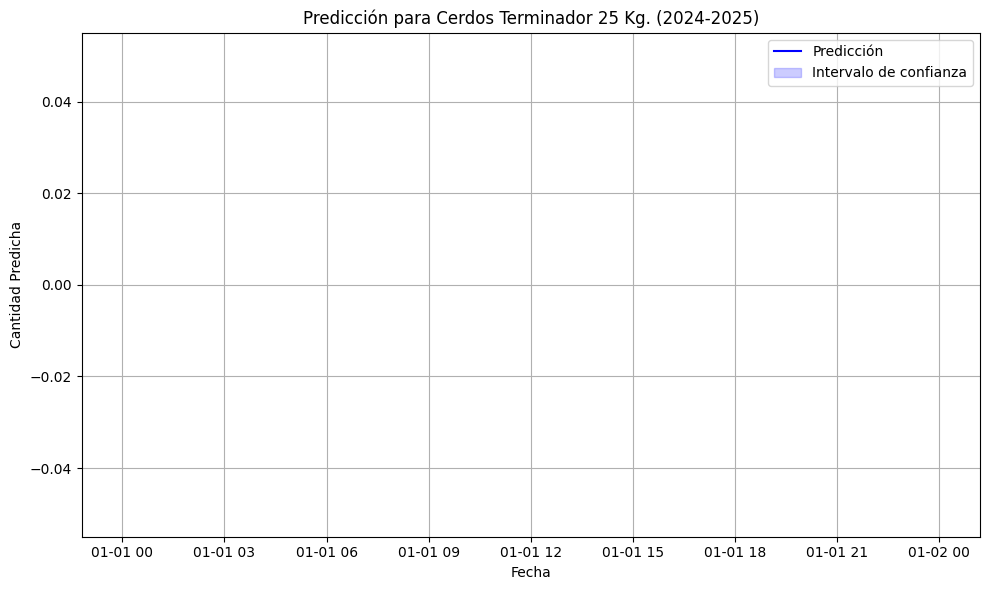

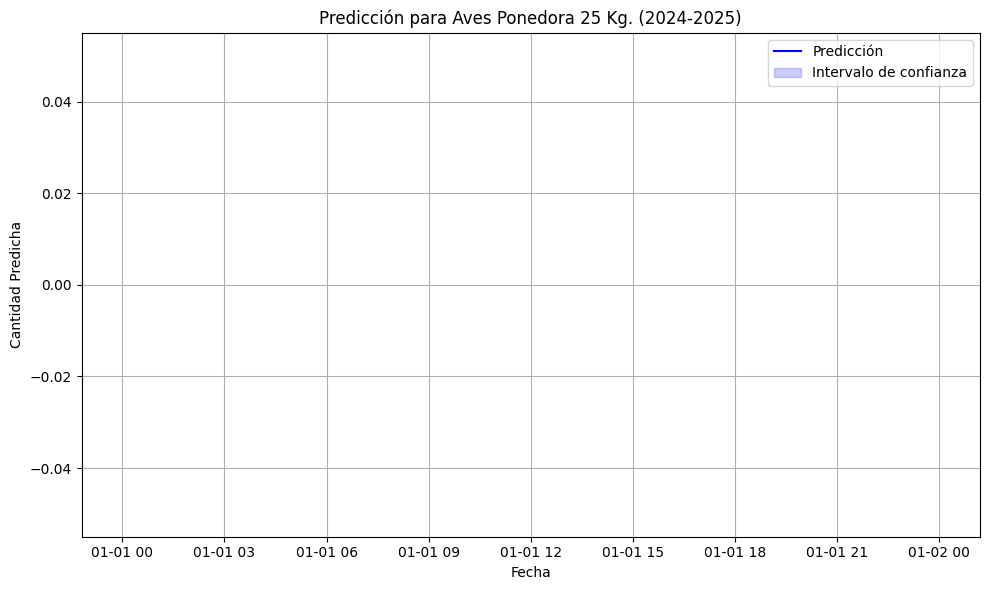

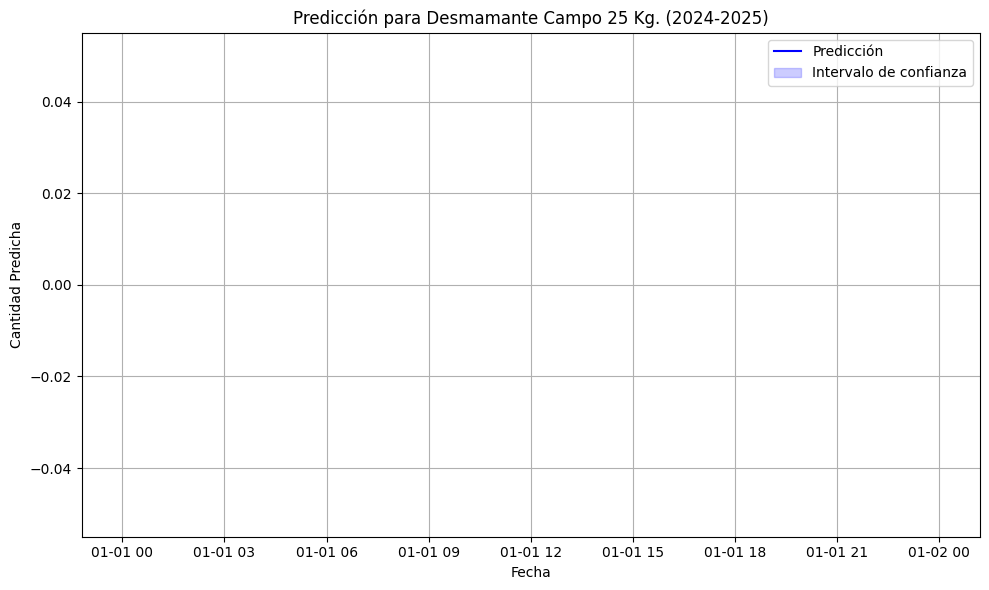

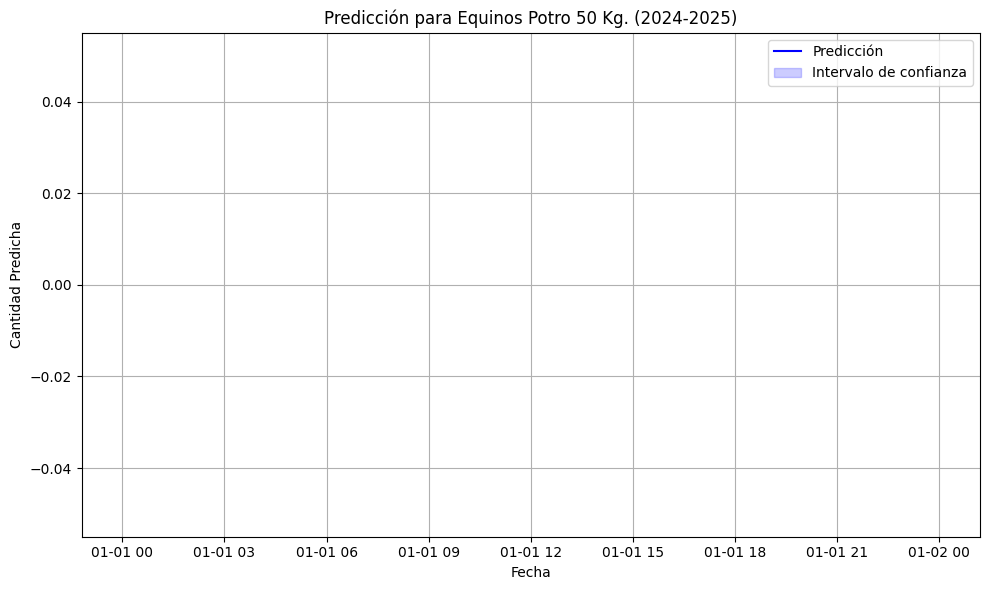

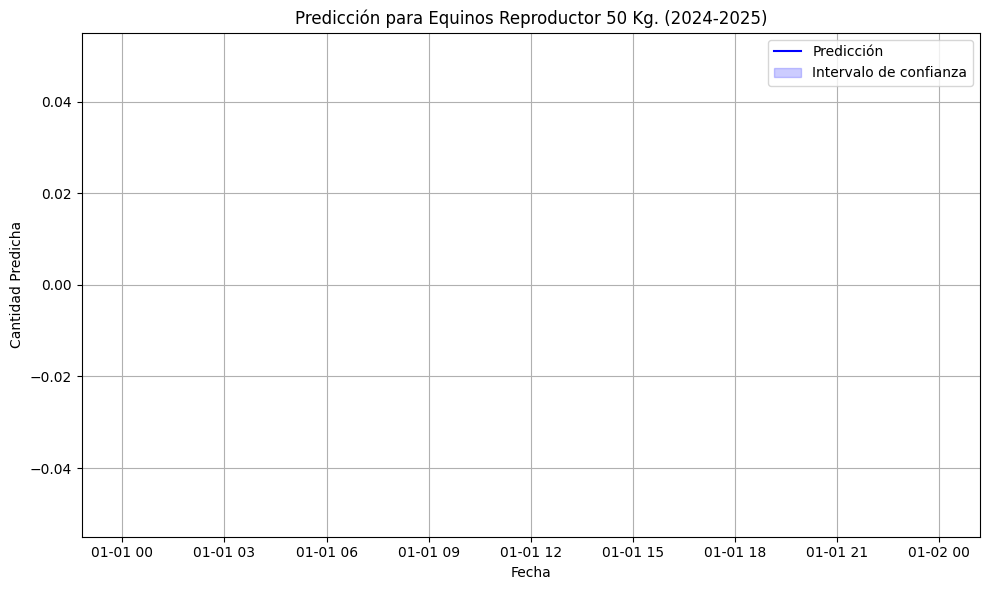

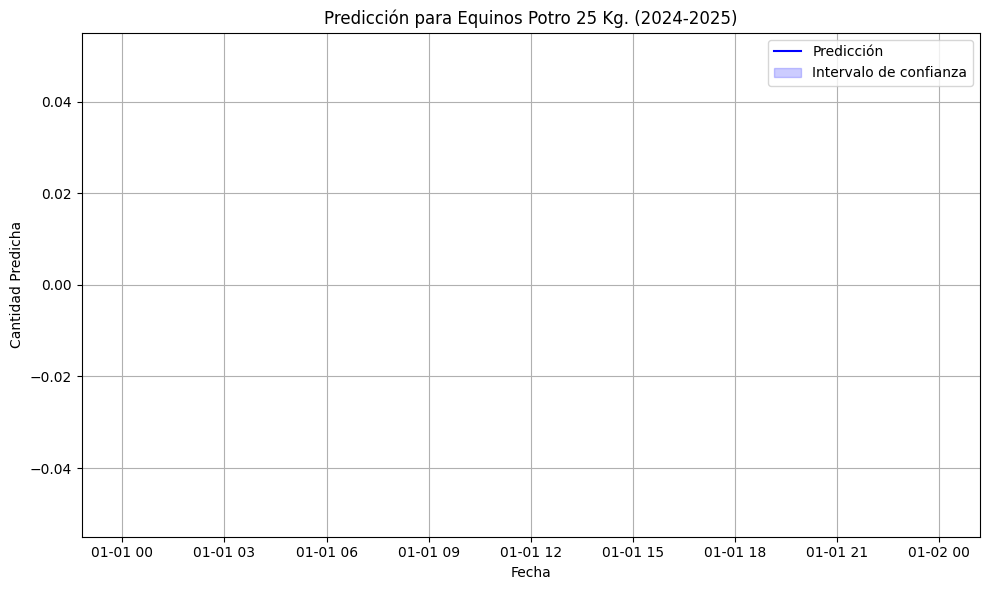

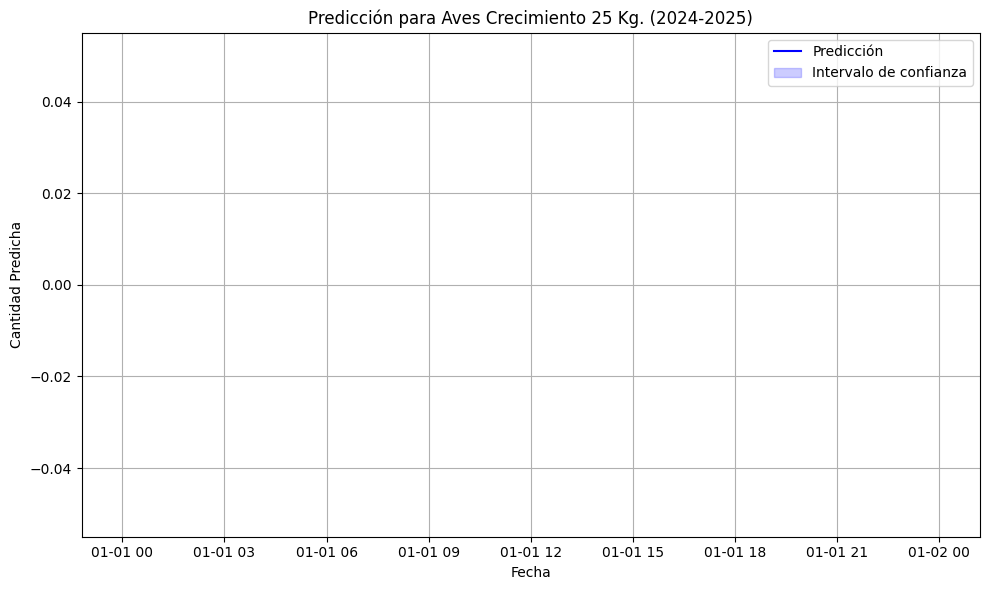

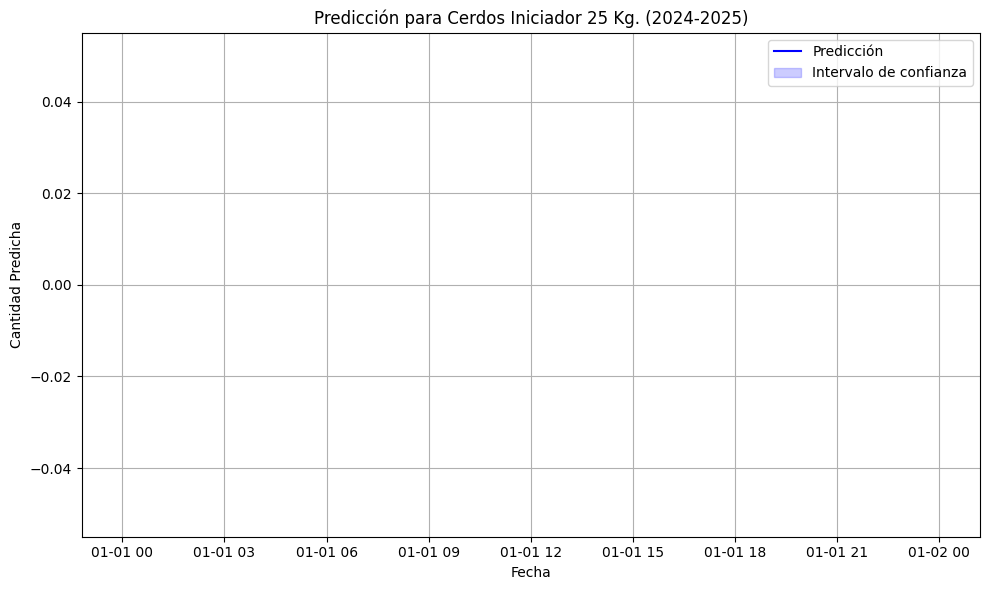

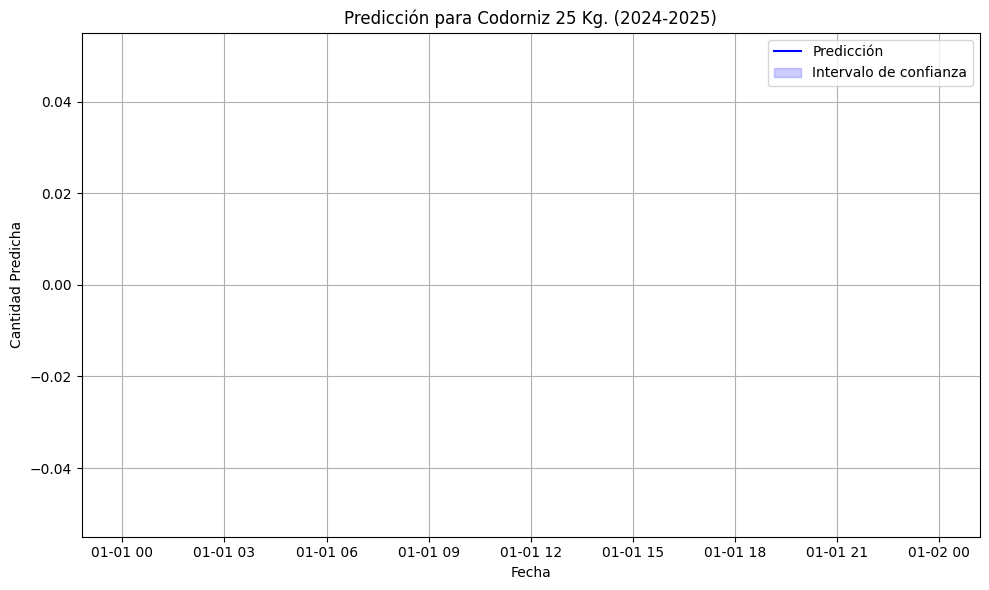

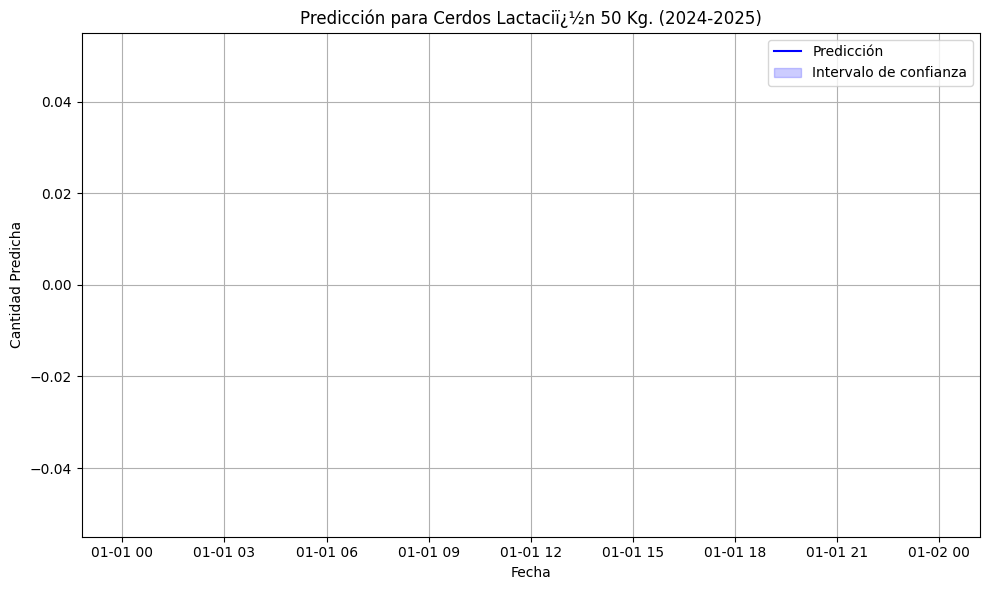

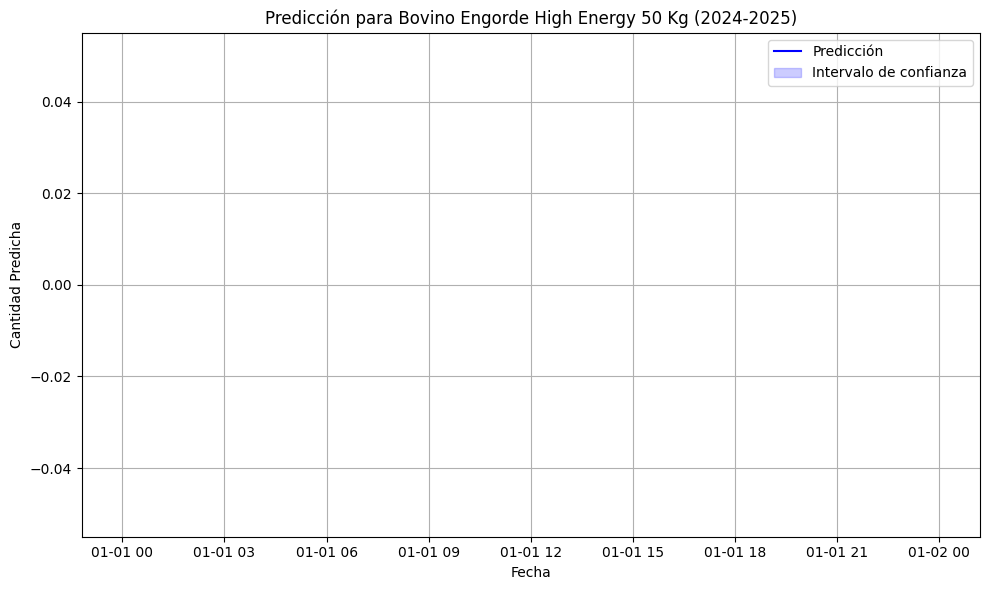

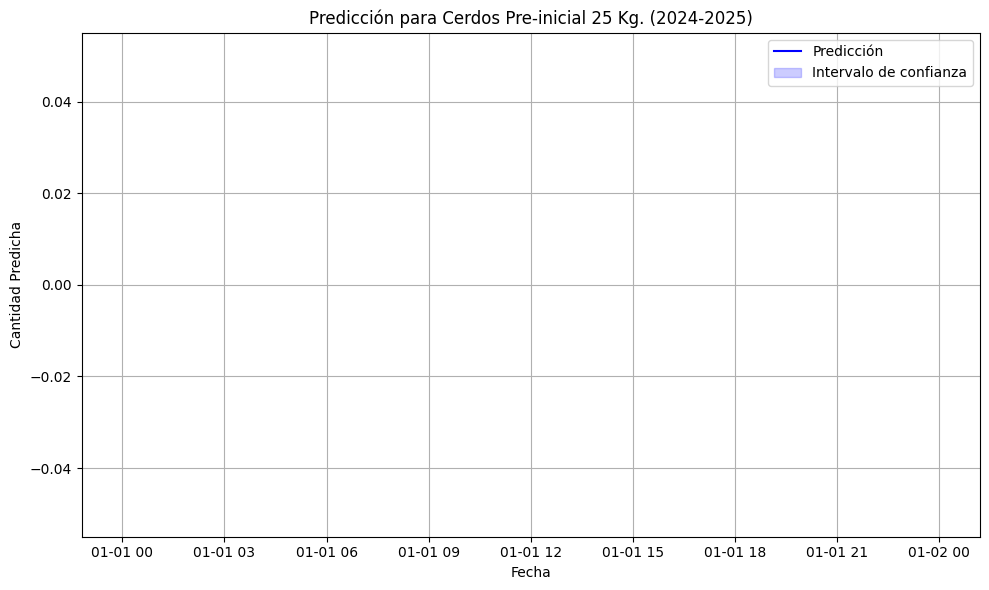

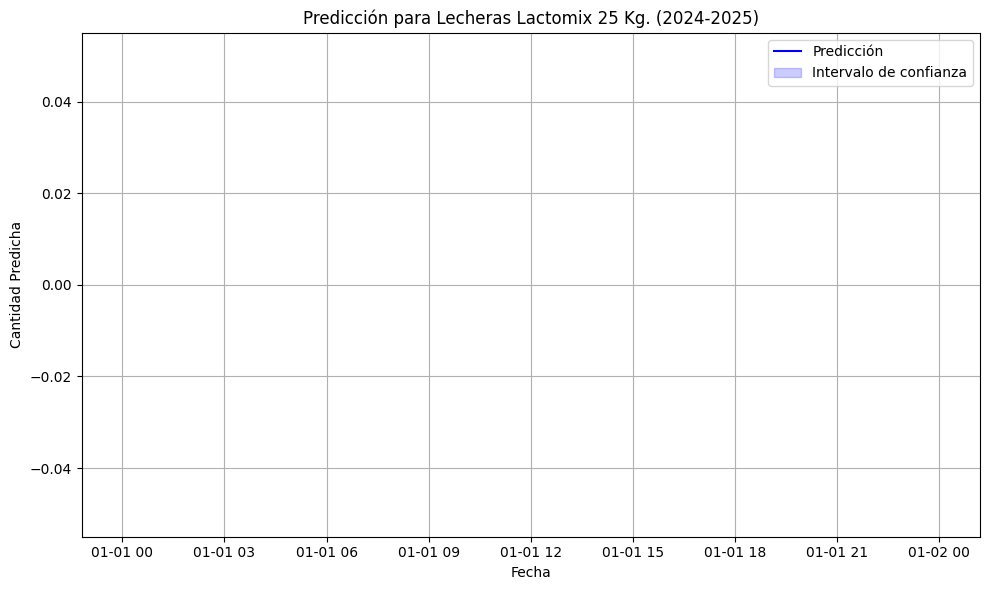

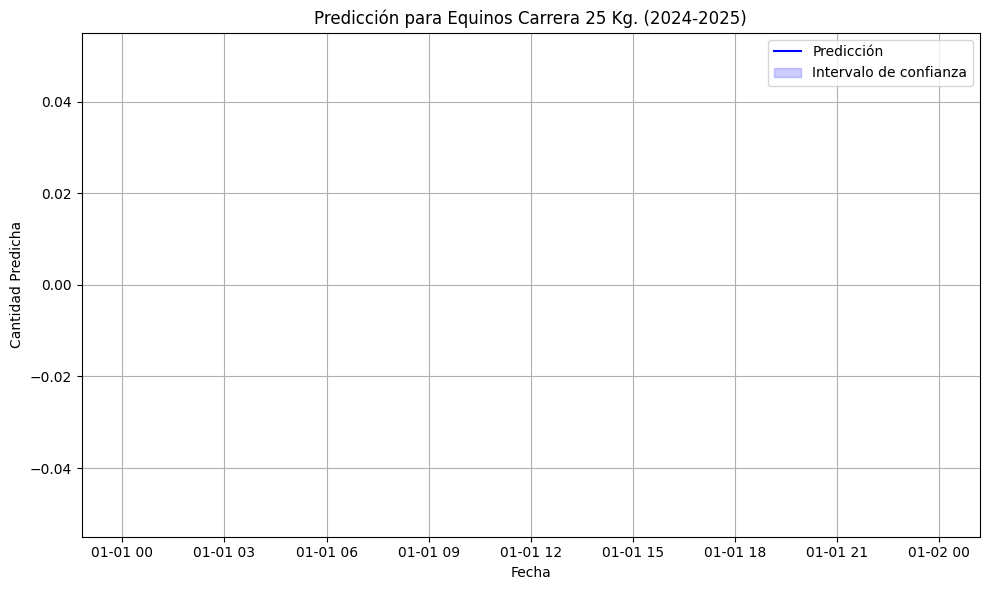

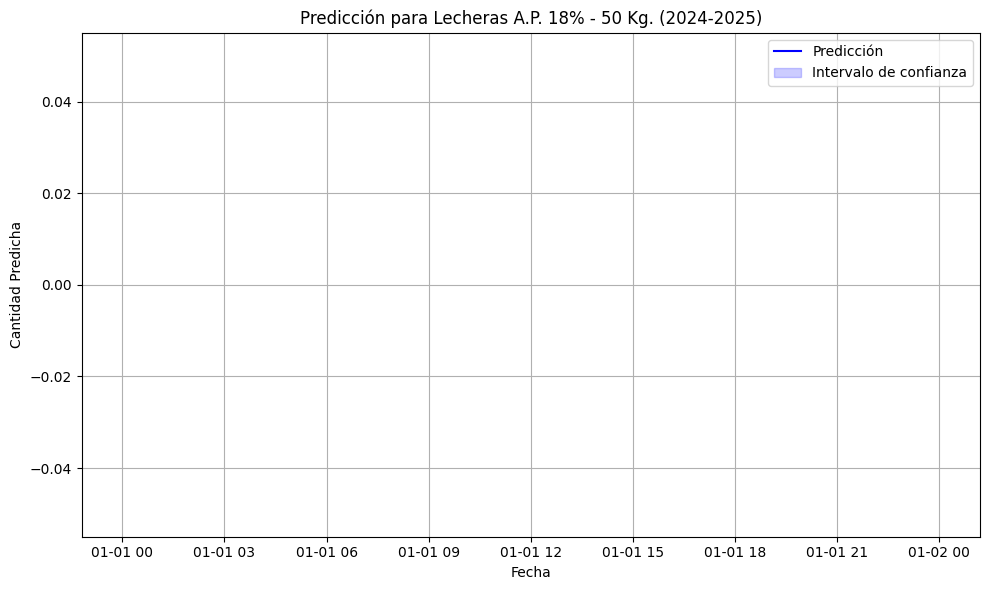

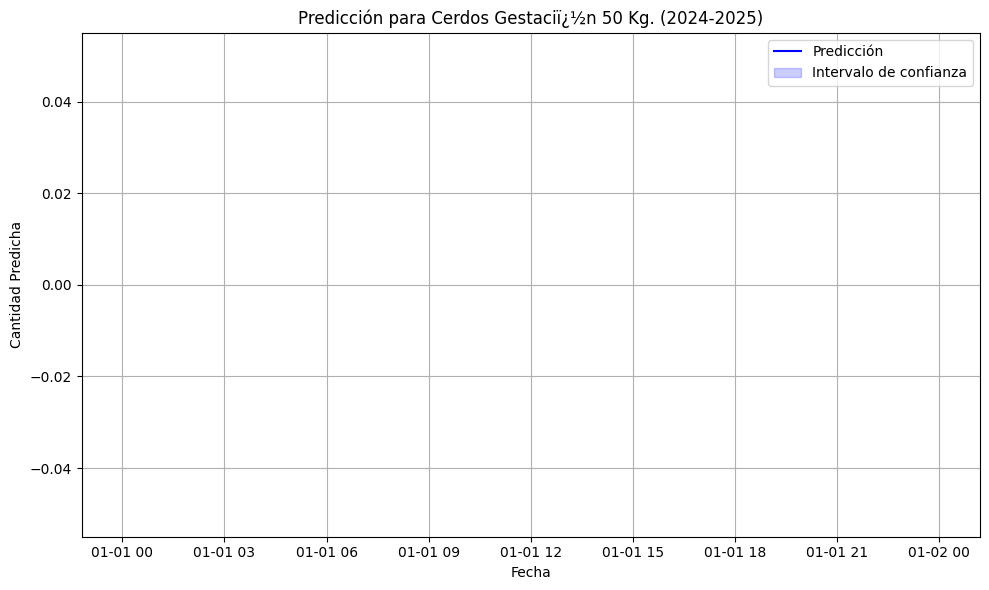

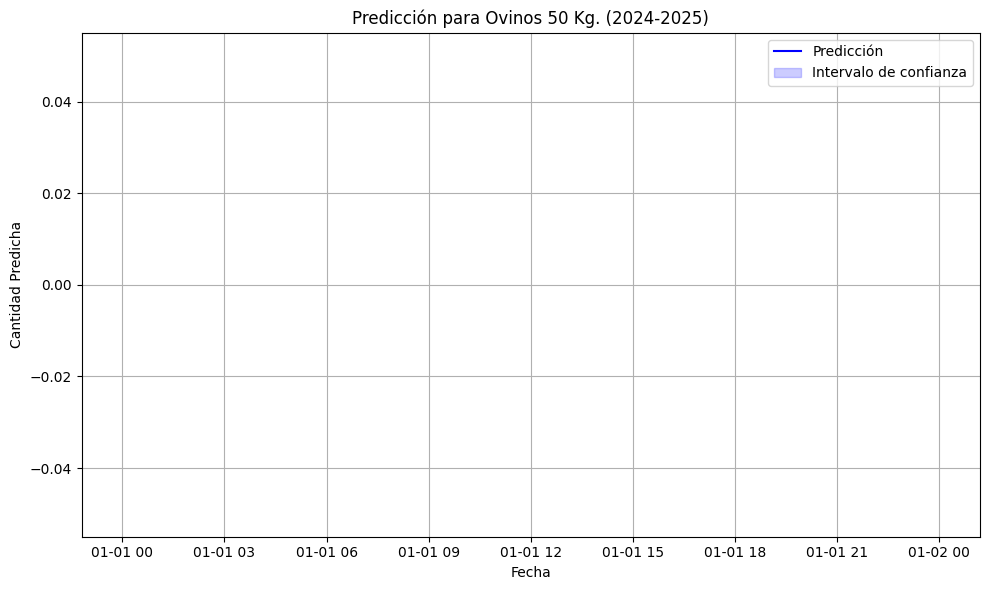

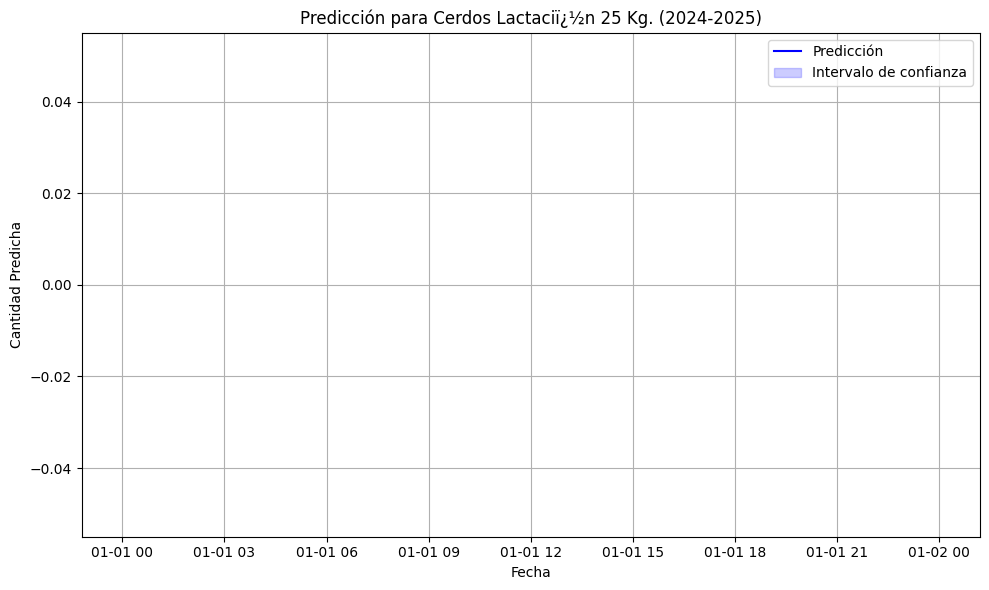

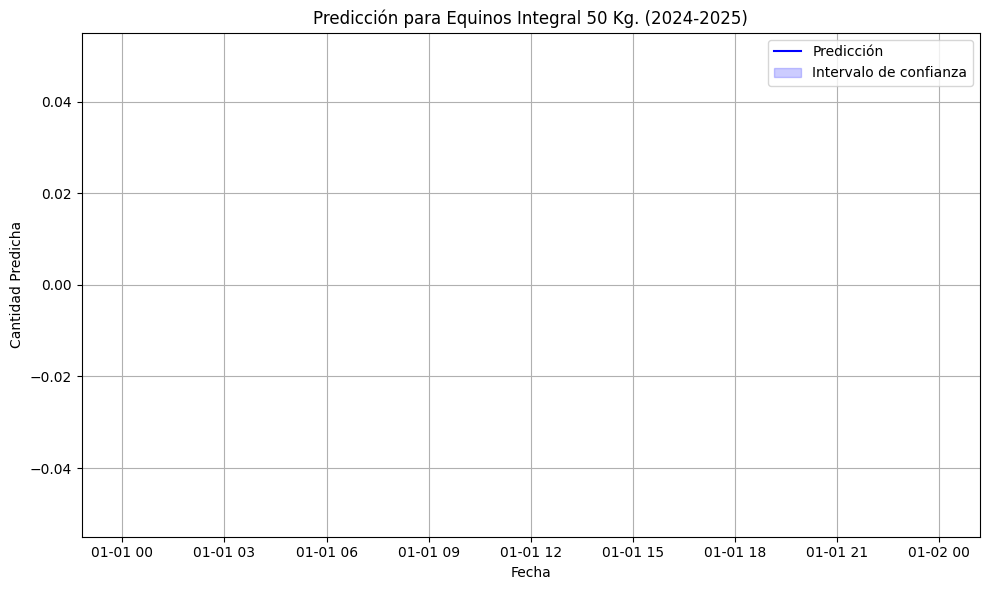

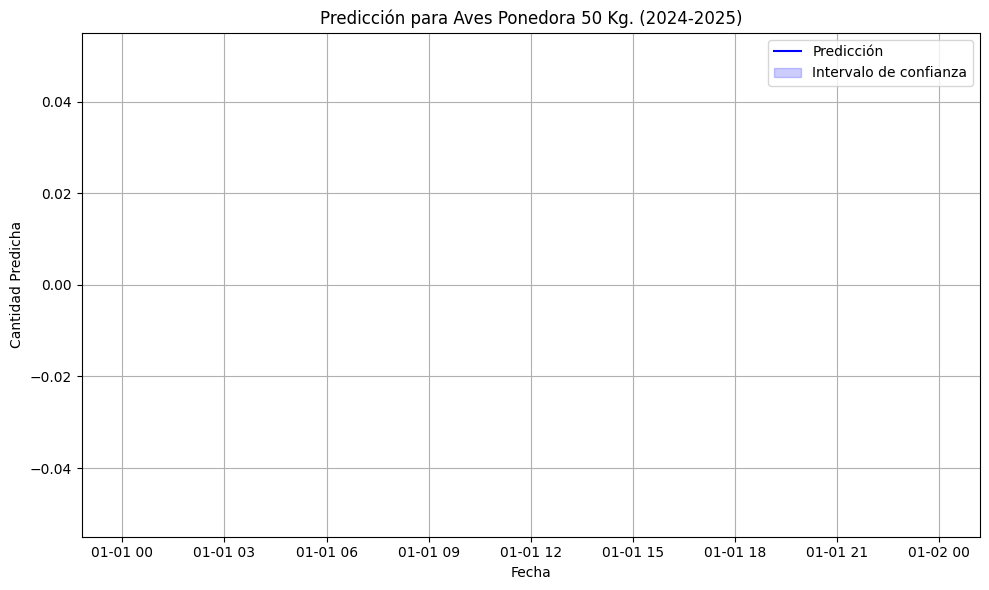

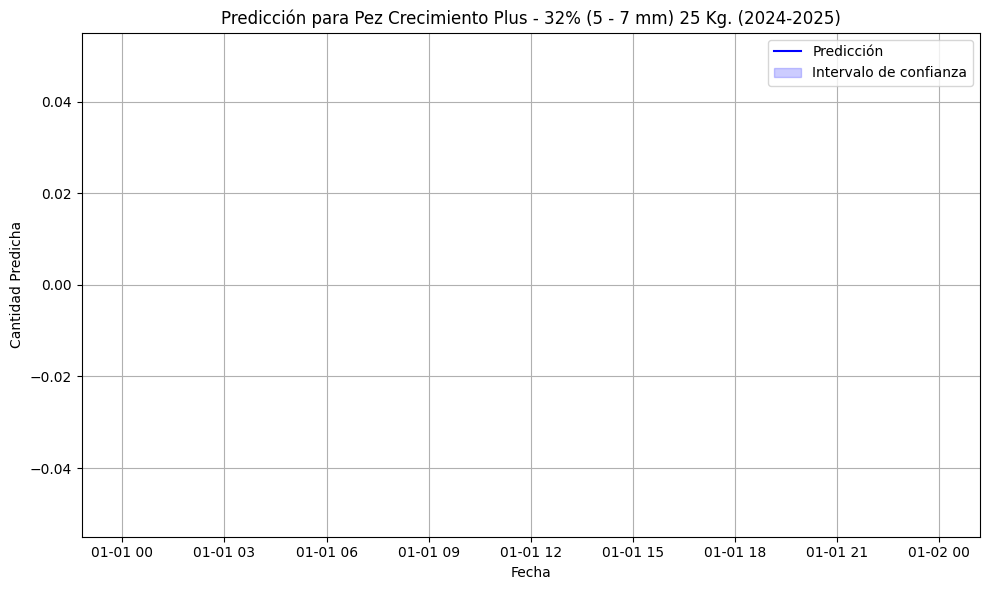

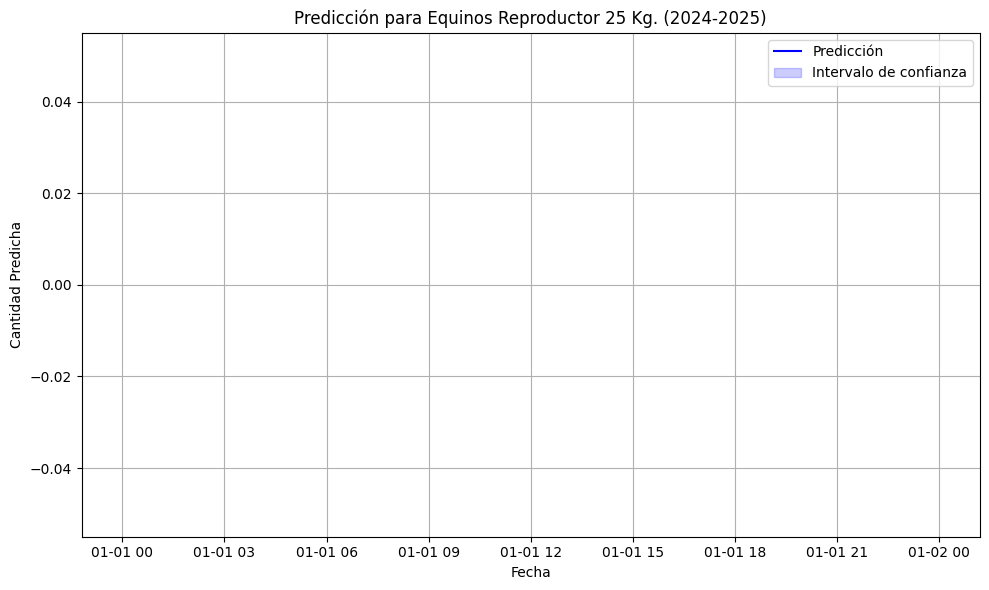

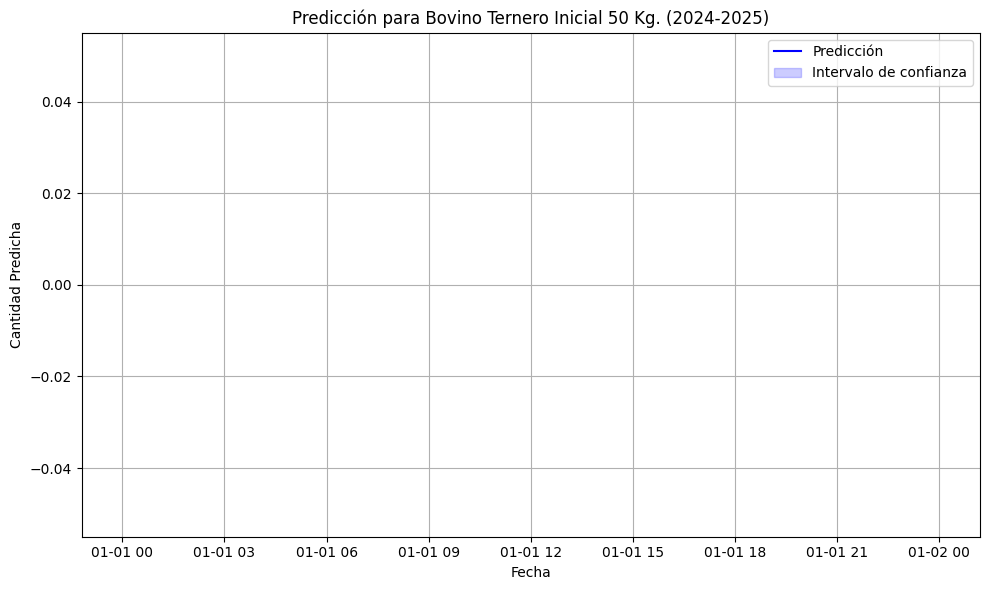

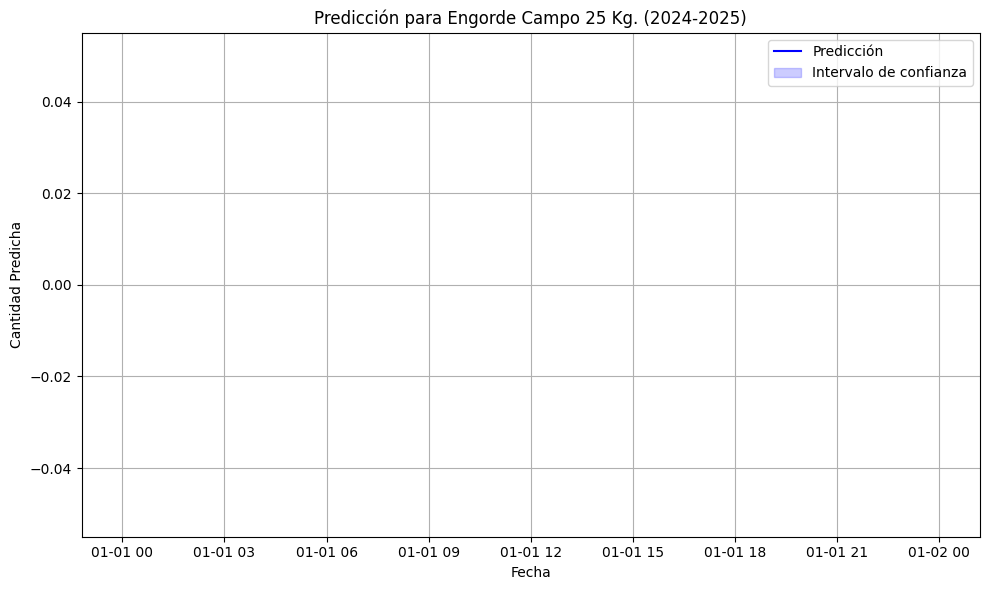

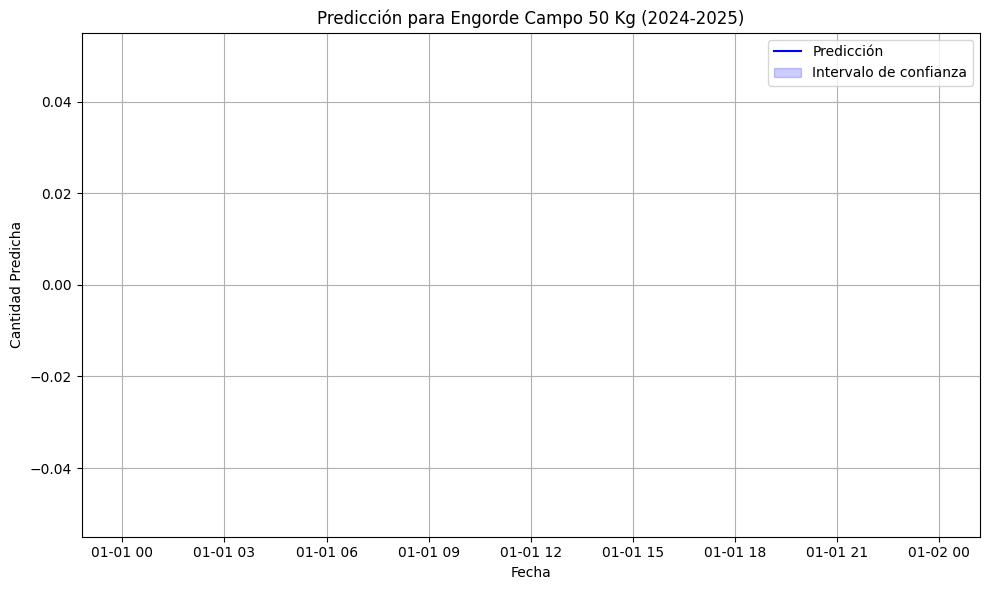

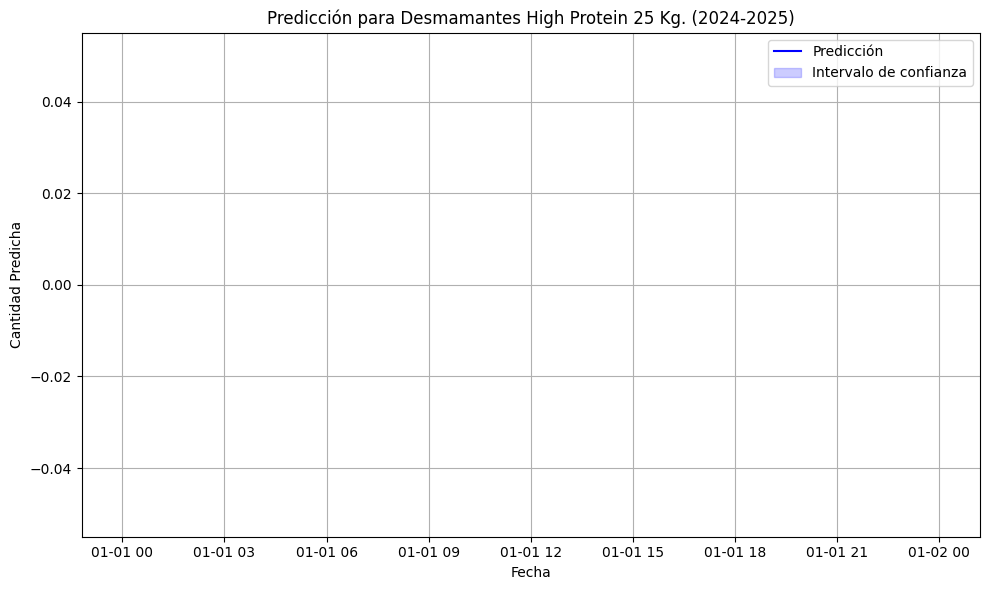

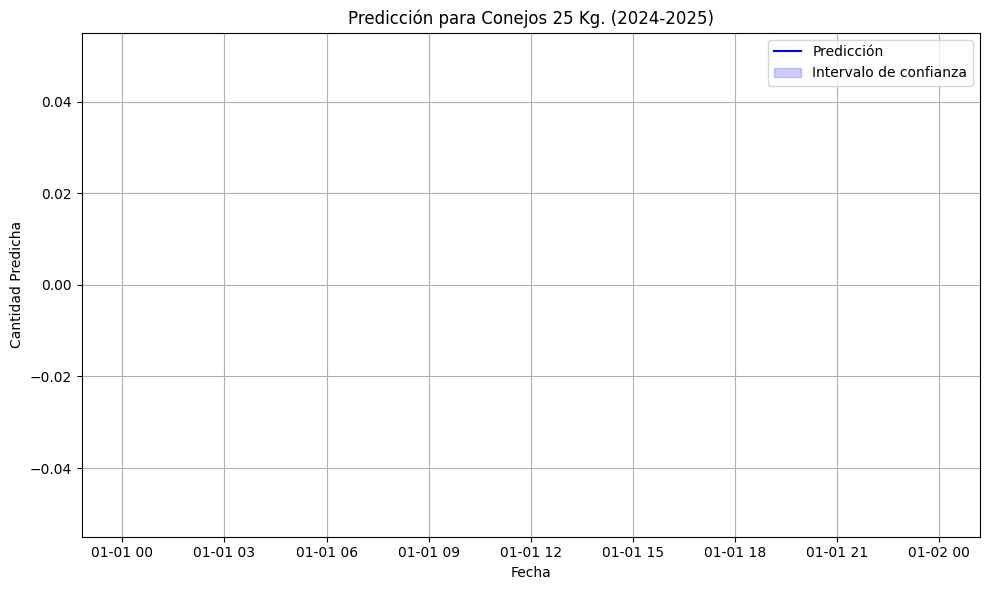

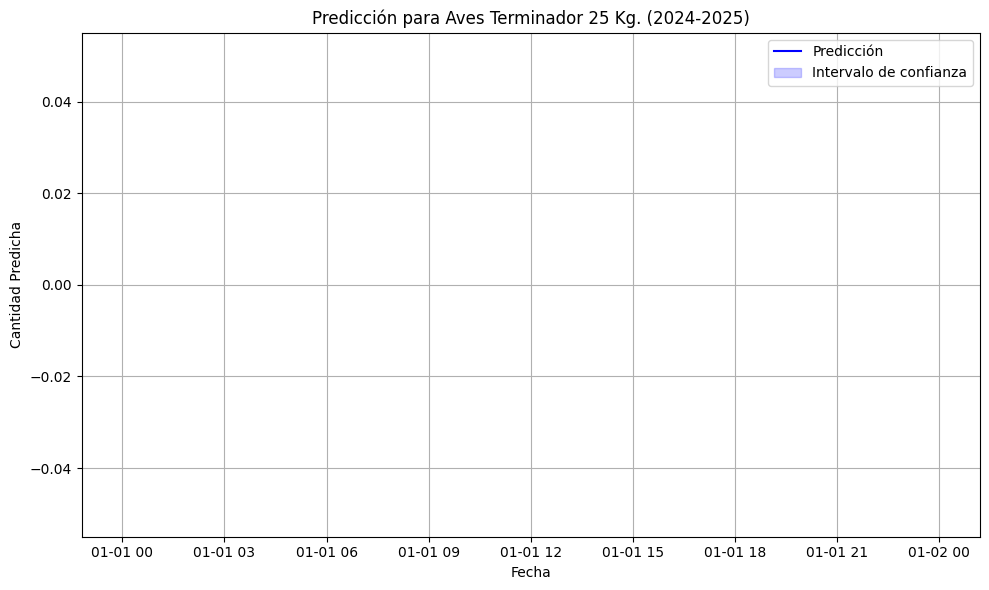

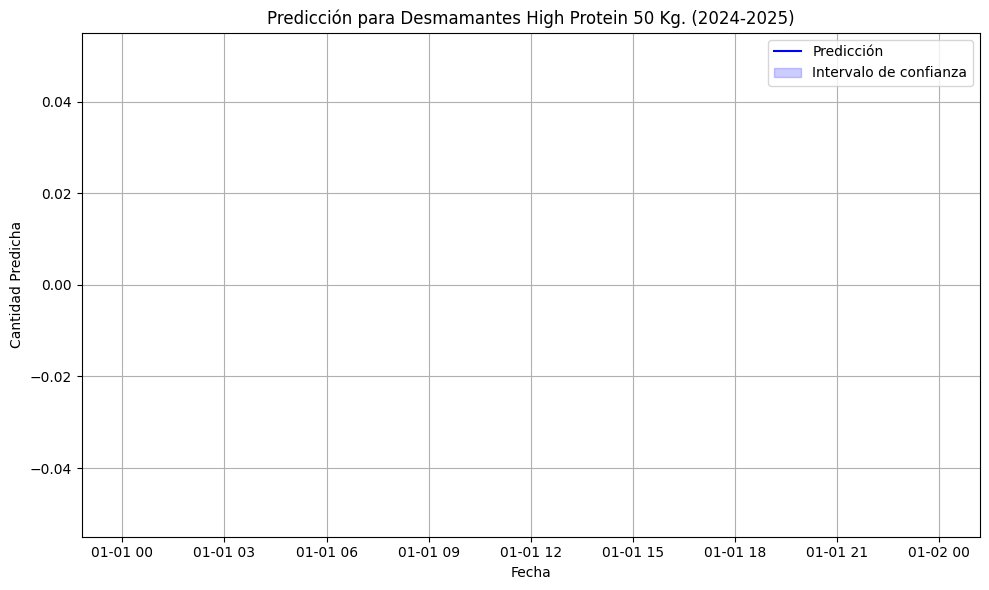

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Carpeta donde están los archivos de forecast
forecast_dir = "forecasts"

# Lista de archivos de forecast
forecast_files = [f for f in os.listdir(forecast_dir) if f.endswith('.csv')]

# Crear gráficos para cada archivo de forecast
for file in forecast_files:
    # Cargar el archivo
    file_path = os.path.join(forecast_dir, file)
    forecast = pd.read_csv(file_path)

    # Convertir la columna 'ds' a datetime
    forecast['ds'] = pd.to_datetime(forecast['ds'])

    # Filtrar los datos para 2024 y 2025
    forecast_2024_2025 = forecast[(forecast['ds'].dt.year >= 2024) & (forecast['ds'].dt.year <= 2025)]

    # Crear el gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(forecast_2024_2025['ds'], forecast_2024_2025['yhat'], label='Predicción', color='blue')
    plt.fill_between(forecast_2024_2025['ds'], forecast_2024_2025['yhat_lower'], forecast_2024_2025['yhat_upper'],
                     color='blue', alpha=0.2, label='Intervalo de confianza')
    plt.title(f"Predicción para {file.replace('_forecast.csv', '').replace('_', ' ')} (2024-2025)")
    plt.xlabel("Fecha")
    plt.ylabel("Cantidad Predicha")
    plt.legend()
    plt.grid()
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()


In [ ]:
import pandas as pd
import os

# Directorio original de archivos de forecast
forecast_dir = "forecasts"

# Crear una carpeta para guardar los forecasts positivos
positive_forecast_dir = "forecast_positivos"
os.makedirs(positive_forecast_dir, exist_ok=True)

# Lista de archivos de forecast
forecast_files = [f for f in os.listdir(forecast_dir) if f.endswith('.csv')]

# Contador de archivos positivos
positive_file_count = 0

# Resumen de valores eliminados
summary = []

# Procesar cada archivo
for file in forecast_files:
    # Cargar el archivo
    file_path = os.path.join(forecast_dir, file)
    forecast = pd.read_csv(file_path)

    # Convertir la columna 'ds' a datetime
    forecast['ds'] = pd.to_datetime(forecast['ds'])

    # Filtrar datos para 2024 y 2025
    forecast_2024_2025 = forecast[(forecast['ds'].dt.year >= 2024) & (forecast['ds'].dt.year <= 2025)]

    # Número de valores originales
    original_count = len(forecast_2024_2025)

    # Filtrar valores positivos
    forecast_filtered = forecast_2024_2025[forecast_2024_2025['yhat'] >= 0]

    # Número de valores eliminados
    removed_count = original_count - len(forecast_filtered)
    summary.append({
        "Archivo": file,
        "Originales": original_count,
        "Eliminados": removed_count,
        "Positivos": len(forecast_filtered)
    })

    # Guardar los datos filtrados en la nueva carpeta si hay positivos
    if len(forecast_filtered) > 0:
        positive_file_path = os.path.join(positive_forecast_dir, file)
        forecast_filtered.to_csv(positive_file_path, index=False)
        positive_file_count += 1
        print(f"Archivo positivo guardado: {file}")

# Mostrar el resumen
summary_df = pd.DataFrame(summary)
print("\nResumen de valores eliminados por archivo:")
print(summary_df)

# Número total de archivos positivos
print(f"\nTotal de archivos con datos positivos: {positive_file_count}")



Resumen de valores eliminados por archivo:
                                              Archivo  Originales  Eliminados  \
0                 Equinos_Carrera_50_Kg._forecast.csv           0           0   
1             Lecheras_A.P._22%_-_25_Kg._forecast.csv           0           0   
2   Cerdos_Crecimiento_Integraciï¿½n_1_x_50_Kg._fo...           0           0   
3       Bovino_Engorde_High_Energy_25_Kg_forecast.csv           0           0   
4                       Lechera_a_Granel_forecast.csv           0           0   
..                                                ...         ...         ...   
66                   Engorde_Campo_50_Kg_forecast.csv           0           0   
67       Desmamantes_High_Protein_25_Kg._forecast.csv           0           0   
68                        Conejos_25_Kg._forecast.csv           0           0   
69                Aves_Terminador_25_Kg._forecast.csv           0           0   
70       Desmamantes_High_Protein_50_Kg._forecast.csv           0

In [ ]:
import shutil

# Comprimir la carpeta forecasts
shutil.make_archive('forecast_positivos', 'zip', 'forecast_positivos')


'/content/forecast_positivos.zip'

In [ ]:
from google.colab import files

# Descargar el archivo comprimido
files.download('forecast_positivos.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Carpeta donde están los archivos filtrados con datos positivos
positive_forecast_dir = "forecast_positivos"

# Lista de archivos positivos
positive_forecast_files = [f for f in os.listdir(positive_forecast_dir) if f.endswith('.csv')]

# Crear gráficos para cada archivo de forecast positivo
for file in positive_forecast_files:
    # Cargar el archivo
    file_path = os.path.join(positive_forecast_dir, file)
    forecast = pd.read_csv(file_path)

    # Convertir la columna 'ds' a datetime
    forecast['ds'] = pd.to_datetime(forecast['ds'])

    # Filtrar los datos para 2024 y 2025
    forecast_2024_2025 = forecast[(forecast['ds'].dt.year >= 2024) & (forecast['ds'].dt.year <= 2025)]

    # Crear el gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(forecast_2024_2025['ds'], forecast_2024_2025['yhat'], label='Predicción', color='green')
    plt.fill_between(forecast_2024_2025['ds'], forecast_2024_2025['yhat_lower'], forecast_2024_2025['yhat_upper'],
                     color='green', alpha=0.2, label='Intervalo de confianza')
    plt.title(f"Predicción para {file.replace('_forecast.csv', '').replace('_', ' ')} (2024-2025)")
    plt.xlabel("Fecha")
    plt.ylabel("Cantidad Predicha")
    plt.legend()
    plt.grid()
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()


In [ ]:
# import pandas as pd
# import os

# # Corrected top 10 forecasts with MAE values
# top_10_forecasts = [
#     ('Pez Alevines 40% Polvo - 25 Kg.', 5.597368773308119),
#     ('Cerdos Terminador 50 Kg.', 6.584974200643059),
#     ('Avestruz 25 Kg.', 7.220623255423426),
#     ('Cerdos Gestación 25 Kg.', 8.821508695382374),
#     ('Cerdos Iniciador 25 Kg.', 19.642188016859066),
#     ('Cerdos Lactación 25 Kg.', 30.021179796728386),
#     ('Bovino Ternero Inicial 25 Kg.', 33.705941662415654),
#     ('Aves Ponedora 50 Kg.', 35.003559436725325),
#     ('Ovino Plus 18% - 25 Kg.', 44.22282347923771),
#     ('Codorniz 25 Kg.', 45.359720412151624),
# ]

# # Directory containing positive forecast files
# positive_forecast_dir = "forecast_positivos"

# # Initialize an empty DataFrame for consolidated data
# consolidated_data = pd.DataFrame()

# # Process each forecast in the top 10 list
# for product_name, mae in top_10_forecasts:
#     # Format the product name to match the file name in the directory
#     file_name = product_name.replace(' ', '_').replace('%', '').replace('(', '').replace(')', '').replace('.', '') + '._forecast.csv'
#     file_path = os.path.join(positive_forecast_dir, file_name)

#     if os.path.exists(file_path):
#         # Load the forecast file
#         forecast = pd.read_csv(file_path)

#         # Add the PRODUCT column
#         forecast['PRODUCT'] = product_name

#         # Append to the consolidated DataFrame
#         consolidated_data = pd.concat([consolidated_data, forecast], ignore_index=True)
#     else:
#         print(f"File not found: {file_name}")

# # Save the consolidated data to a CSV file
# output_file = "top_10_forecasts_consolidated.csv"
# consolidated_data.to_csv(output_file, index=False)
# print(f"Consolidated data saved to {output_file}")


In [ ]:
# consolidated_data

In [ ]:
# import pandas as pd

# # Asegúrate de que FECHA sea datetime
# df["ds"] = pd.to_datetime(df["ds"], format="%d/%m/%Y", errors="coerce")

# # Renombra para que coincida con los nombres de consolidated_data
# # ds = fecha
# # PRODUCT = descripción
# df.rename(
#     columns={
#         "FECHA": "ds",
#         "DESCRIPCION": "PRODUCT"
#     },
#     inplace=True
# )


In [ ]:
# consolidated_data.columns
# # ['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'PRODUCT']


In [ ]:
# consolidated_data["ds"] = pd.to_datetime(consolidated_data["ds"], errors="coerce")


NameError: name 'consolidated_data' is not defined

In [ ]:
# # Elimina puntos finales, espacios sobrantes...
# df["PRODUCT"] = df["PRODUCT"].str.strip().str.rstrip(".")
# consolidated_data["PRODUCT"] = consolidated_data["PRODUCT"].str.strip().str.rstrip(".")


In [ ]:
import os
import pandas as pd
import numpy as np

# A. Load/Prepare Actual Data
df["FECHA"] = pd.to_datetime(df["FECHA"], format="%d/%m/%Y", errors="coerce")
df_2024 = df[df["FECHA"].dt.year == 2024].copy()
df_2024 = df_2024.rename(columns={"FECHA": "ds", "TOTAL_CANTIDAD": "y"})

# B. Define an Error Function (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Filter out cases where y_true == 0 to avoid division by zero
    mask = (y_true != 0)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    if len(y_true) == 0:
        return np.nan

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100.0

# C. Iterate Over Forecast Files
positive_forecast_dir = "forecast_positivos"
forecast_files = [f for f in os.listdir(positive_forecast_dir) if f.endswith(".csv")]

results = []

for file in forecast_files:
    # 1) Identify product name
    product_name = file.replace("_forecast.csv", "").replace("_", " ")

    # 2) Load forecast
    file_path = os.path.join(positive_forecast_dir, file)
    forecast_df = pd.read_csv(file_path)

    # Convert ds to datetime
    forecast_df["ds"] = pd.to_datetime(forecast_df["ds"])

    # 3) Filter to 2024
    forecast_2024 = forecast_df[forecast_df["ds"].dt.year == 2024].copy()
    if forecast_2024.empty:
        # If no 2024 forecast rows, skip
        continue

    # 4) Actuals for this product in 2024
    df_2024_producto = df_2024[df_2024["DESCRIPCION"] == product_name].copy()
    if df_2024_producto.empty:
        continue

    # 5) Merge on ds
    merged_df = pd.merge(
        df_2024_producto[["ds", "y"]],
        forecast_2024[["ds", "yhat"]],
        on="ds",
        how="inner"
    )
    if merged_df.empty:
        continue

    # 6) Compute MAPE
    mape_val = mean_absolute_percentage_error(merged_df["y"], merged_df["yhat"])

    # 7) Store results
    results.append({
        "producto": product_name,
        "mape_2024": mape_val,
        "n_overlap_days": len(merged_df)
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Remove rows with NaN MAPE
results_df = results_df.dropna(subset=["mape_2024"])

# Sort ascending by MAPE
results_df = results_df.sort_values(by="mape_2024", ascending=True)

# Now pick top 20
top_20 = results_df.head(20)

print("=== Top 20 Productos con menor error (MAPE) en 2024 ===")
print(top_20)

# (Optional) Save to CSV
top_20.to_csv("top_20_best_products_2024.csv", index=False)


KeyError: ['mape_2024']

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# A. Create the output directory for best products
best_products_dir = "mejores_productos"
os.makedirs(best_products_dir, exist_ok=True)

# B. Convert 'FECHA' to datetime in the main dataframe if not already
df["FECHA"] = pd.to_datetime(df["FECHA"], format="%d/%m/%Y", errors="coerce")

# C. Filter real data to 2024
df_2024 = df[df["FECHA"].dt.year == 2024].copy()
df_2024.rename(columns={"FECHA": "ds"}, inplace=True)


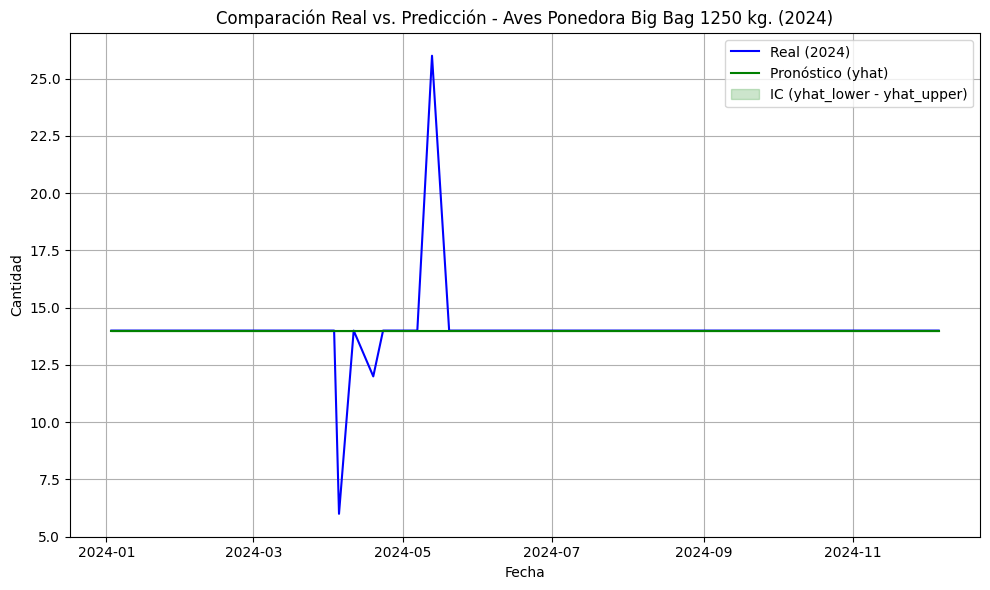

[INFO] CSV de comparación guardado en: Aves_Ponedora_Big_Bag_1250_kg._comparacion_2024.csv


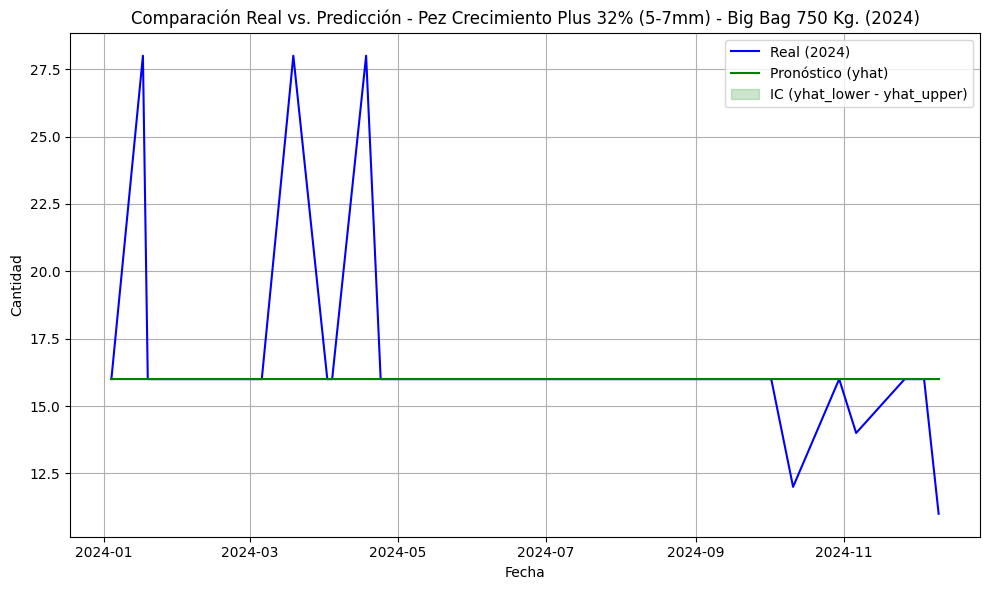

[INFO] CSV de comparación guardado en: Pez_Crecimiento_Plus_32%_(5-7mm)_-_Big_Bag_750_Kg._comparacion_2024.csv


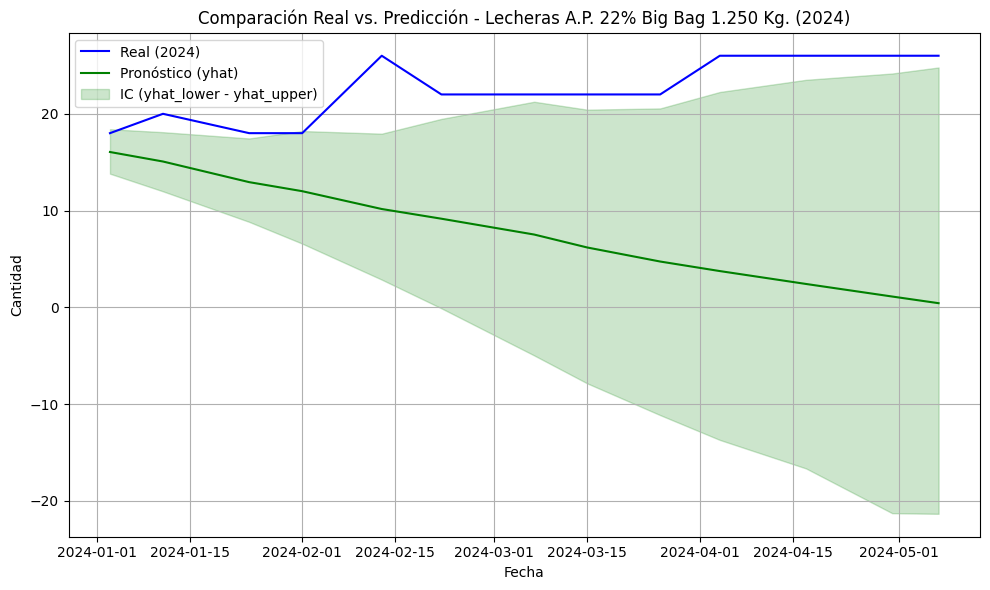

[INFO] CSV de comparación guardado en: Lecheras_A.P._22%_Big_Bag_1.250_Kg._comparacion_2024.csv


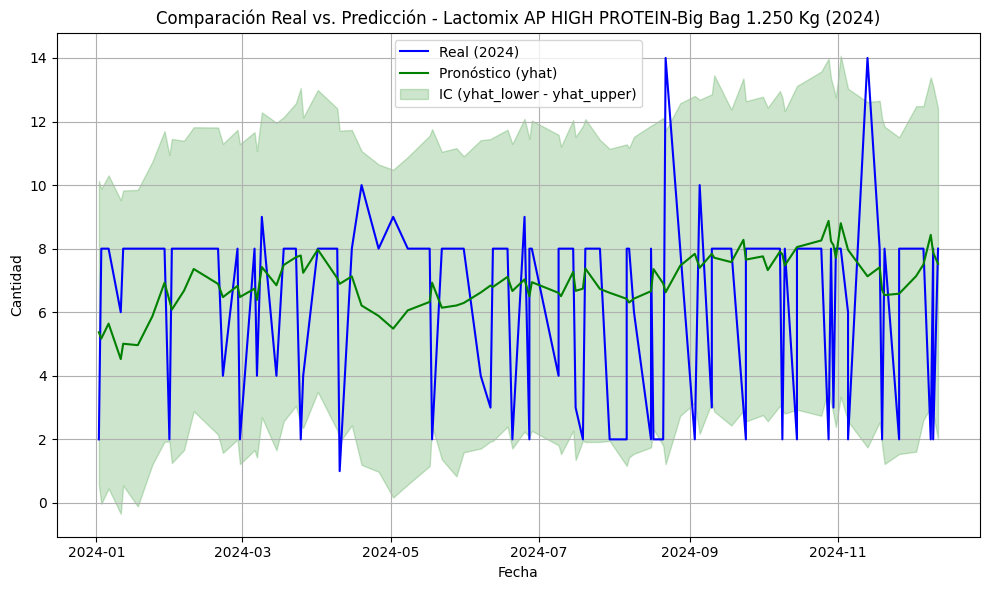

[INFO] CSV de comparación guardado en: Lactomix_AP_HIGH_PROTEIN-Big_Bag_1.250_Kg_comparacion_2024.csv


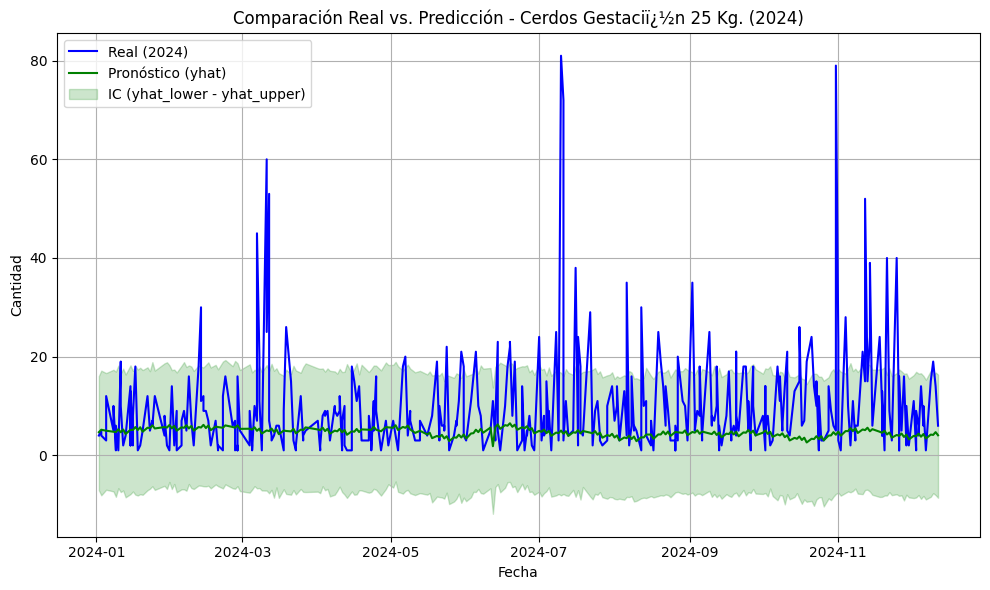

[INFO] CSV de comparación guardado en: Cerdos_Gestaciï¿½n_25_Kg._comparacion_2024.csv


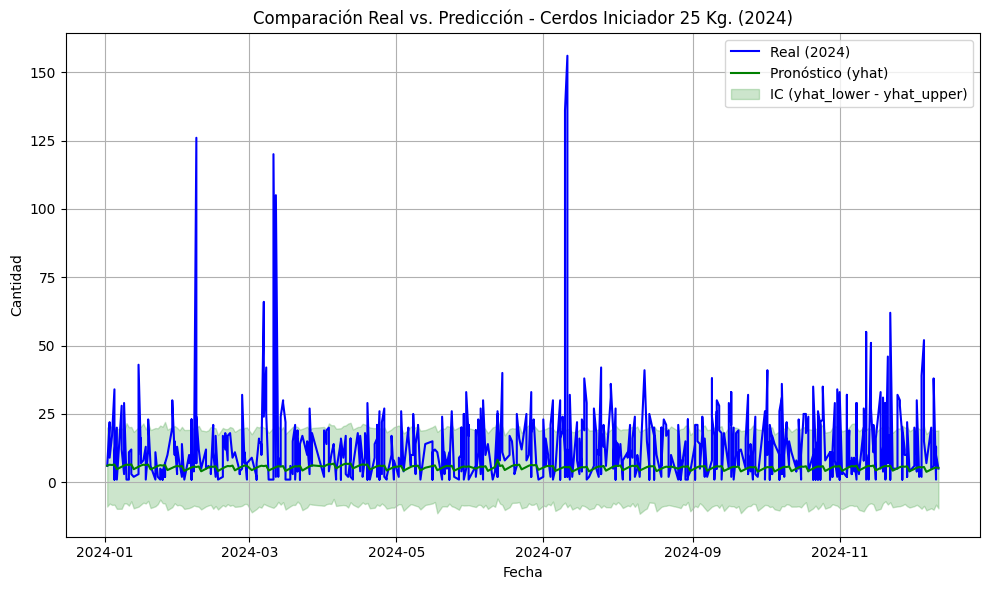

[INFO] CSV de comparación guardado en: Cerdos_Iniciador_25_Kg._comparacion_2024.csv


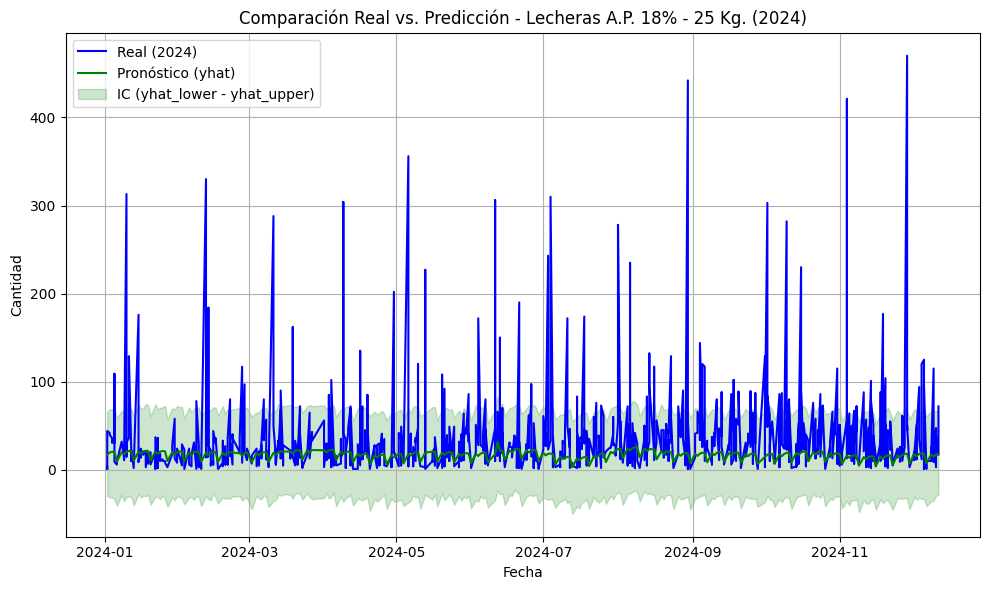

[INFO] CSV de comparación guardado en: Lecheras_A.P._18%_-_25_Kg._comparacion_2024.csv


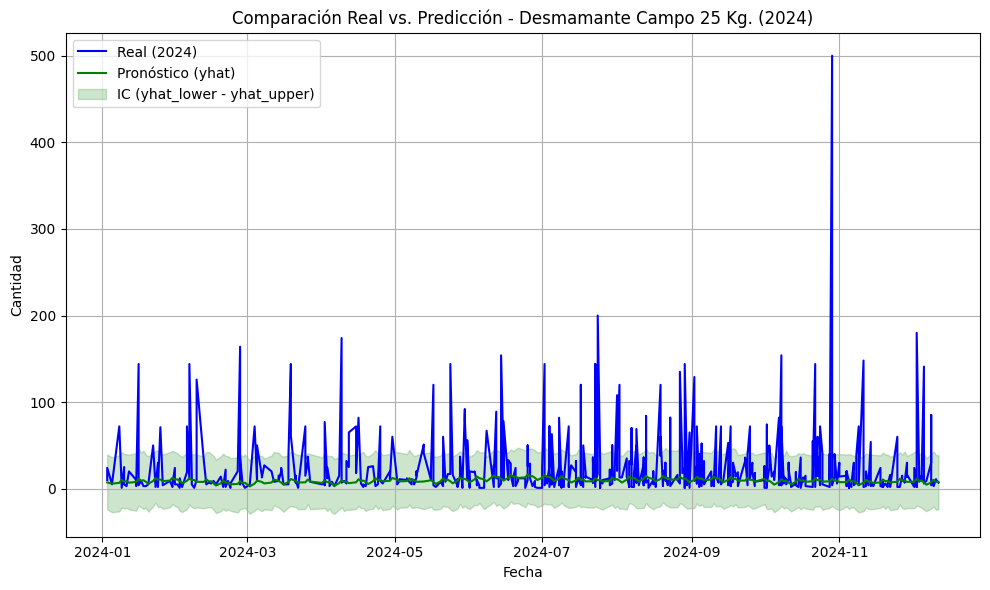

[INFO] CSV de comparación guardado en: Desmamante_Campo_25_Kg._comparacion_2024.csv


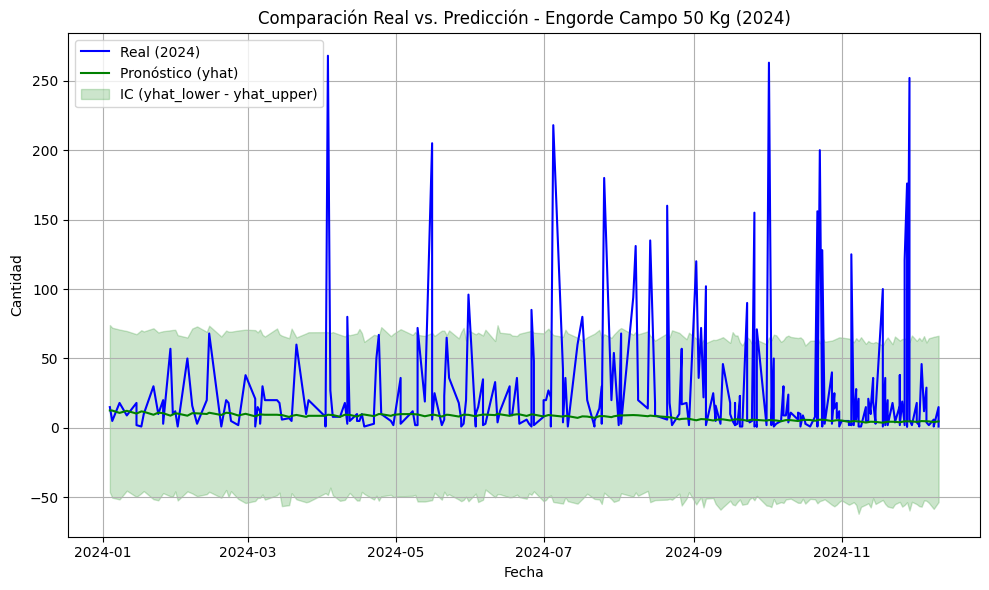

[INFO] CSV de comparación guardado en: Engorde_Campo_50_Kg_comparacion_2024.csv


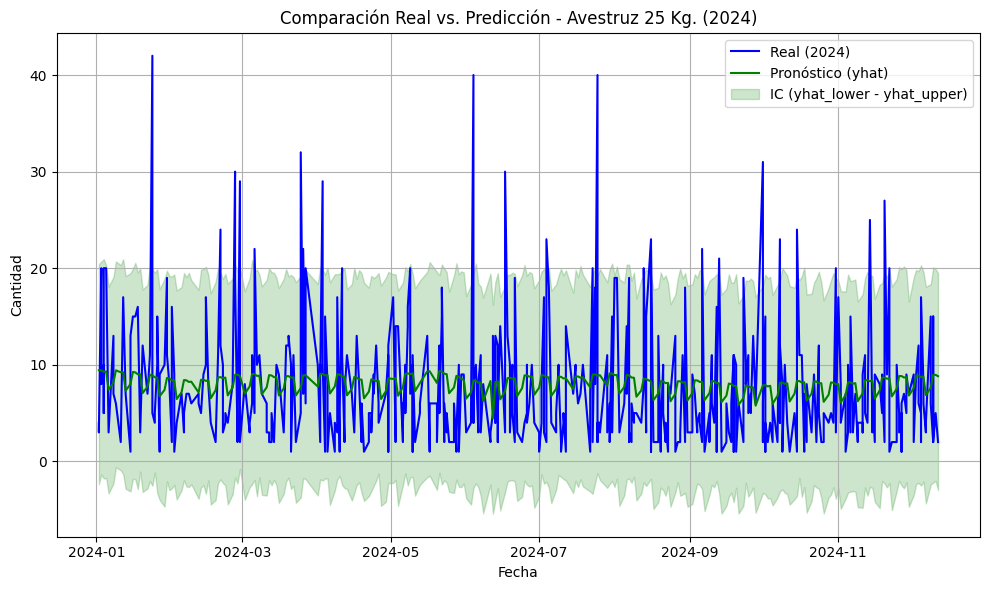

[INFO] CSV de comparación guardado en: Avestruz_25_Kg._comparacion_2024.csv


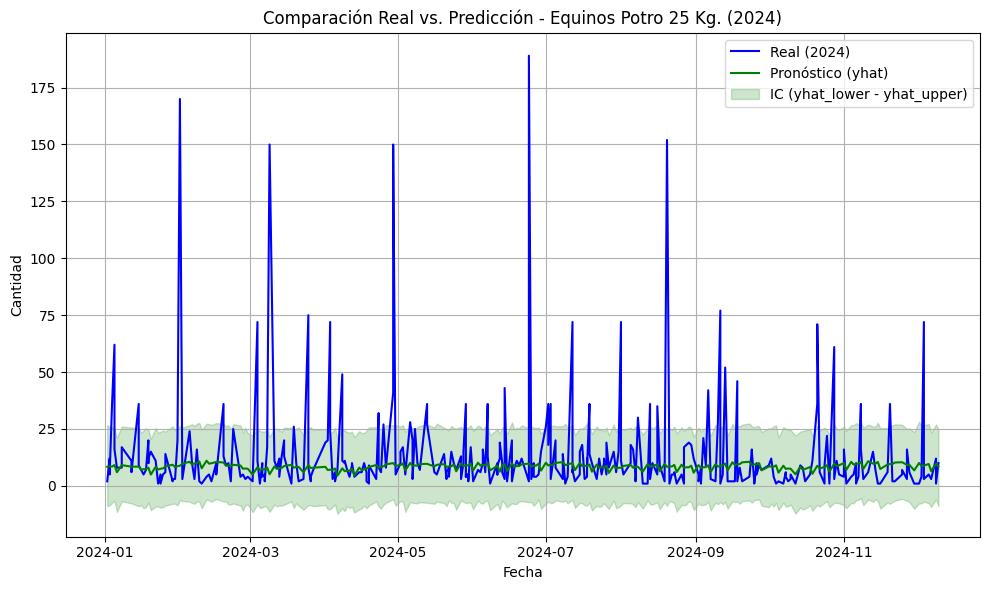

[INFO] CSV de comparación guardado en: Equinos_Potro_25_Kg._comparacion_2024.csv


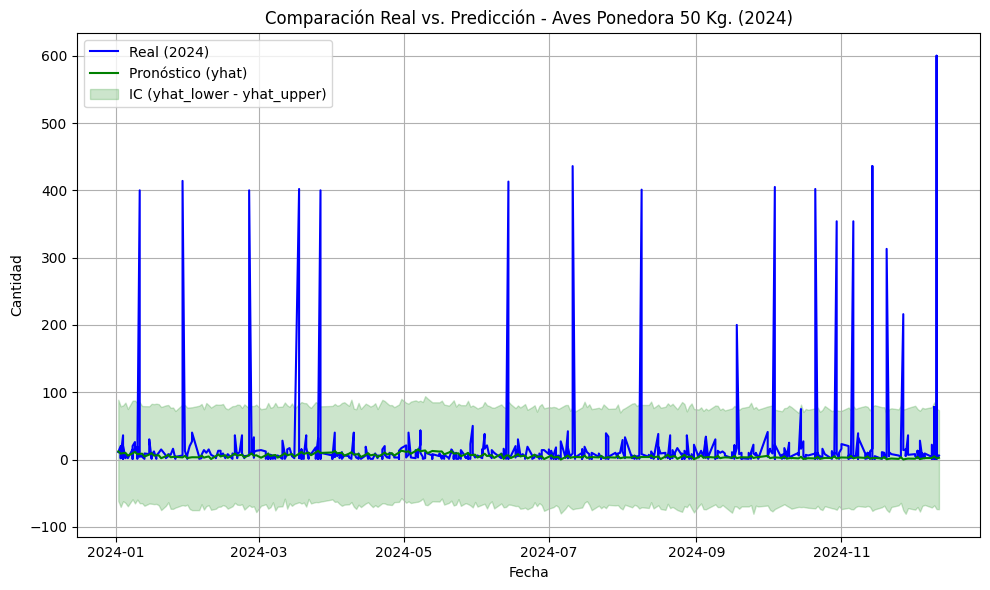

[INFO] CSV de comparación guardado en: Aves_Ponedora_50_Kg._comparacion_2024.csv


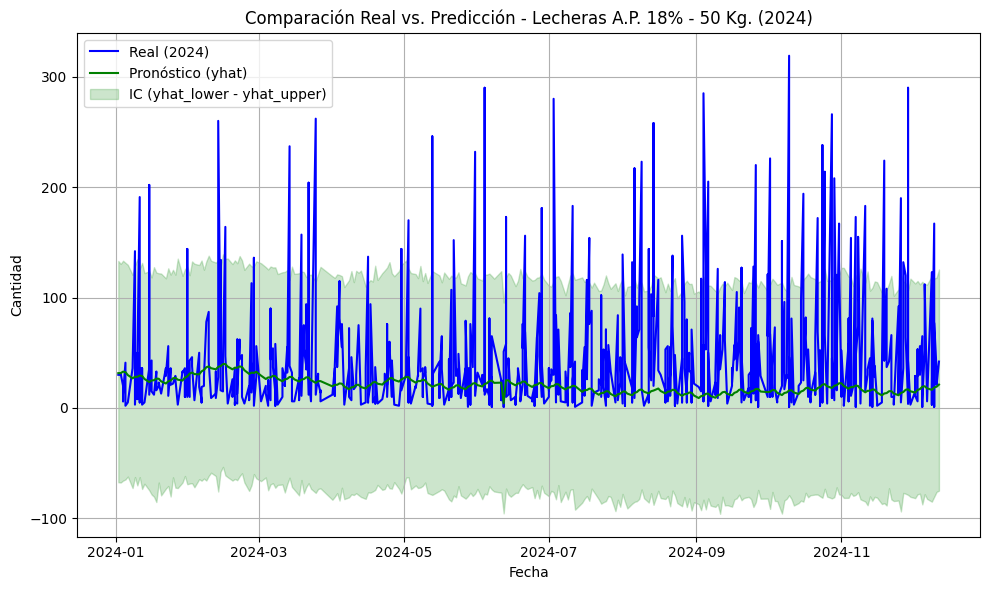

[INFO] CSV de comparación guardado en: Lecheras_A.P._18%_-_50_Kg._comparacion_2024.csv


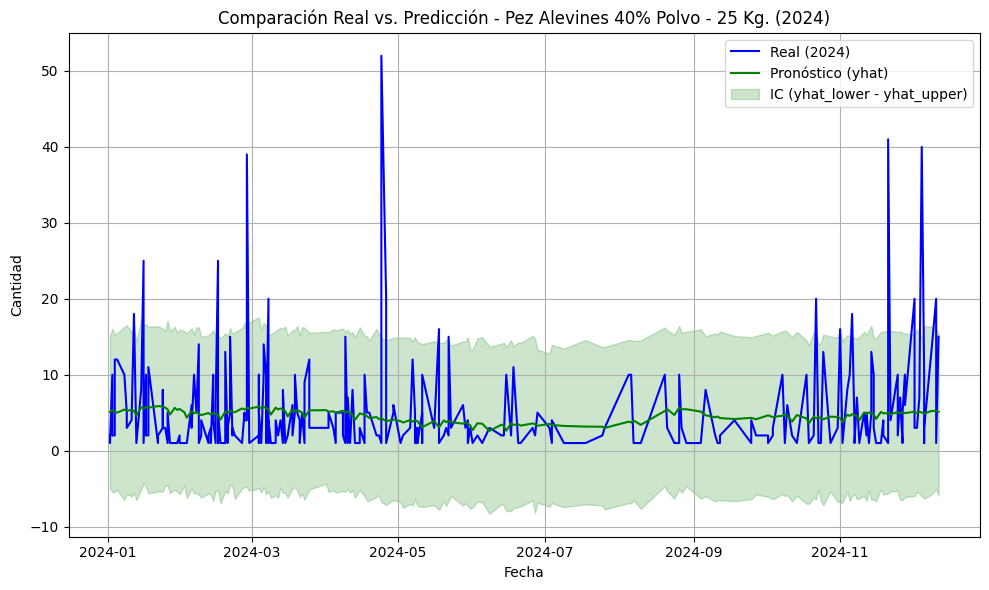

[INFO] CSV de comparación guardado en: Pez_Alevines_40%_Polvo_-_25_Kg._comparacion_2024.csv


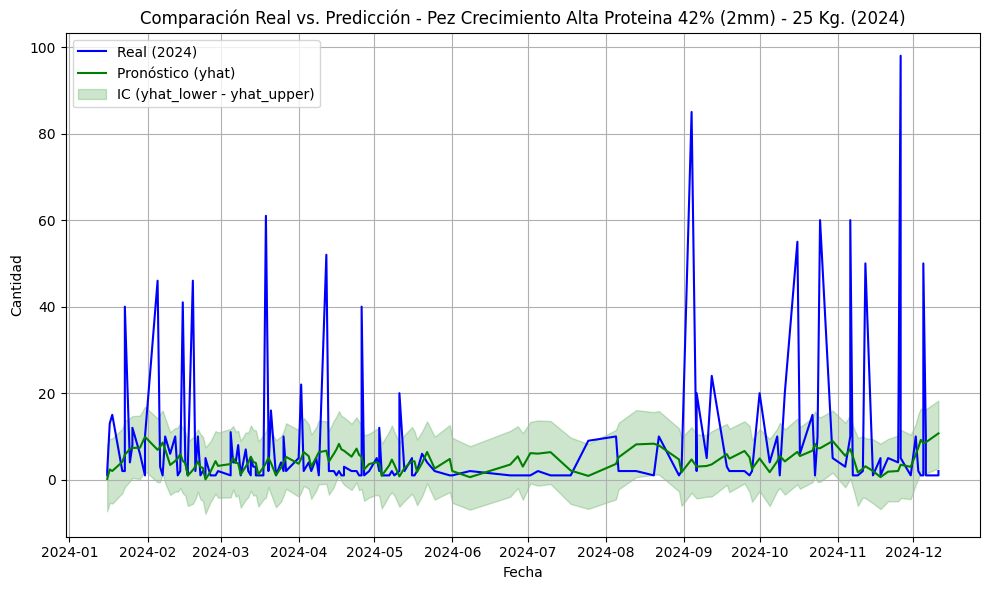

[INFO] CSV de comparación guardado en: Pez_Crecimiento_Alta_Proteina_42%_(2mm)_-_25_Kg._comparacion_2024.csv


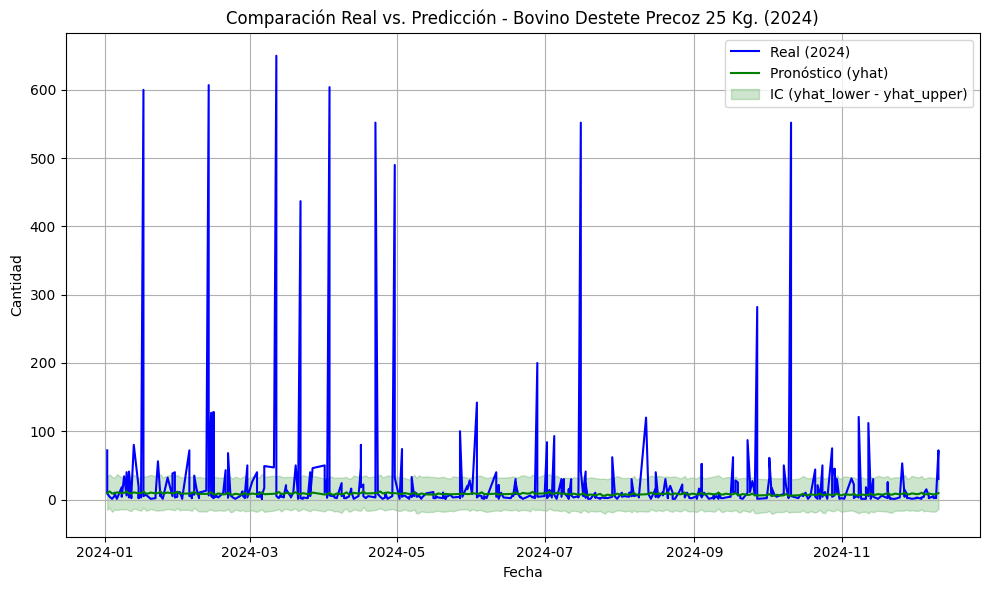

[INFO] CSV de comparación guardado en: Bovino_Destete_Precoz_25_Kg._comparacion_2024.csv


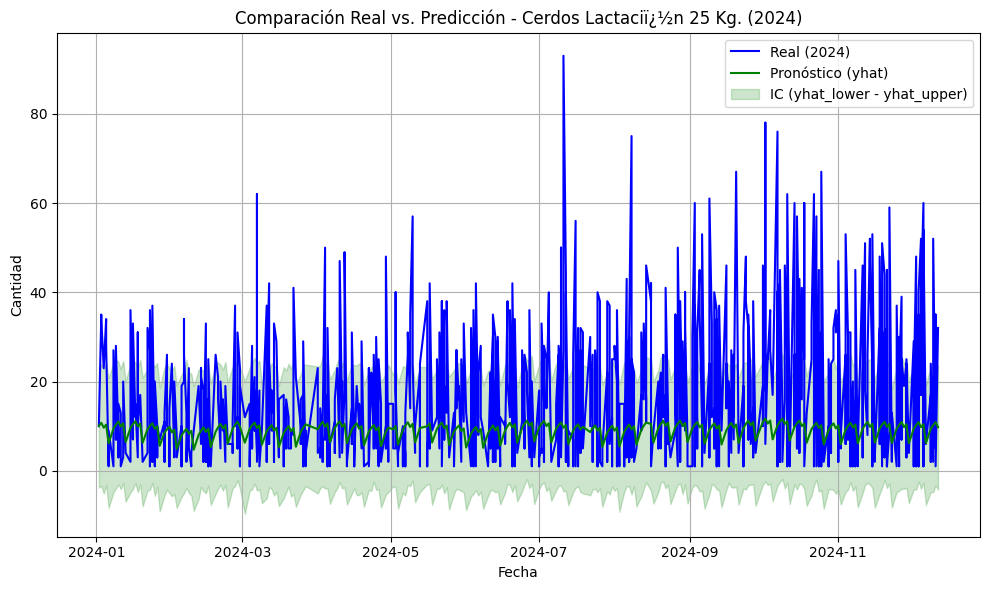

[INFO] CSV de comparación guardado en: Cerdos_Lactaciï¿½n_25_Kg._comparacion_2024.csv


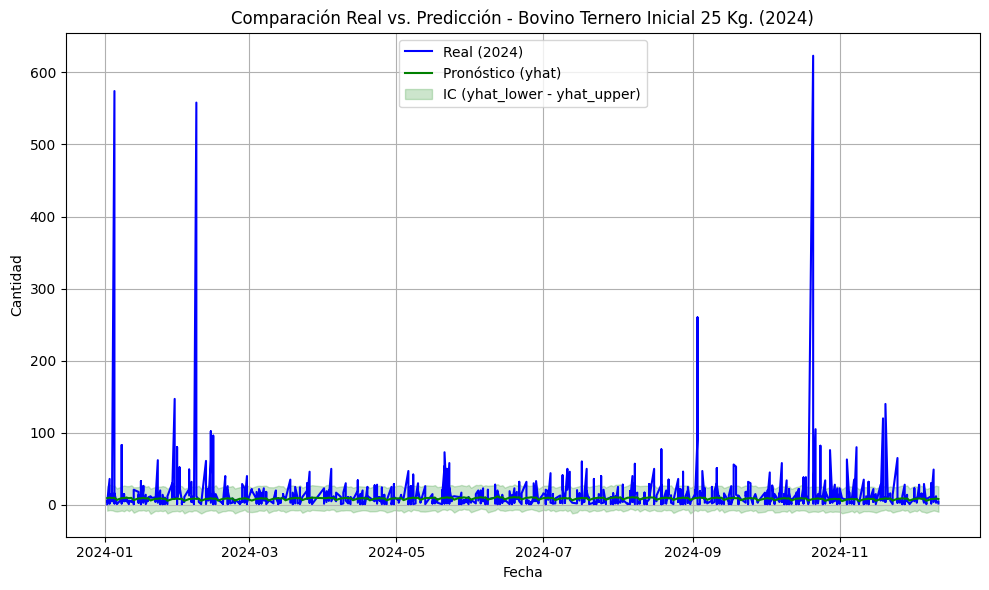

[INFO] CSV de comparación guardado en: Bovino_Ternero_Inicial_25_Kg._comparacion_2024.csv


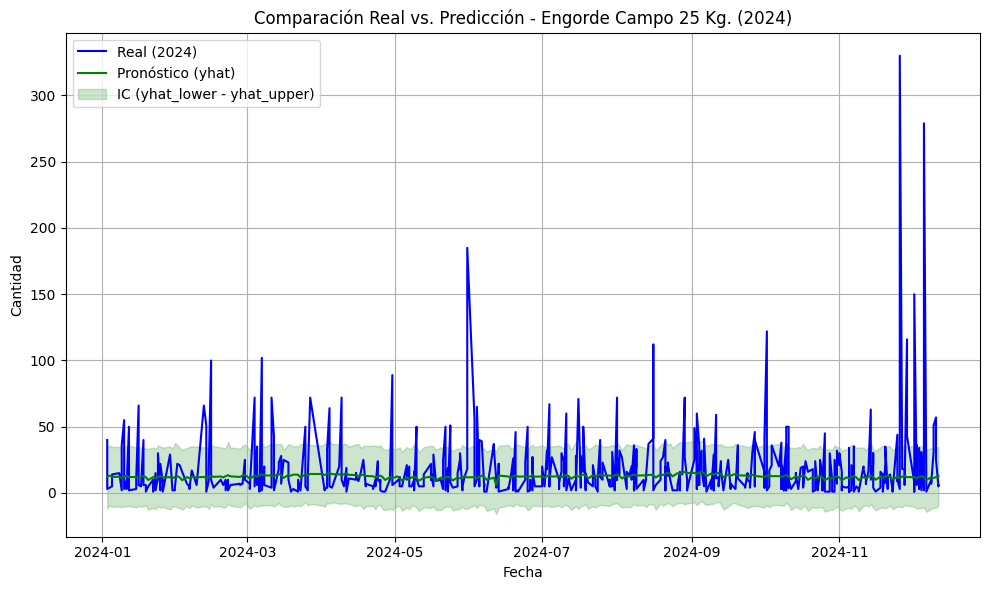

[INFO] CSV de comparación guardado en: Engorde_Campo_25_Kg._comparacion_2024.csv


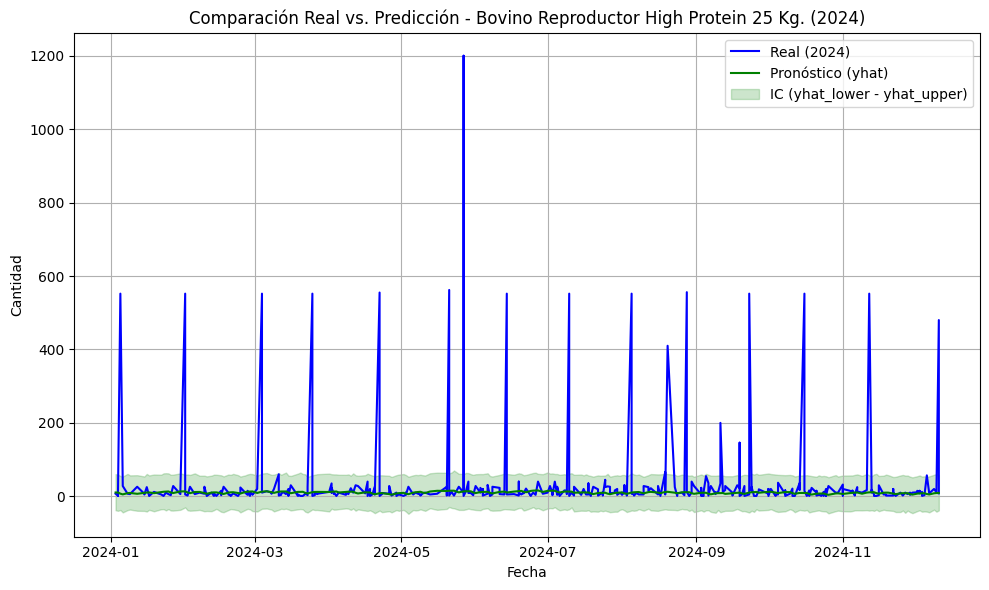

[INFO] CSV de comparación guardado en: Bovino_Reproductor_High_Protein_25_Kg._comparacion_2024.csv


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# 1) Crear la carpeta "mejores_productos" (para guardar únicamente los CSV)
# ---------------------------------------------------------------------
best_products_dir = "mejores_productos"
os.makedirs(best_products_dir, exist_ok=True)

# ---------------------------------------------------------------------
# 2) Asegurar que df tenga FECHA como datetime y filtrar data del 2024
# ---------------------------------------------------------------------
df["FECHA"] = pd.to_datetime(df["FECHA"], format="%d/%m/%Y", errors="coerce")

df_2024 = df[df["FECHA"].dt.year == 2024].copy()
df_2024.rename(columns={"FECHA": "ds", "TOTAL_CANTIDAD": "y"}, inplace=True)

# ---------------------------------------------------------------------
# 3) top_20: DataFrame con las 20 filas (productos) con mejor resultado
#    Debe tener una columna "producto" que coincida con DESCRIPCION en df
# ---------------------------------------------------------------------
# Ejemplo (ya definido en tu script anterior):
# top_20 = pd.DataFrame({
#     "producto": ["Producto A", "Producto B", ...],
#     "mape_2024": [10.5, 11.2, ...]
# })

# ---------------------------------------------------------------------
# 4) Ubicación de los forecasts con valores positivos
# ---------------------------------------------------------------------
positive_forecast_dir = "forecast_positivos"

# ---------------------------------------------------------------------
# 5) Iterar sobre cada producto en top_20
# ---------------------------------------------------------------------
for idx, row in top_20.iterrows():
    product_name = row["producto"]

    # Generar el nombre de archivo: "Producto A" -> "Producto_A_forecast.csv"
    forecast_filename = product_name.replace(" ", "_") + "_forecast.csv"
    forecast_path = os.path.join(positive_forecast_dir, forecast_filename)

    # Verificar si existe ese archivo
    if not os.path.exists(forecast_path):
        print(f"[AVISO] No se encontró forecast para '{product_name}'. Se omite.")
        continue

    # 6) Cargar forecast
    forecast_df = pd.read_csv(forecast_path)
    forecast_df["ds"] = pd.to_datetime(forecast_df["ds"])

    # Filtrar a datos de 2024
    forecast_2024 = forecast_df[forecast_df["ds"].dt.year == 2024].copy()
    if forecast_2024.empty:
        print(f"[INFO] Forecast de 2024 vacío para '{product_name}'. Se omite.")
        continue

    # 7) Obtener datos reales de df_2024 para este producto
    df_2024_producto = df_2024[df_2024["DESCRIPCION"] == product_name].copy()
    if df_2024_producto.empty:
        print(f"[INFO] No hay datos reales 2024 para '{product_name}'. Se omite.")
        continue

    # (Opcional) Calcular precio promedio del 2024 si existe la columna
    if "PRECIO_UNITARIO" in df_2024_producto.columns:
        avg_price = df_2024_producto["PRECIO_UNITARIO"].mean()
    else:
        avg_price = np.nan

    # 8) Hacer el merge (fechas en común)
    merged_df = pd.merge(
        df_2024_producto[["ds", "y"]],
        forecast_2024[["ds", "yhat", "yhat_lower", "yhat_upper"]],
        how="inner",
        on="ds"
    )
    if merged_df.empty:
        print(f"[INFO] No hay fechas solapadas para '{product_name}'. Se omite.")
        continue

    merged_df["producto"] = product_name
    merged_df["precio_promedio_2024"] = avg_price

    merged_df.sort_values(by="ds", inplace=True)

    # 9) Graficar (mostrar inline, no guardar PNG)
    plt.figure(figsize=(10, 6))

    # Datos reales en azul
    plt.plot(merged_df["ds"], merged_df["y"], label="Real (2024)", color="blue")

    # Pronóstico en verde
    plt.plot(merged_df["ds"], merged_df["yhat"], label="Pronóstico (yhat)", color="green")

    # Banda de confianza
    plt.fill_between(
        merged_df["ds"],
        merged_df["yhat_lower"],
        merged_df["yhat_upper"],
        color="green",
        alpha=0.2,
        label="IC (yhat_lower - yhat_upper)"
    )

    # Detalles de la gráfica
    plt.title(f"Comparación Real vs. Predicción - {product_name} (2024)")
    plt.xlabel("Fecha")
    plt.ylabel("Cantidad")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Mostrar la gráfica en el output
    plt.show()

    # 10) Guardar CSV de comparación en "mejores_productos"
    csv_filename = product_name.replace(" ", "_") + "_comparacion_2024.csv"
    csv_path = os.path.join(best_products_dir, csv_filename)
    merged_df.to_csv(csv_path, index=False)

    print(f"[INFO] CSV de comparación guardado en: {csv_filename}")
